In [1]:
%matplotlib inline
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image, Audio, clear_output

import geopandas

import pickle

import zipfile

import os

from scipy import sparse

import time

from ast import literal_eval as make_tuple

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster

from zipfile import ZipFile

import imageio

import shutil

import networkx as nx
from networkx.algorithms import community
import community as cm

from tqdm import tnrange, tqdm_notebook, tqdm

import dask.dataframe as dd

import collections

import torch
import torch.nn as nn
# from torch.utils.data import DataLoader, Dataset

import torch_geometric.nn as gnn
from torch_geometric.data import Data, DataLoader, Dataset

In [2]:
torch.cuda.get_device_name(0)

GPU = True
device_idx = 1
if GPU:
    device = torch.device("cuda:" + str(device_idx - 1) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [3]:
network = nx.read_graphml("runs/graphs/m207.graphml")

attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]

# nx.draw_kamada_kawai(network, node_size=15, node_color=attrs)

# plt.show()

In [4]:
def wider_input(new_dim, ae):
    new_layers = new_dim - ae.linear1.lin.weight.shape[1]

    if new_layers <= 0:
#         print("returning")
        return ae
    new_indices = list(np.random.choice(ae.linear1.lin.weight.shape[1], new_layers, replace=True))

    weights = ae.linear1.lin.weight
    weights = torch.transpose(weights, 0, 1)
    biases = ae.linear1.lin.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]


    new_weights = []

    for i in counts:
        weights[i[0]] *= 1/(1+i[1])
        new_weight = (weights[i[0]] * 1/(1+i[1])).view(1,-1)
        new_weights.append(new_weight)

    new_weights = torch.cat(new_weights)
    new_weights = torch.cat([weights, new_weights])
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    new_weights = torch.transpose(new_weights, 0, 1)

    biases = biases * ae.linear1.lin.weight.shape[1] / new_dim
#     biases = biases + torch.randn(biases.shape).to(device) * 0.1

#     ae.linear1.lin.in_features = new_dim
    ae.linear1.in_channels = new_dim
    ae.linear1.lin.in_channels = new_dim
    ae.linear1.lin.bias = torch.nn.Parameter(biases)
    ae.linear1.lin.weight = torch.nn.Parameter(new_weights)
    return ae
    
def wider_output(new_dim, ae):
    
    new_layers = new_dim - ae.linear4.lin.weight.shape[0]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.linear4.lin.weight.shape[0], new_layers, replace=True))

    weights = ae.linear4.lin.weight
#     weights = torch.transpose(weights, 0, 1)
    biases = ae.linear4.lin.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]

    new_biases = []
    new_weights = []

    for i in counts:
        weights[i[0]] *= 1/(1+i[1])
        new_weight = (weights[i[0]] * 1/(1+i[1])).view(1,-1)
        new_weights.append(new_weight + torch.randn(new_weight.shape).to(device) * 0.1)
        
        biases[i[0]] *= 1/(1+i[1])
        new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
        new_biases.append(new_bias + torch.randn(new_bias.shape).to(device) * 0.1)


    new_weights = torch.cat(new_weights)
    new_weights = torch.cat([weights, new_weights])
#     new_weights = torch.transpose(new_weights, 0, 1)
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    
    new_biases = torch.cat(new_biases).view(-1)
    new_biases = torch.cat([biases, new_biases])
#     new_biases = new_biases + torch.randn(new_biases.shape).to(device) * 0.1

    ae.linear4.out_features = new_dim
    ae.linear4.out_channels = new_dim
    ae.linear4.lin.bias = torch.nn.Parameter(new_biases)
    ae.linear4.lin.weight = torch.nn.Parameter(new_weights)
    return ae

def wider_decode(new_dim, ae):
        
    new_layers = new_dim - ae.decode_linear.weight.shape[0]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.decode_linear.weight.shape[0], new_layers, replace=True))

    weights = ae.decode_linear.weight
#     weights = torch.transpose(weights, 0, 1)
    biases = ae.decode_linear.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]

    new_biases = []
    new_weights = []

    for i in counts:
        weights[i[0]] *= 1/(1+i[1])
        new_weight = (weights[i[0]] * 1/(1+i[1])).view(1,-1)
        new_weights.append(new_weight + torch.randn(new_weight.shape).to(device) * 0.1)
        
        biases[i[0]] *= 1/(1+i[1])
        new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
        new_biases.append(new_bias + torch.randn(new_bias.shape).to(device) * 0.1)


    new_weights = torch.cat(new_weights)
    new_weights = torch.cat([weights, new_weights])
#     new_weights = torch.transpose(new_weights, 0, 1)
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    
    new_biases = torch.cat(new_biases).view(-1)
    new_biases = torch.cat([biases, new_biases])
#     new_biases = new_biases + torch.randn(new_biases.shape).to(device) * 0.1

    ae.decode_linear.out_features = new_dim
    ae.decode_linear.out_channels = new_dim
    ae.decode_linear.bias = torch.nn.Parameter(new_biases)
    ae.decode_linear.weight = torch.nn.Parameter(new_weights)
    return ae

def wider_cheb_input(new_dim, ae):
        
    new_layers = new_dim - ae.linear1.weight.shape[1]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.linear1.weight.shape[1], new_layers, replace=True))

    weights = ae.linear1.weight
#     weights = torch.transpose(weights, 0, 1)
#     biases = ae.linear1.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]

#     new_biases = []
    new_weights = []

    for i in counts:
        weights[:, i[0]] *= 1/(1+i[1])
        new_weight = (weights[:, i[0]] * 1/(1+i[1])).view(weights.shape[0],1,-1)
        
        new_weights.append(new_weight + torch.randn(new_weight.shape).to(device) * 0.1)
        
#         biases[i[0]] *= 1/(1+i[1])
#         new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
#         new_biases.append(new_bias + torch.randn(new_bias.shape).to(device) * 0.1)


    new_weights = torch.cat(new_weights, dim=1)
    new_weights = torch.cat([weights, new_weights], dim=1)
    
#     new_weights = torch.transpose(new_weights, 0, 1)
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    
#     new_biases = torch.cat(new_biases).view(-1)
#     new_biases = torch.cat([biases, new_biases])
#     new_biases = new_biases + torch.randn(new_biases.shape).to(device) * 0.1

    ae.linear1.in_channels = new_dim
#     ae.linear1.bias = torch.nn.Parameter(new_biases)
    ae.linear1.weight = torch.nn.Parameter(new_weights)
    return ae

def wider_cheb_output(new_dim, ae):
        
    new_layers = new_dim - ae.linear4.weight.shape[2]
    if new_layers <= 0:
        return ae
    new_indices = list(np.random.choice(ae.linear4.weight.shape[2], new_layers, replace=True))

    weights = ae.linear4.weight
#     weights = torch.transpose(weights, 0, 1)
    biases = ae.linear4.bias

    counts = [(i, new_indices.count(i)) for i in new_indices]

    new_biases = []
    new_weights = []

    for i in counts:
        weights[:, :, i[0]] *= 1/(1+i[1])
        new_weight = (weights[:, :, i[0]] * 1/(1+i[1])).view(weights.shape[0],-1,1)
        new_weights.append(new_weight + torch.randn(new_weight.shape).to(device) * 0.1)
        
        biases[i[0]] *= 1/(1+i[1])
        new_bias = (biases[i[0]] * 1/(1+i[1])).view(1,-1)
        new_biases.append(new_bias + torch.randn(new_bias.shape).to(device) * 0.1)


    new_weights = torch.cat(new_weights, dim=2)
    
    new_weights = torch.cat([weights, new_weights], dim=2)
    
#     new_weights = torch.transpose(new_weights, 0, 1)
#     new_weights = new_weights + torch.randn(new_weights.shape).to(device) * 0.1
    
    new_biases = torch.cat(new_biases).view(-1)
    new_biases = torch.cat([biases, new_biases])
#     new_biases = new_biases + torch.randn(new_biases.shape).to(device) * 0.1

    ae.linear4.out_channels = new_dim
    ae.linear4.bias = torch.nn.Parameter(new_biases)
    ae.linear4.weight = torch.nn.Parameter(new_weights)
    return ae

In [5]:
class StaticEncoder(nn.Module):
    def __init__(self, hidden_size, input_dim, mid_layer, corrupt=0.01):
        super(StaticEncoder, self).__init__()
        
        self.linear1 = gnn.ChebConv(input_dim, mid_layer, 2)
        self.b1 = nn.BatchNorm1d(mid_layer)
#         self.linear2 = gnn.SGConv(mid_layer, hidden_size)
        self.linear2 = gnn.ChebConv(mid_layer, hidden_size, 2)
        
        self.linear3 = gnn.ChebConv(hidden_size, mid_layer, 2)
        self.b2 = nn.BatchNorm1d(mid_layer)
        self.linear4 = gnn.ChebConv(mid_layer, input_dim, 2)
        
        self.prod_linear = nn.Linear(hidden_size, 1)
        
        self.corrupt = corrupt
                
        self.activ = nn.LeakyReLU()
        
    def encode(self, x, edges):
        
        noise = torch.rand(x.shape)
        x[noise < self.corrupt] = 0
        
        x = self.linear1(x, edges)
        x = self.b1(x)
        x = self.activ(x)
        x = self.linear2(x, edges)
        
        return x
    
    def decode(self, z, edges):
        
        z = self.linear3(z, edges)
        z = self.activ(z)
        z = self.b2(z)
        z = self.linear4(z, edges)
        
        return z

#     def decode(self, z, edges):
#         return self.decode_linear(z)

    def predict_product(self, x):
        return self.prod_linear(x)

    def forward(self, d):
        x, edges = d.x, d.edge_index
                
        x = x.float()
        z = self.encode(x, edges)
        recon = self.decode(z, edges)
        prod = self.predict_product(z)
        
        return recon, z, prod

In [6]:
adj_list = [(int(n), [int(x) for x in list(neighbors)]) for n, neighbors in network.adjacency()]
adj_list = [(x[0], y) for x in adj_list for y in x[1]]
adj_list = torch.tensor(adj_list).to(device)
adj_list = torch.transpose(adj_list, 0, 1)

adj_mat = nx.adjacency_matrix(network)
adj_mat = nx.to_numpy_matrix(network)

attr_tensor = torch.from_numpy(adj_mat).to(device).double()
print(adj_list.shape)

print(attr_tensor.shape)

data = Data(x=attr_tensor, edge_index=adj_list).to(device)

torch.Size([2, 718])
torch.Size([161, 161])


sparsity:  0.030168589174800354
transitioning: 161 -> 161


Total Loss: 0.80511 | Recon Loss: 0.44957 | Edge Loss: 0.26716 | A-M Loss: 0.08604
Total Loss: 0.66836 | Recon Loss: 0.37695 | Edge Loss: 0.24778 | A-M Loss: 0.04127
Total Loss: 0.52143 | Recon Loss: 0.27352 | Edge Loss: 0.22009 | A-M Loss: 0.02545
Total Loss: 0.45004 | Recon Loss: 0.20186 | Edge Loss: 0.22637 | A-M Loss: 0.01945
Total Loss: 0.39971 | Recon Loss: 0.16292 | Edge Loss: 0.21532 | A-M Loss: 0.01912
sparsity:  0.030102118579484836
transitioning: 161 -> 162


Total Loss: 0.38303 | Recon Loss: 0.14567 | Edge Loss: 0.21695 | A-M Loss: 0.01805
Total Loss: 0.37622 | Recon Loss: 0.11474 | Edge Loss: 0.24473 | A-M Loss: 0.01443
Total Loss: 0.35264 | Recon Loss: 0.09823 | Edge Loss: 0.23851 | A-M Loss: 0.01360
Total Loss: 0.32101 | Recon Loss: 0.08578 | Edge Loss: 0.21975 | A-M Loss: 0.01321
Total Loss: 0.30585 | Recon Loss: 0.07761 | Edge Loss: 0.21505 | A-M Loss: 0.01096
sparsity:  0.03026083029094057
transitioning: 162 -> 163


Total Loss: 0.32638 | Recon Loss: 0.09746 | Edge Loss: 0.21473 | A-M Loss: 0.01195
Total Loss: 0.32273 | Recon Loss: 0.08204 | Edge Loss: 0.22718 | A-M Loss: 0.01130
Total Loss: 0.30517 | Recon Loss: 0.07185 | Edge Loss: 0.22113 | A-M Loss: 0.01001
Total Loss: 0.28224 | Recon Loss: 0.06656 | Edge Loss: 0.20277 | A-M Loss: 0.01076
Total Loss: 0.27617 | Recon Loss: 0.06258 | Edge Loss: 0.20203 | A-M Loss: 0.00944
sparsity:  0.030185554593699423
transitioning: 163 -> 163


Total Loss: 0.29257 | Recon Loss: 0.07459 | Edge Loss: 0.20667 | A-M Loss: 0.00919
Total Loss: 0.26900 | Recon Loss: 0.06335 | Edge Loss: 0.19427 | A-M Loss: 0.00929
Total Loss: 0.27277 | Recon Loss: 0.05703 | Edge Loss: 0.20453 | A-M Loss: 0.00915
Total Loss: 0.26846 | Recon Loss: 0.05320 | Edge Loss: 0.20386 | A-M Loss: 0.00936
Total Loss: 0.29112 | Recon Loss: 0.05055 | Edge Loss: 0.23020 | A-M Loss: 0.00835
sparsity:  0.029892920880428317
transitioning: 163 -> 164


Total Loss: 0.30406 | Recon Loss: 0.07091 | Edge Loss: 0.22159 | A-M Loss: 0.00952
Total Loss: 0.28398 | Recon Loss: 0.05747 | Edge Loss: 0.21574 | A-M Loss: 0.00875
Total Loss: 0.25751 | Recon Loss: 0.05001 | Edge Loss: 0.19716 | A-M Loss: 0.00832
Total Loss: 0.26392 | Recon Loss: 0.05050 | Edge Loss: 0.20294 | A-M Loss: 0.00849
Total Loss: 0.26057 | Recon Loss: 0.04484 | Edge Loss: 0.20567 | A-M Loss: 0.00809
sparsity:  0.029972451790633608
transitioning: 164 -> 165


Total Loss: 0.27369 | Recon Loss: 0.06931 | Edge Loss: 0.19198 | A-M Loss: 0.01041
Total Loss: 0.26149 | Recon Loss: 0.05597 | Edge Loss: 0.19506 | A-M Loss: 0.00848
Total Loss: 0.27679 | Recon Loss: 0.04951 | Edge Loss: 0.21737 | A-M Loss: 0.00796
Total Loss: 0.22979 | Recon Loss: 0.04585 | Edge Loss: 0.17418 | A-M Loss: 0.00782
Total Loss: 0.24150 | Recon Loss: 0.04197 | Edge Loss: 0.18983 | A-M Loss: 0.00779
sparsity:  0.029975322978661633
transitioning: 165 -> 166


Total Loss: 0.32425 | Recon Loss: 0.06837 | Edge Loss: 0.24349 | A-M Loss: 0.01043
Total Loss: 0.27259 | Recon Loss: 0.05312 | Edge Loss: 0.20893 | A-M Loss: 0.00860
Total Loss: 0.27268 | Recon Loss: 0.04533 | Edge Loss: 0.21794 | A-M Loss: 0.00748
Total Loss: 0.27166 | Recon Loss: 0.04150 | Edge Loss: 0.21978 | A-M Loss: 0.00848
Total Loss: 0.24961 | Recon Loss: 0.03938 | Edge Loss: 0.20096 | A-M Loss: 0.00738
sparsity:  0.029685005080563216
transitioning: 166 -> 166


Total Loss: 0.28574 | Recon Loss: 0.05526 | Edge Loss: 0.21857 | A-M Loss: 0.01004
Total Loss: 0.28321 | Recon Loss: 0.04335 | Edge Loss: 0.23022 | A-M Loss: 0.00776
Total Loss: 0.26498 | Recon Loss: 0.03972 | Edge Loss: 0.21592 | A-M Loss: 0.00748
Total Loss: 0.24962 | Recon Loss: 0.03689 | Edge Loss: 0.20403 | A-M Loss: 0.00685
Total Loss: 0.24513 | Recon Loss: 0.03513 | Edge Loss: 0.20077 | A-M Loss: 0.00740
sparsity:  0.029402273297715945
transitioning: 166 -> 167


Total Loss: 0.26623 | Recon Loss: 0.05639 | Edge Loss: 0.19804 | A-M Loss: 0.00994
Total Loss: 0.26912 | Recon Loss: 0.04429 | Edge Loss: 0.21502 | A-M Loss: 0.00796
Total Loss: 0.25334 | Recon Loss: 0.03819 | Edge Loss: 0.20533 | A-M Loss: 0.00798
Total Loss: 0.29956 | Recon Loss: 0.03733 | Edge Loss: 0.25264 | A-M Loss: 0.00777
Total Loss: 0.24529 | Recon Loss: 0.03461 | Edge Loss: 0.20161 | A-M Loss: 0.00727
sparsity:  0.02905328798185941
transitioning: 167 -> 168


Total Loss: 0.27196 | Recon Loss: 0.05174 | Edge Loss: 0.20842 | A-M Loss: 0.00997
Total Loss: 0.25483 | Recon Loss: 0.04110 | Edge Loss: 0.20341 | A-M Loss: 0.00850
Total Loss: 0.24520 | Recon Loss: 0.03638 | Edge Loss: 0.19944 | A-M Loss: 0.00757
Total Loss: 0.25705 | Recon Loss: 0.03302 | Edge Loss: 0.21505 | A-M Loss: 0.00719
Total Loss: 0.22781 | Recon Loss: 0.03190 | Edge Loss: 0.18699 | A-M Loss: 0.00713
sparsity:  0.028850530443611917
transitioning: 168 -> 169


Total Loss: 0.25720 | Recon Loss: 0.05159 | Edge Loss: 0.19319 | A-M Loss: 0.01062
Total Loss: 0.26089 | Recon Loss: 0.03959 | Edge Loss: 0.21105 | A-M Loss: 0.00845
Total Loss: 0.24261 | Recon Loss: 0.03377 | Edge Loss: 0.19903 | A-M Loss: 0.00804
Total Loss: 0.24691 | Recon Loss: 0.03145 | Edge Loss: 0.20547 | A-M Loss: 0.00823
Total Loss: 0.24101 | Recon Loss: 0.03164 | Edge Loss: 0.19922 | A-M Loss: 0.00839
sparsity:  0.0285121107266436
transitioning: 169 -> 170


Total Loss: 0.24278 | Recon Loss: 0.04962 | Edge Loss: 0.18155 | A-M Loss: 0.00983
Total Loss: 0.25128 | Recon Loss: 0.03871 | Edge Loss: 0.20164 | A-M Loss: 0.00916
Total Loss: 0.23344 | Recon Loss: 0.03183 | Edge Loss: 0.19168 | A-M Loss: 0.00818
Total Loss: 0.22609 | Recon Loss: 0.03064 | Edge Loss: 0.18560 | A-M Loss: 0.00812
Total Loss: 0.23993 | Recon Loss: 0.02987 | Edge Loss: 0.20048 | A-M Loss: 0.00786
sparsity:  0.028384802161348793
transitioning: 170 -> 171


Total Loss: 0.24582 | Recon Loss: 0.04907 | Edge Loss: 0.18489 | A-M Loss: 0.01010
Total Loss: 0.25637 | Recon Loss: 0.03742 | Edge Loss: 0.20882 | A-M Loss: 0.00838
Total Loss: 0.23868 | Recon Loss: 0.03144 | Edge Loss: 0.19703 | A-M Loss: 0.00847
Total Loss: 0.23224 | Recon Loss: 0.02877 | Edge Loss: 0.19364 | A-M Loss: 0.00811
Total Loss: 0.22301 | Recon Loss: 0.02953 | Edge Loss: 0.18236 | A-M Loss: 0.00943
sparsity:  0.028384802161348793
transitioning: 171 -> 171


Total Loss: 0.24054 | Recon Loss: 0.04940 | Edge Loss: 0.18042 | A-M Loss: 0.00902
Total Loss: 0.24818 | Recon Loss: 0.03683 | Edge Loss: 0.20099 | A-M Loss: 0.00867
Total Loss: 0.22103 | Recon Loss: 0.03044 | Edge Loss: 0.18056 | A-M Loss: 0.00835
Total Loss: 0.23553 | Recon Loss: 0.02802 | Edge Loss: 0.19751 | A-M Loss: 0.00833
Total Loss: 0.22712 | Recon Loss: 0.02678 | Edge Loss: 0.19080 | A-M Loss: 0.00790
sparsity:  0.028123309897241752
transitioning: 171 -> 172


Total Loss: 0.24084 | Recon Loss: 0.04380 | Edge Loss: 0.18506 | A-M Loss: 0.01030
Total Loss: 0.22672 | Recon Loss: 0.03397 | Edge Loss: 0.18247 | A-M Loss: 0.00861
Total Loss: 0.22130 | Recon Loss: 0.02936 | Edge Loss: 0.18213 | A-M Loss: 0.00815
Total Loss: 0.22675 | Recon Loss: 0.02625 | Edge Loss: 0.19090 | A-M Loss: 0.00796
Total Loss: 0.23318 | Recon Loss: 0.02409 | Edge Loss: 0.19956 | A-M Loss: 0.00791
sparsity:  0.027865949413612215
transitioning: 172 -> 173


Total Loss: 0.24928 | Recon Loss: 0.04556 | Edge Loss: 0.19343 | A-M Loss: 0.00863
Total Loss: 0.22230 | Recon Loss: 0.03371 | Edge Loss: 0.17829 | A-M Loss: 0.00864
Total Loss: 0.22862 | Recon Loss: 0.02827 | Edge Loss: 0.19060 | A-M Loss: 0.00812
Total Loss: 0.22128 | Recon Loss: 0.02581 | Edge Loss: 0.18591 | A-M Loss: 0.00793
Total Loss: 0.21733 | Recon Loss: 0.02555 | Edge Loss: 0.18207 | A-M Loss: 0.00810
sparsity:  0.027282335843572467
transitioning: 173 -> 174


Total Loss: 0.23051 | Recon Loss: 0.04343 | Edge Loss: 0.17741 | A-M Loss: 0.00802
Total Loss: 0.20953 | Recon Loss: 0.03320 | Edge Loss: 0.16690 | A-M Loss: 0.00780
Total Loss: 0.20963 | Recon Loss: 0.02832 | Edge Loss: 0.17203 | A-M Loss: 0.00767
Total Loss: 0.21585 | Recon Loss: 0.02724 | Edge Loss: 0.17934 | A-M Loss: 0.00766
Total Loss: 0.19700 | Recon Loss: 0.02457 | Edge Loss: 0.16337 | A-M Loss: 0.00747
sparsity:  0.027678689390936716
transitioning: 174 -> 174


Total Loss: 0.24346 | Recon Loss: 0.04392 | Edge Loss: 0.18758 | A-M Loss: 0.01035
Total Loss: 0.22229 | Recon Loss: 0.03348 | Edge Loss: 0.17955 | A-M Loss: 0.00766
Total Loss: 0.21199 | Recon Loss: 0.02790 | Edge Loss: 0.17515 | A-M Loss: 0.00735
Total Loss: 0.20478 | Recon Loss: 0.02505 | Edge Loss: 0.17090 | A-M Loss: 0.00726
Total Loss: 0.22575 | Recon Loss: 0.02366 | Edge Loss: 0.19275 | A-M Loss: 0.00779
sparsity:  0.027624489795918368
transitioning: 174 -> 175


Total Loss: 0.25843 | Recon Loss: 0.04933 | Edge Loss: 0.19918 | A-M Loss: 0.00832
Total Loss: 0.22523 | Recon Loss: 0.03631 | Edge Loss: 0.17851 | A-M Loss: 0.00881
Total Loss: 0.22434 | Recon Loss: 0.02882 | Edge Loss: 0.18665 | A-M Loss: 0.00728
Total Loss: 0.22406 | Recon Loss: 0.02613 | Edge Loss: 0.18931 | A-M Loss: 0.00705
Total Loss: 0.21401 | Recon Loss: 0.02511 | Edge Loss: 0.18019 | A-M Loss: 0.00716
sparsity:  0.027820408163265305
transitioning: 175 -> 175


Total Loss: 0.23125 | Recon Loss: 0.04041 | Edge Loss: 0.18186 | A-M Loss: 0.00741
Total Loss: 0.21209 | Recon Loss: 0.03032 | Edge Loss: 0.17217 | A-M Loss: 0.00804
Total Loss: 0.20478 | Recon Loss: 0.02603 | Edge Loss: 0.16995 | A-M Loss: 0.00727
Total Loss: 0.22605 | Recon Loss: 0.02496 | Edge Loss: 0.19238 | A-M Loss: 0.00718
Total Loss: 0.22424 | Recon Loss: 0.02410 | Edge Loss: 0.19132 | A-M Loss: 0.00731
sparsity:  0.027569731404958678
transitioning: 175 -> 176


Total Loss: 0.21687 | Recon Loss: 0.04257 | Edge Loss: 0.16383 | A-M Loss: 0.00891
Total Loss: 0.22928 | Recon Loss: 0.03102 | Edge Loss: 0.18888 | A-M Loss: 0.00783
Total Loss: 0.23921 | Recon Loss: 0.02673 | Edge Loss: 0.20384 | A-M Loss: 0.00711
Total Loss: 0.19850 | Recon Loss: 0.02422 | Edge Loss: 0.16589 | A-M Loss: 0.00685
Total Loss: 0.21382 | Recon Loss: 0.02216 | Edge Loss: 0.18315 | A-M Loss: 0.00699
sparsity:  0.027642120718822816
transitioning: 176 -> 177


Total Loss: 0.24680 | Recon Loss: 0.04284 | Edge Loss: 0.19469 | A-M Loss: 0.00770
Total Loss: 0.23354 | Recon Loss: 0.03262 | Edge Loss: 0.19220 | A-M Loss: 0.00716
Total Loss: 0.23196 | Recon Loss: 0.02758 | Edge Loss: 0.19558 | A-M Loss: 0.00725
Total Loss: 0.20722 | Recon Loss: 0.02520 | Edge Loss: 0.17355 | A-M Loss: 0.00693
Total Loss: 0.21965 | Recon Loss: 0.02510 | Edge Loss: 0.18593 | A-M Loss: 0.00710
sparsity:  0.027774270925388207
transitioning: 177 -> 178


Total Loss: 0.25965 | Recon Loss: 0.04774 | Edge Loss: 0.20017 | A-M Loss: 0.01017
Total Loss: 0.26634 | Recon Loss: 0.03561 | Edge Loss: 0.22194 | A-M Loss: 0.00722
Total Loss: 0.22398 | Recon Loss: 0.02923 | Edge Loss: 0.18625 | A-M Loss: 0.00695
Total Loss: 0.24041 | Recon Loss: 0.02612 | Edge Loss: 0.20588 | A-M Loss: 0.00687
Total Loss: 0.22407 | Recon Loss: 0.02399 | Edge Loss: 0.19165 | A-M Loss: 0.00690
sparsity:  0.027774270925388207
transitioning: 178 -> 178


Total Loss: 0.22917 | Recon Loss: 0.03525 | Edge Loss: 0.18460 | A-M Loss: 0.00779
Total Loss: 0.22459 | Recon Loss: 0.02731 | Edge Loss: 0.18749 | A-M Loss: 0.00827
Total Loss: 0.20692 | Recon Loss: 0.02439 | Edge Loss: 0.17418 | A-M Loss: 0.00684
Total Loss: 0.21432 | Recon Loss: 0.02206 | Edge Loss: 0.18328 | A-M Loss: 0.00747
Total Loss: 0.22501 | Recon Loss: 0.02099 | Edge Loss: 0.19567 | A-M Loss: 0.00687
sparsity:  0.027589650759963797
transitioning: 178 -> 179


Total Loss: 0.21235 | Recon Loss: 0.03627 | Edge Loss: 0.16606 | A-M Loss: 0.00849
Total Loss: 0.23014 | Recon Loss: 0.02709 | Edge Loss: 0.19443 | A-M Loss: 0.00710
Total Loss: 0.21191 | Recon Loss: 0.02359 | Edge Loss: 0.17997 | A-M Loss: 0.00683
Total Loss: 0.20971 | Recon Loss: 0.02300 | Edge Loss: 0.17820 | A-M Loss: 0.00700
Total Loss: 0.22657 | Recon Loss: 0.02191 | Edge Loss: 0.19654 | A-M Loss: 0.00663
sparsity:  0.027407407407407408
transitioning: 179 -> 180


Total Loss: 0.23438 | Recon Loss: 0.04113 | Edge Loss: 0.18401 | A-M Loss: 0.00770
Total Loss: 0.22247 | Recon Loss: 0.03160 | Edge Loss: 0.18222 | A-M Loss: 0.00712
Total Loss: 0.22757 | Recon Loss: 0.02604 | Edge Loss: 0.19326 | A-M Loss: 0.00676
Total Loss: 0.19675 | Recon Loss: 0.02430 | Edge Loss: 0.16397 | A-M Loss: 0.00699
Total Loss: 0.21105 | Recon Loss: 0.02318 | Edge Loss: 0.17981 | A-M Loss: 0.00657
sparsity:  0.02716644791062544
transitioning: 180 -> 181


Total Loss: 0.21825 | Recon Loss: 0.03828 | Edge Loss: 0.17001 | A-M Loss: 0.00843
Total Loss: 0.21322 | Recon Loss: 0.02878 | Edge Loss: 0.17577 | A-M Loss: 0.00714
Total Loss: 0.22336 | Recon Loss: 0.02411 | Edge Loss: 0.19086 | A-M Loss: 0.00687
Total Loss: 0.22571 | Recon Loss: 0.02239 | Edge Loss: 0.19445 | A-M Loss: 0.00737
Total Loss: 0.19348 | Recon Loss: 0.02141 | Edge Loss: 0.16373 | A-M Loss: 0.00686
sparsity:  0.027049873203719356
transitioning: 181 -> 182


Total Loss: 0.23348 | Recon Loss: 0.03770 | Edge Loss: 0.18588 | A-M Loss: 0.00838
Total Loss: 0.21574 | Recon Loss: 0.02883 | Edge Loss: 0.17830 | A-M Loss: 0.00710
Total Loss: 0.22127 | Recon Loss: 0.02560 | Edge Loss: 0.18694 | A-M Loss: 0.00723
Total Loss: 0.22415 | Recon Loss: 0.02210 | Edge Loss: 0.19390 | A-M Loss: 0.00668
Total Loss: 0.21474 | Recon Loss: 0.02159 | Edge Loss: 0.18468 | A-M Loss: 0.00701
sparsity:  0.026755053898294964
transitioning: 182 -> 183


Total Loss: 0.21198 | Recon Loss: 0.03911 | Edge Loss: 0.16365 | A-M Loss: 0.00771
Total Loss: 0.20505 | Recon Loss: 0.02894 | Edge Loss: 0.16701 | A-M Loss: 0.00759
Total Loss: 0.17789 | Recon Loss: 0.02328 | Edge Loss: 0.14654 | A-M Loss: 0.00659
Total Loss: 0.19312 | Recon Loss: 0.02185 | Edge Loss: 0.16300 | A-M Loss: 0.00681
Total Loss: 0.20748 | Recon Loss: 0.02086 | Edge Loss: 0.17853 | A-M Loss: 0.00664
sparsity:  0.02676039697542533
transitioning: 183 -> 184


Total Loss: 0.22813 | Recon Loss: 0.04188 | Edge Loss: 0.17728 | A-M Loss: 0.00747
Total Loss: 0.22638 | Recon Loss: 0.03181 | Edge Loss: 0.18603 | A-M Loss: 0.00704
Total Loss: 0.20166 | Recon Loss: 0.02651 | Edge Loss: 0.16672 | A-M Loss: 0.00695
Total Loss: 0.21208 | Recon Loss: 0.02407 | Edge Loss: 0.17932 | A-M Loss: 0.00722
Total Loss: 0.21826 | Recon Loss: 0.02191 | Edge Loss: 0.18828 | A-M Loss: 0.00662
sparsity:  0.026530314097881664
transitioning: 184 -> 185


Total Loss: 0.21464 | Recon Loss: 0.03483 | Edge Loss: 0.17072 | A-M Loss: 0.00761
Total Loss: 0.20702 | Recon Loss: 0.02641 | Edge Loss: 0.17219 | A-M Loss: 0.00695
Total Loss: 0.22183 | Recon Loss: 0.02238 | Edge Loss: 0.19121 | A-M Loss: 0.00678
Total Loss: 0.20153 | Recon Loss: 0.02146 | Edge Loss: 0.17208 | A-M Loss: 0.00654
Total Loss: 0.20142 | Recon Loss: 0.02053 | Edge Loss: 0.17296 | A-M Loss: 0.00650
sparsity:  0.02665047982425714
transitioning: 185 -> 186


Total Loss: 0.22402 | Recon Loss: 0.04229 | Edge Loss: 0.17230 | A-M Loss: 0.00795
Total Loss: 0.22021 | Recon Loss: 0.03221 | Edge Loss: 0.17934 | A-M Loss: 0.00718
Total Loss: 0.22995 | Recon Loss: 0.02619 | Edge Loss: 0.19581 | A-M Loss: 0.00647
Total Loss: 0.21355 | Recon Loss: 0.02362 | Edge Loss: 0.18177 | A-M Loss: 0.00669
Total Loss: 0.22230 | Recon Loss: 0.02239 | Edge Loss: 0.19166 | A-M Loss: 0.00680
sparsity:  0.027344201641808303
transitioning: 186 -> 186


Total Loss: 0.24782 | Recon Loss: 0.04148 | Edge Loss: 0.19711 | A-M Loss: 0.00776
Total Loss: 0.22758 | Recon Loss: 0.03301 | Edge Loss: 0.18623 | A-M Loss: 0.00686
Total Loss: 0.23849 | Recon Loss: 0.02782 | Edge Loss: 0.20266 | A-M Loss: 0.00655
Total Loss: 0.22061 | Recon Loss: 0.02523 | Edge Loss: 0.18731 | A-M Loss: 0.00663
Total Loss: 0.20473 | Recon Loss: 0.02353 | Edge Loss: 0.17347 | A-M Loss: 0.00630
sparsity:  0.027691062550583883
transitioning: 186 -> 186


Total Loss: 0.24987 | Recon Loss: 0.04004 | Edge Loss: 0.20204 | A-M Loss: 0.00633
Total Loss: 0.24352 | Recon Loss: 0.03180 | Edge Loss: 0.20410 | A-M Loss: 0.00616
Total Loss: 0.20025 | Recon Loss: 0.02629 | Edge Loss: 0.16745 | A-M Loss: 0.00507
Total Loss: 0.22573 | Recon Loss: 0.02324 | Edge Loss: 0.19543 | A-M Loss: 0.00563
Total Loss: 0.20965 | Recon Loss: 0.02182 | Edge Loss: 0.18127 | A-M Loss: 0.00515
sparsity:  0.02768166089965398
transitioning: 186 -> 187


Total Loss: 0.27892 | Recon Loss: 0.04167 | Edge Loss: 0.22852 | A-M Loss: 0.00725
Total Loss: 0.26047 | Recon Loss: 0.03155 | Edge Loss: 0.22253 | A-M Loss: 0.00492
Total Loss: 0.23531 | Recon Loss: 0.02596 | Edge Loss: 0.20288 | A-M Loss: 0.00502
Total Loss: 0.21361 | Recon Loss: 0.02349 | Edge Loss: 0.18340 | A-M Loss: 0.00529
Total Loss: 0.23559 | Recon Loss: 0.02133 | Edge Loss: 0.20788 | A-M Loss: 0.00495
sparsity:  0.027738854413909463
transitioning: 187 -> 187


Total Loss: 0.24515 | Recon Loss: 0.03525 | Edge Loss: 0.20197 | A-M Loss: 0.00649
Total Loss: 0.24460 | Recon Loss: 0.02621 | Edge Loss: 0.21155 | A-M Loss: 0.00540
Total Loss: 0.20674 | Recon Loss: 0.02211 | Edge Loss: 0.17836 | A-M Loss: 0.00484
Total Loss: 0.22610 | Recon Loss: 0.02102 | Edge Loss: 0.19879 | A-M Loss: 0.00487
Total Loss: 0.23786 | Recon Loss: 0.01872 | Edge Loss: 0.21280 | A-M Loss: 0.00495
sparsity:  0.027557718424626527
transitioning: 187 -> 188


Total Loss: 0.25450 | Recon Loss: 0.04047 | Edge Loss: 0.20574 | A-M Loss: 0.00683
Total Loss: 0.25316 | Recon Loss: 0.03027 | Edge Loss: 0.21555 | A-M Loss: 0.00588
Total Loss: 0.23912 | Recon Loss: 0.02427 | Edge Loss: 0.20847 | A-M Loss: 0.00493
Total Loss: 0.21726 | Recon Loss: 0.02223 | Edge Loss: 0.18882 | A-M Loss: 0.00477
Total Loss: 0.20849 | Recon Loss: 0.02069 | Edge Loss: 0.18171 | A-M Loss: 0.00468
sparsity:  0.02732286330169928
transitioning: 188 -> 189


Total Loss: 0.24015 | Recon Loss: 0.03399 | Edge Loss: 0.19923 | A-M Loss: 0.00547
Total Loss: 0.22862 | Recon Loss: 0.02606 | Edge Loss: 0.19625 | A-M Loss: 0.00486
Total Loss: 0.23058 | Recon Loss: 0.02140 | Edge Loss: 0.20264 | A-M Loss: 0.00511
Total Loss: 0.22270 | Recon Loss: 0.02026 | Edge Loss: 0.19607 | A-M Loss: 0.00496
Total Loss: 0.22352 | Recon Loss: 0.01838 | Edge Loss: 0.19892 | A-M Loss: 0.00482
sparsity:  0.027146814404432132
transitioning: 189 -> 190


Total Loss: 0.23809 | Recon Loss: 0.03327 | Edge Loss: 0.19620 | A-M Loss: 0.00718
Total Loss: 0.21382 | Recon Loss: 0.02511 | Edge Loss: 0.18196 | A-M Loss: 0.00532
Total Loss: 0.23690 | Recon Loss: 0.02092 | Edge Loss: 0.20975 | A-M Loss: 0.00482
Total Loss: 0.22193 | Recon Loss: 0.01934 | Edge Loss: 0.19655 | A-M Loss: 0.00463
Total Loss: 0.20284 | Recon Loss: 0.01880 | Edge Loss: 0.17742 | A-M Loss: 0.00523
sparsity:  0.026863298703434665
transitioning: 190 -> 191


Total Loss: 0.23689 | Recon Loss: 0.03085 | Edge Loss: 0.19888 | A-M Loss: 0.00573
Total Loss: 0.21560 | Recon Loss: 0.02358 | Edge Loss: 0.18591 | A-M Loss: 0.00469
Total Loss: 0.20789 | Recon Loss: 0.02169 | Edge Loss: 0.17856 | A-M Loss: 0.00623
Total Loss: 0.24167 | Recon Loss: 0.01990 | Edge Loss: 0.21537 | A-M Loss: 0.00501
Total Loss: 0.22531 | Recon Loss: 0.01883 | Edge Loss: 0.20023 | A-M Loss: 0.00487
sparsity:  0.026638454861111112
transitioning: 191 -> 192


Total Loss: 0.24563 | Recon Loss: 0.03525 | Edge Loss: 0.20253 | A-M Loss: 0.00643
Total Loss: 0.24559 | Recon Loss: 0.02641 | Edge Loss: 0.21120 | A-M Loss: 0.00656
Total Loss: 0.23444 | Recon Loss: 0.02208 | Edge Loss: 0.20320 | A-M Loss: 0.00775
Total Loss: 0.23416 | Recon Loss: 0.02032 | Edge Loss: 0.20685 | A-M Loss: 0.00560
Total Loss: 0.21684 | Recon Loss: 0.01815 | Edge Loss: 0.19205 | A-M Loss: 0.00527
sparsity:  0.026801215277777776
transitioning: 192 -> 192


Total Loss: 0.22215 | Recon Loss: 0.03216 | Edge Loss: 0.18171 | A-M Loss: 0.00688
Total Loss: 0.21802 | Recon Loss: 0.02348 | Edge Loss: 0.18759 | A-M Loss: 0.00556
Total Loss: 0.21391 | Recon Loss: 0.01922 | Edge Loss: 0.18776 | A-M Loss: 0.00556
Total Loss: 0.23916 | Recon Loss: 0.02057 | Edge Loss: 0.20965 | A-M Loss: 0.00758
Total Loss: 0.21714 | Recon Loss: 0.01749 | Edge Loss: 0.19298 | A-M Loss: 0.00533
sparsity:  0.026746961805555556
transitioning: 192 -> 192


Total Loss: 0.21595 | Recon Loss: 0.02878 | Edge Loss: 0.17933 | A-M Loss: 0.00648
Total Loss: 0.23531 | Recon Loss: 0.02103 | Edge Loss: 0.20690 | A-M Loss: 0.00603
Total Loss: 0.21489 | Recon Loss: 0.01798 | Edge Loss: 0.19033 | A-M Loss: 0.00525
Total Loss: 0.21695 | Recon Loss: 0.01710 | Edge Loss: 0.19330 | A-M Loss: 0.00523
Total Loss: 0.20176 | Recon Loss: 0.01731 | Edge Loss: 0.17788 | A-M Loss: 0.00526
sparsity:  0.026631587425165776
transitioning: 192 -> 193


Total Loss: 0.23301 | Recon Loss: 0.03330 | Edge Loss: 0.19238 | A-M Loss: 0.00597
Total Loss: 0.22250 | Recon Loss: 0.02569 | Edge Loss: 0.18973 | A-M Loss: 0.00572
Total Loss: 0.22201 | Recon Loss: 0.02048 | Edge Loss: 0.19475 | A-M Loss: 0.00543
Total Loss: 0.21720 | Recon Loss: 0.01995 | Edge Loss: 0.19064 | A-M Loss: 0.00527
Total Loss: 0.20632 | Recon Loss: 0.01851 | Edge Loss: 0.18114 | A-M Loss: 0.00535
sparsity:  0.0263577425868849
transitioning: 193 -> 194


Total Loss: 0.23047 | Recon Loss: 0.02968 | Edge Loss: 0.19311 | A-M Loss: 0.00631
Total Loss: 0.20520 | Recon Loss: 0.02249 | Edge Loss: 0.17598 | A-M Loss: 0.00538
Total Loss: 0.21353 | Recon Loss: 0.01913 | Edge Loss: 0.18739 | A-M Loss: 0.00568
Total Loss: 0.21922 | Recon Loss: 0.01877 | Edge Loss: 0.19279 | A-M Loss: 0.00634
Total Loss: 0.23425 | Recon Loss: 0.01812 | Edge Loss: 0.20944 | A-M Loss: 0.00538
sparsity:  0.02667658624721012
transitioning: 194 -> 194


Total Loss: 0.24398 | Recon Loss: 0.03274 | Edge Loss: 0.20434 | A-M Loss: 0.00558
Total Loss: 0.23097 | Recon Loss: 0.02413 | Edge Loss: 0.20006 | A-M Loss: 0.00544
Total Loss: 0.21663 | Recon Loss: 0.02058 | Edge Loss: 0.18925 | A-M Loss: 0.00548
Total Loss: 0.23056 | Recon Loss: 0.01934 | Edge Loss: 0.20448 | A-M Loss: 0.00542
Total Loss: 0.21047 | Recon Loss: 0.01831 | Edge Loss: 0.18567 | A-M Loss: 0.00520
sparsity:  0.026570305027101712
transitioning: 194 -> 194


Total Loss: 0.23120 | Recon Loss: 0.02805 | Edge Loss: 0.19414 | A-M Loss: 0.00771
Total Loss: 0.22507 | Recon Loss: 0.02175 | Edge Loss: 0.19668 | A-M Loss: 0.00533
Total Loss: 0.23073 | Recon Loss: 0.01865 | Edge Loss: 0.20519 | A-M Loss: 0.00559
Total Loss: 0.21120 | Recon Loss: 0.01852 | Edge Loss: 0.18448 | A-M Loss: 0.00694
Total Loss: 0.22732 | Recon Loss: 0.01651 | Edge Loss: 0.20502 | A-M Loss: 0.00453
sparsity:  0.026298487836949377
transitioning: 194 -> 195


Total Loss: 0.23281 | Recon Loss: 0.03054 | Edge Loss: 0.19454 | A-M Loss: 0.00642
Total Loss: 0.21741 | Recon Loss: 0.02359 | Edge Loss: 0.18564 | A-M Loss: 0.00687
Total Loss: 0.22003 | Recon Loss: 0.01831 | Edge Loss: 0.19508 | A-M Loss: 0.00534
Total Loss: 0.21106 | Recon Loss: 0.01767 | Edge Loss: 0.18682 | A-M Loss: 0.00529
Total Loss: 0.19767 | Recon Loss: 0.01660 | Edge Loss: 0.17459 | A-M Loss: 0.00521
sparsity:  0.026245890861275475
transitioning: 195 -> 195


Total Loss: 0.22602 | Recon Loss: 0.02761 | Edge Loss: 0.19115 | A-M Loss: 0.00597
Total Loss: 0.20608 | Recon Loss: 0.02078 | Edge Loss: 0.17838 | A-M Loss: 0.00565
Total Loss: 0.19599 | Recon Loss: 0.01693 | Edge Loss: 0.17206 | A-M Loss: 0.00573
Total Loss: 0.20558 | Recon Loss: 0.01597 | Edge Loss: 0.18285 | A-M Loss: 0.00551
Total Loss: 0.19137 | Recon Loss: 0.01585 | Edge Loss: 0.16899 | A-M Loss: 0.00530
sparsity:  0.026193293885601578
transitioning: 195 -> 195


Total Loss: 0.21658 | Recon Loss: 0.02352 | Edge Loss: 0.18564 | A-M Loss: 0.00618
Total Loss: 0.20022 | Recon Loss: 0.01822 | Edge Loss: 0.17519 | A-M Loss: 0.00556
Total Loss: 0.20711 | Recon Loss: 0.01578 | Edge Loss: 0.18482 | A-M Loss: 0.00528
Total Loss: 0.20299 | Recon Loss: 0.01515 | Edge Loss: 0.18149 | A-M Loss: 0.00514
Total Loss: 0.20612 | Recon Loss: 0.01505 | Edge Loss: 0.18457 | A-M Loss: 0.00530
sparsity:  0.02603082049146189
transitioning: 195 -> 196


Total Loss: 0.22103 | Recon Loss: 0.02872 | Edge Loss: 0.18522 | A-M Loss: 0.00584
Total Loss: 0.19890 | Recon Loss: 0.02161 | Edge Loss: 0.17037 | A-M Loss: 0.00566
Total Loss: 0.20138 | Recon Loss: 0.01792 | Edge Loss: 0.17692 | A-M Loss: 0.00530
Total Loss: 0.20640 | Recon Loss: 0.01682 | Edge Loss: 0.18324 | A-M Loss: 0.00511
Total Loss: 0.20471 | Recon Loss: 0.01616 | Edge Loss: 0.18215 | A-M Loss: 0.00518
sparsity:  0.025767218944059367
transitioning: 196 -> 197


Total Loss: 0.23455 | Recon Loss: 0.02773 | Edge Loss: 0.19813 | A-M Loss: 0.00741
Total Loss: 0.19881 | Recon Loss: 0.02125 | Edge Loss: 0.17026 | A-M Loss: 0.00603
Total Loss: 0.20720 | Recon Loss: 0.01785 | Edge Loss: 0.18242 | A-M Loss: 0.00567
Total Loss: 0.18458 | Recon Loss: 0.01692 | Edge Loss: 0.16101 | A-M Loss: 0.00540
Total Loss: 0.19689 | Recon Loss: 0.01631 | Edge Loss: 0.17389 | A-M Loss: 0.00545
sparsity:  0.025813692480359147
transitioning: 197 -> 198


Total Loss: 0.21022 | Recon Loss: 0.03320 | Edge Loss: 0.16982 | A-M Loss: 0.00592
Total Loss: 0.20539 | Recon Loss: 0.02554 | Edge Loss: 0.17274 | A-M Loss: 0.00582
Total Loss: 0.20413 | Recon Loss: 0.02152 | Edge Loss: 0.17585 | A-M Loss: 0.00549
Total Loss: 0.20532 | Recon Loss: 0.01906 | Edge Loss: 0.17961 | A-M Loss: 0.00541
Total Loss: 0.21649 | Recon Loss: 0.01775 | Edge Loss: 0.19202 | A-M Loss: 0.00549
sparsity:  0.02570642155501124
transitioning: 198 -> 199


Total Loss: 0.21149 | Recon Loss: 0.03078 | Edge Loss: 0.17126 | A-M Loss: 0.00816
Total Loss: 0.19256 | Recon Loss: 0.02204 | Edge Loss: 0.16373 | A-M Loss: 0.00551
Total Loss: 0.20018 | Recon Loss: 0.01842 | Edge Loss: 0.17473 | A-M Loss: 0.00577
Total Loss: 0.21432 | Recon Loss: 0.01704 | Edge Loss: 0.19048 | A-M Loss: 0.00556
Total Loss: 0.21514 | Recon Loss: 0.01666 | Edge Loss: 0.19176 | A-M Loss: 0.00549
sparsity:  0.025807429105325623
transitioning: 199 -> 199


Total Loss: 0.21867 | Recon Loss: 0.02654 | Edge Loss: 0.18510 | A-M Loss: 0.00578
Total Loss: 0.21006 | Recon Loss: 0.01951 | Edge Loss: 0.18398 | A-M Loss: 0.00533
Total Loss: 0.20762 | Recon Loss: 0.01685 | Edge Loss: 0.18431 | A-M Loss: 0.00525
Total Loss: 0.20534 | Recon Loss: 0.01648 | Edge Loss: 0.18239 | A-M Loss: 0.00528
Total Loss: 0.19893 | Recon Loss: 0.01563 | Edge Loss: 0.17669 | A-M Loss: 0.00542
sparsity:  0.02565
transitioning: 199 -> 200


Total Loss: 0.21362 | Recon Loss: 0.03150 | Edge Loss: 0.17394 | A-M Loss: 0.00692
Total Loss: 0.20026 | Recon Loss: 0.02287 | Edge Loss: 0.17041 | A-M Loss: 0.00572
Total Loss: 0.20245 | Recon Loss: 0.01919 | Edge Loss: 0.17630 | A-M Loss: 0.00571
Total Loss: 0.21430 | Recon Loss: 0.01793 | Edge Loss: 0.18979 | A-M Loss: 0.00535
Total Loss: 0.19041 | Recon Loss: 0.01678 | Edge Loss: 0.16639 | A-M Loss: 0.00603
sparsity:  0.0253954110046781
transitioning: 200 -> 201


Total Loss: 0.20384 | Recon Loss: 0.02833 | Edge Loss: 0.16834 | A-M Loss: 0.00591
Total Loss: 0.21169 | Recon Loss: 0.02030 | Edge Loss: 0.18442 | A-M Loss: 0.00571
Total Loss: 0.21151 | Recon Loss: 0.01800 | Edge Loss: 0.18686 | A-M Loss: 0.00541
Total Loss: 0.20655 | Recon Loss: 0.01652 | Edge Loss: 0.18340 | A-M Loss: 0.00540
Total Loss: 0.19230 | Recon Loss: 0.01575 | Edge Loss: 0.17020 | A-M Loss: 0.00513
sparsity:  0.02564292963045469
transitioning: 201 -> 201


Total Loss: 0.21214 | Recon Loss: 0.03126 | Edge Loss: 0.17328 | A-M Loss: 0.00636
Total Loss: 0.21541 | Recon Loss: 0.02344 | Edge Loss: 0.18537 | A-M Loss: 0.00536
Total Loss: 0.21155 | Recon Loss: 0.01859 | Edge Loss: 0.18633 | A-M Loss: 0.00541
Total Loss: 0.19326 | Recon Loss: 0.01706 | Edge Loss: 0.16992 | A-M Loss: 0.00507
Total Loss: 0.18649 | Recon Loss: 0.01645 | Edge Loss: 0.16344 | A-M Loss: 0.00540
sparsity:  0.025438682482109596
transitioning: 201 -> 202


Total Loss: 0.23938 | Recon Loss: 0.03063 | Edge Loss: 0.20098 | A-M Loss: 0.00652
Total Loss: 0.22165 | Recon Loss: 0.02287 | Edge Loss: 0.19206 | A-M Loss: 0.00547
Total Loss: 0.19973 | Recon Loss: 0.01843 | Edge Loss: 0.17483 | A-M Loss: 0.00523
Total Loss: 0.21244 | Recon Loss: 0.01627 | Edge Loss: 0.18984 | A-M Loss: 0.00511
Total Loss: 0.21519 | Recon Loss: 0.01523 | Edge Loss: 0.19356 | A-M Loss: 0.00520
sparsity:  0.025585726889520634
transitioning: 202 -> 202


Total Loss: 0.21928 | Recon Loss: 0.02801 | Edge Loss: 0.18271 | A-M Loss: 0.00734
Total Loss: 0.21015 | Recon Loss: 0.02149 | Edge Loss: 0.18182 | A-M Loss: 0.00563
Total Loss: 0.20459 | Recon Loss: 0.01952 | Edge Loss: 0.17862 | A-M Loss: 0.00525
Total Loss: 0.19255 | Recon Loss: 0.01684 | Edge Loss: 0.16958 | A-M Loss: 0.00494
Total Loss: 0.19297 | Recon Loss: 0.01658 | Edge Loss: 0.17037 | A-M Loss: 0.00485
sparsity:  0.025431337814555074
transitioning: 202 -> 203


Total Loss: 0.19301 | Recon Loss: 0.02763 | Edge Loss: 0.16026 | A-M Loss: 0.00389
Total Loss: 0.20808 | Recon Loss: 0.02157 | Edge Loss: 0.18326 | A-M Loss: 0.00202
Total Loss: 0.19761 | Recon Loss: 0.02023 | Edge Loss: 0.17458 | A-M Loss: 0.00157
Total Loss: 0.21327 | Recon Loss: 0.01691 | Edge Loss: 0.19373 | A-M Loss: 0.00142
Total Loss: 0.20356 | Recon Loss: 0.01697 | Edge Loss: 0.18393 | A-M Loss: 0.00147
sparsity:  0.025278738946559017
transitioning: 203 -> 204


Total Loss: 0.22510 | Recon Loss: 0.02859 | Edge Loss: 0.19211 | A-M Loss: 0.00316
Total Loss: 0.23711 | Recon Loss: 0.02188 | Edge Loss: 0.21140 | A-M Loss: 0.00260
Total Loss: 0.20840 | Recon Loss: 0.01848 | Edge Loss: 0.18711 | A-M Loss: 0.00160
Total Loss: 0.20342 | Recon Loss: 0.01674 | Edge Loss: 0.18424 | A-M Loss: 0.00124
Total Loss: 0.18829 | Recon Loss: 0.01556 | Edge Loss: 0.17030 | A-M Loss: 0.00126
sparsity:  0.025567089580930413
transitioning: 204 -> 204


Total Loss: 0.22249 | Recon Loss: 0.02967 | Edge Loss: 0.18929 | A-M Loss: 0.00231
Total Loss: 0.19087 | Recon Loss: 0.02239 | Edge Loss: 0.16578 | A-M Loss: 0.00149
Total Loss: 0.20587 | Recon Loss: 0.01813 | Edge Loss: 0.18519 | A-M Loss: 0.00136
Total Loss: 0.20933 | Recon Loss: 0.01630 | Edge Loss: 0.19035 | A-M Loss: 0.00150
Total Loss: 0.19066 | Recon Loss: 0.01535 | Edge Loss: 0.17271 | A-M Loss: 0.00144
sparsity:  0.02551903114186851
transitioning: 204 -> 204


Total Loss: 0.23615 | Recon Loss: 0.02411 | Edge Loss: 0.20845 | A-M Loss: 0.00241
Total Loss: 0.21163 | Recon Loss: 0.01821 | Edge Loss: 0.18978 | A-M Loss: 0.00247
Total Loss: 0.21290 | Recon Loss: 0.01590 | Edge Loss: 0.19443 | A-M Loss: 0.00140
Total Loss: 0.21407 | Recon Loss: 0.01496 | Edge Loss: 0.19612 | A-M Loss: 0.00185
Total Loss: 0.20339 | Recon Loss: 0.01364 | Edge Loss: 0.18715 | A-M Loss: 0.00146
sparsity:  0.02546103509815586
transitioning: 204 -> 205


Total Loss: 0.21164 | Recon Loss: 0.02737 | Edge Loss: 0.18095 | A-M Loss: 0.00213
Total Loss: 0.20773 | Recon Loss: 0.02107 | Edge Loss: 0.18309 | A-M Loss: 0.00238
Total Loss: 0.19379 | Recon Loss: 0.01747 | Edge Loss: 0.17341 | A-M Loss: 0.00173
Total Loss: 0.19341 | Recon Loss: 0.01583 | Edge Loss: 0.17516 | A-M Loss: 0.00126
Total Loss: 0.19287 | Recon Loss: 0.01486 | Edge Loss: 0.17562 | A-M Loss: 0.00125
sparsity:  0.025261570364784616
transitioning: 205 -> 206


Total Loss: 0.22756 | Recon Loss: 0.03070 | Edge Loss: 0.19291 | A-M Loss: 0.00275
Total Loss: 0.22135 | Recon Loss: 0.02274 | Edge Loss: 0.19589 | A-M Loss: 0.00151
Total Loss: 0.18203 | Recon Loss: 0.01964 | Edge Loss: 0.15920 | A-M Loss: 0.00199
Total Loss: 0.19869 | Recon Loss: 0.01698 | Edge Loss: 0.17822 | A-M Loss: 0.00231
Total Loss: 0.18018 | Recon Loss: 0.01629 | Edge Loss: 0.16123 | A-M Loss: 0.00150
sparsity:  0.02511143783985624
transitioning: 206 -> 207


Total Loss: 0.23245 | Recon Loss: 0.02689 | Edge Loss: 0.20132 | A-M Loss: 0.00304
Total Loss: 0.20073 | Recon Loss: 0.02049 | Edge Loss: 0.17740 | A-M Loss: 0.00163
Total Loss: 0.18879 | Recon Loss: 0.01696 | Edge Loss: 0.16837 | A-M Loss: 0.00228
Total Loss: 0.22899 | Recon Loss: 0.01686 | Edge Loss: 0.20952 | A-M Loss: 0.00145
Total Loss: 0.19151 | Recon Loss: 0.01537 | Edge Loss: 0.17357 | A-M Loss: 0.00142
sparsity:  0.025391491049966162
transitioning: 207 -> 207


Total Loss: 0.22843 | Recon Loss: 0.02659 | Edge Loss: 0.19935 | A-M Loss: 0.00133
Total Loss: 0.21271 | Recon Loss: 0.02172 | Edge Loss: 0.18888 | A-M Loss: 0.00094
Total Loss: 0.19736 | Recon Loss: 0.01825 | Edge Loss: 0.17695 | A-M Loss: 0.00101
Total Loss: 0.20594 | Recon Loss: 0.01707 | Edge Loss: 0.18702 | A-M Loss: 0.00071
Total Loss: 0.19572 | Recon Loss: 0.01590 | Edge Loss: 0.17789 | A-M Loss: 0.00080
sparsity:  0.02534481551494784
transitioning: 207 -> 207


Total Loss: 0.22002 | Recon Loss: 0.02446 | Edge Loss: 0.19259 | A-M Loss: 0.00183
Total Loss: 0.20388 | Recon Loss: 0.01846 | Edge Loss: 0.18289 | A-M Loss: 0.00138
Total Loss: 0.21631 | Recon Loss: 0.01544 | Edge Loss: 0.19881 | A-M Loss: 0.00093
Total Loss: 0.19506 | Recon Loss: 0.01405 | Edge Loss: 0.17922 | A-M Loss: 0.00068
Total Loss: 0.19017 | Recon Loss: 0.01398 | Edge Loss: 0.17418 | A-M Loss: 0.00090
sparsity:  0.025391491049966162
transitioning: 207 -> 207


Total Loss: 0.21346 | Recon Loss: 0.02558 | Edge Loss: 0.18506 | A-M Loss: 0.00169
Total Loss: 0.20391 | Recon Loss: 0.01839 | Edge Loss: 0.18350 | A-M Loss: 0.00089
Total Loss: 0.21094 | Recon Loss: 0.01465 | Edge Loss: 0.19455 | A-M Loss: 0.00062
Total Loss: 0.20112 | Recon Loss: 0.01442 | Edge Loss: 0.18214 | A-M Loss: 0.00345
Total Loss: 0.20069 | Recon Loss: 0.01380 | Edge Loss: 0.18444 | A-M Loss: 0.00136
sparsity:  0.02567154426007608
transitioning: 207 -> 207


Total Loss: 0.22244 | Recon Loss: 0.02699 | Edge Loss: 0.19004 | A-M Loss: 0.00429
Total Loss: 0.21399 | Recon Loss: 0.01997 | Edge Loss: 0.19191 | A-M Loss: 0.00099
Total Loss: 0.17914 | Recon Loss: 0.01684 | Edge Loss: 0.16058 | A-M Loss: 0.00062
Total Loss: 0.22369 | Recon Loss: 0.01623 | Edge Loss: 0.20516 | A-M Loss: 0.00121
Total Loss: 0.20492 | Recon Loss: 0.01677 | Edge Loss: 0.18634 | A-M Loss: 0.00075
sparsity:  0.02551775147928994
transitioning: 207 -> 208


Total Loss: 0.21398 | Recon Loss: 0.02505 | Edge Loss: 0.18604 | A-M Loss: 0.00177
Total Loss: 0.19980 | Recon Loss: 0.01980 | Edge Loss: 0.17729 | A-M Loss: 0.00159
Total Loss: 0.20136 | Recon Loss: 0.01627 | Edge Loss: 0.18333 | A-M Loss: 0.00067
Total Loss: 0.20916 | Recon Loss: 0.01511 | Edge Loss: 0.19223 | A-M Loss: 0.00074
Total Loss: 0.21467 | Recon Loss: 0.01539 | Edge Loss: 0.19741 | A-M Loss: 0.00081
sparsity:  0.02551775147928994
transitioning: 208 -> 208


Total Loss: 0.21063 | Recon Loss: 0.02373 | Edge Loss: 0.18411 | A-M Loss: 0.00169
Total Loss: 0.20906 | Recon Loss: 0.01711 | Edge Loss: 0.18981 | A-M Loss: 0.00104
Total Loss: 0.21383 | Recon Loss: 0.01465 | Edge Loss: 0.19718 | A-M Loss: 0.00092
Total Loss: 0.19954 | Recon Loss: 0.01374 | Edge Loss: 0.18396 | A-M Loss: 0.00078
Total Loss: 0.19420 | Recon Loss: 0.01357 | Edge Loss: 0.17839 | A-M Loss: 0.00118
sparsity:  0.02536571964927543
transitioning: 208 -> 209


Total Loss: 0.21682 | Recon Loss: 0.02506 | Edge Loss: 0.18811 | A-M Loss: 0.00255
Total Loss: 0.20649 | Recon Loss: 0.01837 | Edge Loss: 0.18595 | A-M Loss: 0.00106
Total Loss: 0.19562 | Recon Loss: 0.01521 | Edge Loss: 0.17846 | A-M Loss: 0.00085
Total Loss: 0.18999 | Recon Loss: 0.01540 | Edge Loss: 0.17223 | A-M Loss: 0.00129
Total Loss: 0.20018 | Recon Loss: 0.01382 | Edge Loss: 0.18386 | A-M Loss: 0.00144
sparsity:  0.025215419501133787
transitioning: 209 -> 210


Total Loss: 0.21334 | Recon Loss: 0.02673 | Edge Loss: 0.18381 | A-M Loss: 0.00168
Total Loss: 0.19599 | Recon Loss: 0.01992 | Edge Loss: 0.17362 | A-M Loss: 0.00131
Total Loss: 0.20387 | Recon Loss: 0.01632 | Edge Loss: 0.18579 | A-M Loss: 0.00065
Total Loss: 0.21741 | Recon Loss: 0.01724 | Edge Loss: 0.19780 | A-M Loss: 0.00127
Total Loss: 0.19935 | Recon Loss: 0.01531 | Edge Loss: 0.18210 | A-M Loss: 0.00086
sparsity:  0.025306122448979593
transitioning: 210 -> 210


Total Loss: 0.20933 | Recon Loss: 0.02472 | Edge Loss: 0.17980 | A-M Loss: 0.00371
Total Loss: 0.20975 | Recon Loss: 0.01896 | Edge Loss: 0.18861 | A-M Loss: 0.00108
Total Loss: 0.22350 | Recon Loss: 0.01699 | Edge Loss: 0.20399 | A-M Loss: 0.00142
Total Loss: 0.20925 | Recon Loss: 0.01586 | Edge Loss: 0.19085 | A-M Loss: 0.00147
Total Loss: 0.20054 | Recon Loss: 0.01377 | Edge Loss: 0.18496 | A-M Loss: 0.00075
sparsity:  0.025306122448979593
transitioning: 210 -> 210


Total Loss: 0.21648 | Recon Loss: 0.02264 | Edge Loss: 0.19106 | A-M Loss: 0.00171
Total Loss: 0.20835 | Recon Loss: 0.01717 | Edge Loss: 0.18915 | A-M Loss: 0.00095
Total Loss: 0.19062 | Recon Loss: 0.01509 | Edge Loss: 0.17338 | A-M Loss: 0.00109
Total Loss: 0.20669 | Recon Loss: 0.01313 | Edge Loss: 0.19197 | A-M Loss: 0.00053
Total Loss: 0.21680 | Recon Loss: 0.01260 | Edge Loss: 0.20257 | A-M Loss: 0.00060
sparsity:  0.025471125985489992
transitioning: 210 -> 211


Total Loss: 0.20993 | Recon Loss: 0.03166 | Edge Loss: 0.17473 | A-M Loss: 0.00243
Total Loss: 0.23539 | Recon Loss: 0.02456 | Edge Loss: 0.20820 | A-M Loss: 0.00151
Total Loss: 0.20489 | Recon Loss: 0.02010 | Edge Loss: 0.18259 | A-M Loss: 0.00109
Total Loss: 0.21231 | Recon Loss: 0.01780 | Edge Loss: 0.19203 | A-M Loss: 0.00139
Total Loss: 0.22449 | Recon Loss: 0.01593 | Edge Loss: 0.20685 | A-M Loss: 0.00063
sparsity:  0.025587397650409398
transitioning: 211 -> 212


Total Loss: 0.24580 | Recon Loss: 0.03282 | Edge Loss: 0.21056 | A-M Loss: 0.00129
Total Loss: 0.23611 | Recon Loss: 0.02622 | Edge Loss: 0.20766 | A-M Loss: 0.00109
Total Loss: 0.23820 | Recon Loss: 0.02259 | Edge Loss: 0.21361 | A-M Loss: 0.00086
Total Loss: 0.24099 | Recon Loss: 0.01912 | Edge Loss: 0.21939 | A-M Loss: 0.00137
Total Loss: 0.21925 | Recon Loss: 0.01723 | Edge Loss: 0.19995 | A-M Loss: 0.00098
sparsity:  0.02585439658241367
transitioning: 212 -> 212


Total Loss: 0.22788 | Recon Loss: 0.02904 | Edge Loss: 0.19477 | A-M Loss: 0.00295
Total Loss: 0.22568 | Recon Loss: 0.02236 | Edge Loss: 0.20101 | A-M Loss: 0.00118
Total Loss: 0.21856 | Recon Loss: 0.01948 | Edge Loss: 0.19677 | A-M Loss: 0.00121
Total Loss: 0.22167 | Recon Loss: 0.01677 | Edge Loss: 0.20320 | A-M Loss: 0.00060
Total Loss: 0.20794 | Recon Loss: 0.01543 | Edge Loss: 0.19101 | A-M Loss: 0.00042
sparsity:  0.02561220216447354
transitioning: 212 -> 213


Total Loss: 0.22077 | Recon Loss: 0.02580 | Edge Loss: 0.19205 | A-M Loss: 0.00179
Total Loss: 0.22503 | Recon Loss: 0.02020 | Edge Loss: 0.20095 | A-M Loss: 0.00277
Total Loss: 0.22179 | Recon Loss: 0.01744 | Edge Loss: 0.20211 | A-M Loss: 0.00113
Total Loss: 0.22909 | Recon Loss: 0.01599 | Edge Loss: 0.21085 | A-M Loss: 0.00116
Total Loss: 0.19626 | Recon Loss: 0.01446 | Edge Loss: 0.17997 | A-M Loss: 0.00075
sparsity:  0.025329723119923136
transitioning: 213 -> 214


Total Loss: 0.21982 | Recon Loss: 0.02487 | Edge Loss: 0.19056 | A-M Loss: 0.00326
Total Loss: 0.22002 | Recon Loss: 0.01931 | Edge Loss: 0.19849 | A-M Loss: 0.00109
Total Loss: 0.21488 | Recon Loss: 0.01678 | Edge Loss: 0.19547 | A-M Loss: 0.00151
Total Loss: 0.20498 | Recon Loss: 0.01586 | Edge Loss: 0.18638 | A-M Loss: 0.00164
Total Loss: 0.20959 | Recon Loss: 0.01656 | Edge Loss: 0.19113 | A-M Loss: 0.00082
sparsity:  0.025267712276906436
transitioning: 214 -> 215


Total Loss: 0.22686 | Recon Loss: 0.03119 | Edge Loss: 0.19262 | A-M Loss: 0.00191
Total Loss: 0.23044 | Recon Loss: 0.02457 | Edge Loss: 0.20268 | A-M Loss: 0.00205
Total Loss: 0.20675 | Recon Loss: 0.01990 | Edge Loss: 0.18473 | A-M Loss: 0.00099
Total Loss: 0.19807 | Recon Loss: 0.01796 | Edge Loss: 0.17748 | A-M Loss: 0.00152
Total Loss: 0.20933 | Recon Loss: 0.01710 | Edge Loss: 0.18981 | A-M Loss: 0.00132
sparsity:  0.025527312060573282
transitioning: 215 -> 215


Total Loss: 0.21800 | Recon Loss: 0.02937 | Edge Loss: 0.18480 | A-M Loss: 0.00272
Total Loss: 0.22061 | Recon Loss: 0.02278 | Edge Loss: 0.19501 | A-M Loss: 0.00170
Total Loss: 0.21274 | Recon Loss: 0.01906 | Edge Loss: 0.19123 | A-M Loss: 0.00134
Total Loss: 0.21147 | Recon Loss: 0.01735 | Edge Loss: 0.19208 | A-M Loss: 0.00095
Total Loss: 0.21534 | Recon Loss: 0.01590 | Edge Loss: 0.19762 | A-M Loss: 0.00075
sparsity:  0.025484045429962143
transitioning: 215 -> 215


Total Loss: 0.21440 | Recon Loss: 0.02337 | Edge Loss: 0.18874 | A-M Loss: 0.00121
Total Loss: 0.21014 | Recon Loss: 0.01826 | Edge Loss: 0.18979 | A-M Loss: 0.00101
Total Loss: 0.20140 | Recon Loss: 0.01540 | Edge Loss: 0.18367 | A-M Loss: 0.00127
Total Loss: 0.19447 | Recon Loss: 0.01422 | Edge Loss: 0.17812 | A-M Loss: 0.00109
Total Loss: 0.20603 | Recon Loss: 0.01395 | Edge Loss: 0.18972 | A-M Loss: 0.00132
sparsity:  0.025484045429962143
transitioning: 215 -> 215


Total Loss: 0.21992 | Recon Loss: 0.02528 | Edge Loss: 0.19136 | A-M Loss: 0.00222
Total Loss: 0.21877 | Recon Loss: 0.01889 | Edge Loss: 0.19739 | A-M Loss: 0.00142
Total Loss: 0.20714 | Recon Loss: 0.01563 | Edge Loss: 0.18904 | A-M Loss: 0.00141
Total Loss: 0.20314 | Recon Loss: 0.01424 | Edge Loss: 0.18715 | A-M Loss: 0.00072
Total Loss: 0.19576 | Recon Loss: 0.01320 | Edge Loss: 0.18078 | A-M Loss: 0.00075
sparsity:  0.02554869684499314
transitioning: 215 -> 216


Total Loss: 0.20159 | Recon Loss: 0.02901 | Edge Loss: 0.16967 | A-M Loss: 0.00183
Total Loss: 0.22277 | Recon Loss: 0.02304 | Edge Loss: 0.19669 | A-M Loss: 0.00195
Total Loss: 0.22242 | Recon Loss: 0.01947 | Edge Loss: 0.20121 | A-M Loss: 0.00067
Total Loss: 0.20048 | Recon Loss: 0.01762 | Edge Loss: 0.18080 | A-M Loss: 0.00099
Total Loss: 0.19632 | Recon Loss: 0.01638 | Edge Loss: 0.17817 | A-M Loss: 0.00073
sparsity:  0.025483658603920236
transitioning: 216 -> 217


Total Loss: 0.21275 | Recon Loss: 0.02894 | Edge Loss: 0.18100 | A-M Loss: 0.00171
Total Loss: 0.20997 | Recon Loss: 0.02203 | Edge Loss: 0.18544 | A-M Loss: 0.00140
Total Loss: 0.20803 | Recon Loss: 0.01812 | Edge Loss: 0.18779 | A-M Loss: 0.00104
Total Loss: 0.22084 | Recon Loss: 0.01639 | Edge Loss: 0.20234 | A-M Loss: 0.00104
Total Loss: 0.19078 | Recon Loss: 0.01581 | Edge Loss: 0.17326 | A-M Loss: 0.00067
sparsity:  0.025544987795640097
transitioning: 217 -> 218


Total Loss: 0.22402 | Recon Loss: 0.03211 | Edge Loss: 0.18935 | A-M Loss: 0.00146
Total Loss: 0.22003 | Recon Loss: 0.02415 | Edge Loss: 0.19258 | A-M Loss: 0.00219
Total Loss: 0.21107 | Recon Loss: 0.01978 | Edge Loss: 0.18936 | A-M Loss: 0.00083
Total Loss: 0.20566 | Recon Loss: 0.01801 | Edge Loss: 0.18583 | A-M Loss: 0.00074
Total Loss: 0.22423 | Recon Loss: 0.01622 | Edge Loss: 0.20554 | A-M Loss: 0.00142
sparsity:  0.025312232855862055
transitioning: 218 -> 219


Total Loss: 0.23188 | Recon Loss: 0.02650 | Edge Loss: 0.20136 | A-M Loss: 0.00292
Total Loss: 0.21571 | Recon Loss: 0.02019 | Edge Loss: 0.19327 | A-M Loss: 0.00115
Total Loss: 0.20710 | Recon Loss: 0.01628 | Edge Loss: 0.18858 | A-M Loss: 0.00115
Total Loss: 0.21133 | Recon Loss: 0.01486 | Edge Loss: 0.19457 | A-M Loss: 0.00084
Total Loss: 0.20948 | Recon Loss: 0.01453 | Edge Loss: 0.19300 | A-M Loss: 0.00089
sparsity:  0.02512396694214876
transitioning: 219 -> 220


Total Loss: 0.23550 | Recon Loss: 0.02896 | Edge Loss: 0.20432 | A-M Loss: 0.00112
Total Loss: 0.21325 | Recon Loss: 0.02200 | Edge Loss: 0.18908 | A-M Loss: 0.00107
Total Loss: 0.21337 | Recon Loss: 0.01779 | Edge Loss: 0.19345 | A-M Loss: 0.00105
Total Loss: 0.21004 | Recon Loss: 0.01614 | Edge Loss: 0.19203 | A-M Loss: 0.00080
Total Loss: 0.20869 | Recon Loss: 0.01627 | Edge Loss: 0.19053 | A-M Loss: 0.00084
sparsity:  0.025165289256198348
transitioning: 220 -> 220


Total Loss: 0.21800 | Recon Loss: 0.02543 | Edge Loss: 0.18973 | A-M Loss: 0.00177
Total Loss: 0.21828 | Recon Loss: 0.01981 | Edge Loss: 0.19646 | A-M Loss: 0.00094
Total Loss: 0.19822 | Recon Loss: 0.01629 | Edge Loss: 0.17998 | A-M Loss: 0.00090
Total Loss: 0.19297 | Recon Loss: 0.01454 | Edge Loss: 0.17644 | A-M Loss: 0.00095
Total Loss: 0.22249 | Recon Loss: 0.01417 | Edge Loss: 0.20621 | A-M Loss: 0.00109
sparsity:  0.025165289256198348
transitioning: 220 -> 220


Total Loss: 0.21684 | Recon Loss: 0.02256 | Edge Loss: 0.19044 | A-M Loss: 0.00280
Total Loss: 0.20788 | Recon Loss: 0.01712 | Edge Loss: 0.18845 | A-M Loss: 0.00126
Total Loss: 0.21326 | Recon Loss: 0.01532 | Edge Loss: 0.19603 | A-M Loss: 0.00088
Total Loss: 0.20803 | Recon Loss: 0.01339 | Edge Loss: 0.19274 | A-M Loss: 0.00088
Total Loss: 0.18897 | Recon Loss: 0.01390 | Edge Loss: 0.17322 | A-M Loss: 0.00085
sparsity:  0.025206611570247933
transitioning: 220 -> 220


Total Loss: 0.21282 | Recon Loss: 0.02543 | Edge Loss: 0.18407 | A-M Loss: 0.00230
Total Loss: 0.20013 | Recon Loss: 0.01897 | Edge Loss: 0.17912 | A-M Loss: 0.00101
Total Loss: 0.21466 | Recon Loss: 0.01506 | Edge Loss: 0.19763 | A-M Loss: 0.00095
Total Loss: 0.20249 | Recon Loss: 0.01432 | Edge Loss: 0.18645 | A-M Loss: 0.00071
Total Loss: 0.20084 | Recon Loss: 0.01293 | Edge Loss: 0.18589 | A-M Loss: 0.00103
sparsity:  0.025454545454545455
transitioning: 220 -> 220


Total Loss: 0.20661 | Recon Loss: 0.02424 | Edge Loss: 0.17966 | A-M Loss: 0.00168
Total Loss: 0.23860 | Recon Loss: 0.01826 | Edge Loss: 0.21831 | A-M Loss: 0.00100
Total Loss: 0.20967 | Recon Loss: 0.01572 | Edge Loss: 0.19199 | A-M Loss: 0.00094
Total Loss: 0.21178 | Recon Loss: 0.01464 | Edge Loss: 0.19529 | A-M Loss: 0.00086
Total Loss: 0.20365 | Recon Loss: 0.01329 | Edge Loss: 0.18859 | A-M Loss: 0.00078
sparsity:  0.025511353166397084
transitioning: 220 -> 221


Total Loss: 0.24933 | Recon Loss: 0.02827 | Edge Loss: 0.21896 | A-M Loss: 0.00105
Total Loss: 0.20427 | Recon Loss: 0.02205 | Edge Loss: 0.18035 | A-M Loss: 0.00082
Total Loss: 0.23041 | Recon Loss: 0.01928 | Edge Loss: 0.20869 | A-M Loss: 0.00140
Total Loss: 0.19505 | Recon Loss: 0.01729 | Edge Loss: 0.17585 | A-M Loss: 0.00089
Total Loss: 0.19110 | Recon Loss: 0.01523 | Edge Loss: 0.17392 | A-M Loss: 0.00094
sparsity:  0.02532261991721451
transitioning: 221 -> 222


Total Loss: 0.22621 | Recon Loss: 0.02571 | Edge Loss: 0.19781 | A-M Loss: 0.00163
Total Loss: 0.21972 | Recon Loss: 0.01909 | Edge Loss: 0.19842 | A-M Loss: 0.00115
Total Loss: 0.21621 | Recon Loss: 0.01772 | Edge Loss: 0.19656 | A-M Loss: 0.00090
Total Loss: 0.20098 | Recon Loss: 0.01483 | Edge Loss: 0.18447 | A-M Loss: 0.00066
Total Loss: 0.21387 | Recon Loss: 0.01427 | Edge Loss: 0.19767 | A-M Loss: 0.00093
sparsity:  0.025176456393653603
transitioning: 222 -> 223


Total Loss: 0.23903 | Recon Loss: 0.02384 | Edge Loss: 0.21272 | A-M Loss: 0.00143
Total Loss: 0.20958 | Recon Loss: 0.01785 | Edge Loss: 0.18963 | A-M Loss: 0.00105
Total Loss: 0.22230 | Recon Loss: 0.01613 | Edge Loss: 0.20419 | A-M Loss: 0.00094
Total Loss: 0.19727 | Recon Loss: 0.01496 | Edge Loss: 0.18029 | A-M Loss: 0.00100
Total Loss: 0.19570 | Recon Loss: 0.01332 | Edge Loss: 0.18040 | A-M Loss: 0.00098
sparsity:  0.025417764282410667
transitioning: 223 -> 223


Total Loss: 0.21553 | Recon Loss: 0.02655 | Edge Loss: 0.18572 | A-M Loss: 0.00224
Total Loss: 0.21647 | Recon Loss: 0.01942 | Edge Loss: 0.19428 | A-M Loss: 0.00175
Total Loss: 0.21396 | Recon Loss: 0.01602 | Edge Loss: 0.19516 | A-M Loss: 0.00178
Total Loss: 0.20685 | Recon Loss: 0.01421 | Edge Loss: 0.19067 | A-M Loss: 0.00097
Total Loss: 0.19659 | Recon Loss: 0.01361 | Edge Loss: 0.18086 | A-M Loss: 0.00114
sparsity:  0.025377546300951154
transitioning: 223 -> 223


Total Loss: 0.23775 | Recon Loss: 0.02145 | Edge Loss: 0.21374 | A-M Loss: 0.00155
Total Loss: 0.19697 | Recon Loss: 0.01663 | Edge Loss: 0.17811 | A-M Loss: 0.00123
Total Loss: 0.22770 | Recon Loss: 0.01356 | Edge Loss: 0.21211 | A-M Loss: 0.00105
Total Loss: 0.20689 | Recon Loss: 0.01362 | Edge Loss: 0.19140 | A-M Loss: 0.00089
Total Loss: 0.19576 | Recon Loss: 0.01253 | Edge Loss: 0.18143 | A-M Loss: 0.00084
sparsity:  0.025231186224489797
transitioning: 223 -> 224


Total Loss: 0.20227 | Recon Loss: 0.02416 | Edge Loss: 0.17452 | A-M Loss: 0.00258
Total Loss: 0.19511 | Recon Loss: 0.01836 | Edge Loss: 0.17462 | A-M Loss: 0.00112
Total Loss: 0.20970 | Recon Loss: 0.01659 | Edge Loss: 0.19093 | A-M Loss: 0.00118
Total Loss: 0.20714 | Recon Loss: 0.01505 | Edge Loss: 0.19015 | A-M Loss: 0.00096
Total Loss: 0.18023 | Recon Loss: 0.01432 | Edge Loss: 0.16398 | A-M Loss: 0.00095
sparsity:  0.02528395061728395
transitioning: 224 -> 225


Total Loss: 0.20497 | Recon Loss: 0.02907 | Edge Loss: 0.17215 | A-M Loss: 0.00272
Total Loss: 0.21893 | Recon Loss: 0.02187 | Edge Loss: 0.19450 | A-M Loss: 0.00152
Total Loss: 0.21973 | Recon Loss: 0.01818 | Edge Loss: 0.19946 | A-M Loss: 0.00105
Total Loss: 0.21612 | Recon Loss: 0.01743 | Edge Loss: 0.19617 | A-M Loss: 0.00149
Total Loss: 0.21994 | Recon Loss: 0.01604 | Edge Loss: 0.20181 | A-M Loss: 0.00109
sparsity:  0.02540246913580247
transitioning: 225 -> 225


Total Loss: 0.21321 | Recon Loss: 0.02375 | Edge Loss: 0.18614 | A-M Loss: 0.00230
Total Loss: 0.18366 | Recon Loss: 0.01743 | Edge Loss: 0.16380 | A-M Loss: 0.00141
Total Loss: 0.20979 | Recon Loss: 0.01505 | Edge Loss: 0.19248 | A-M Loss: 0.00126
Total Loss: 0.21148 | Recon Loss: 0.01416 | Edge Loss: 0.19528 | A-M Loss: 0.00106
Total Loss: 0.21233 | Recon Loss: 0.01311 | Edge Loss: 0.19744 | A-M Loss: 0.00081
sparsity:  0.025362962962962962
transitioning: 225 -> 225


Total Loss: 0.19627 | Recon Loss: 0.02047 | Edge Loss: 0.17281 | A-M Loss: 0.00200
Total Loss: 0.20787 | Recon Loss: 0.01566 | Edge Loss: 0.18994 | A-M Loss: 0.00129
Total Loss: 0.20766 | Recon Loss: 0.01447 | Edge Loss: 0.19114 | A-M Loss: 0.00108
Total Loss: 0.21148 | Recon Loss: 0.01408 | Edge Loss: 0.19535 | A-M Loss: 0.00108
Total Loss: 0.20941 | Recon Loss: 0.01309 | Edge Loss: 0.19435 | A-M Loss: 0.00102
sparsity:  0.02540246913580247
transitioning: 225 -> 225


Total Loss: 0.21797 | Recon Loss: 0.02365 | Edge Loss: 0.19148 | A-M Loss: 0.00186
Total Loss: 0.19633 | Recon Loss: 0.01769 | Edge Loss: 0.17642 | A-M Loss: 0.00124
Total Loss: 0.21765 | Recon Loss: 0.01558 | Edge Loss: 0.20007 | A-M Loss: 0.00104
Total Loss: 0.19588 | Recon Loss: 0.01378 | Edge Loss: 0.18031 | A-M Loss: 0.00084
Total Loss: 0.19852 | Recon Loss: 0.01305 | Edge Loss: 0.18359 | A-M Loss: 0.00095
sparsity:  0.025217323204636228
transitioning: 225 -> 226


Total Loss: 0.20907 | Recon Loss: 0.02638 | Edge Loss: 0.18007 | A-M Loss: 0.00162
Total Loss: 0.19870 | Recon Loss: 0.01910 | Edge Loss: 0.17743 | A-M Loss: 0.00116
Total Loss: 0.20016 | Recon Loss: 0.01510 | Edge Loss: 0.18305 | A-M Loss: 0.00101
Total Loss: 0.19130 | Recon Loss: 0.01429 | Edge Loss: 0.17500 | A-M Loss: 0.00103
Total Loss: 0.20032 | Recon Loss: 0.01395 | Edge Loss: 0.18455 | A-M Loss: 0.00086
sparsity:  0.025413109875479678
transitioning: 226 -> 226


Total Loss: 0.22874 | Recon Loss: 0.02398 | Edge Loss: 0.20202 | A-M Loss: 0.00175
Total Loss: 0.20904 | Recon Loss: 0.01799 | Edge Loss: 0.18817 | A-M Loss: 0.00189
Total Loss: 0.21204 | Recon Loss: 0.01416 | Edge Loss: 0.19579 | A-M Loss: 0.00112
Total Loss: 0.20803 | Recon Loss: 0.01395 | Edge Loss: 0.19208 | A-M Loss: 0.00105
Total Loss: 0.19535 | Recon Loss: 0.01287 | Edge Loss: 0.18062 | A-M Loss: 0.00092
sparsity:  0.02538376448213627
transitioning: 226 -> 227


Total Loss: 0.21157 | Recon Loss: 0.02503 | Edge Loss: 0.18307 | A-M Loss: 0.00248
Total Loss: 0.20759 | Recon Loss: 0.02004 | Edge Loss: 0.18504 | A-M Loss: 0.00150
Total Loss: 0.19573 | Recon Loss: 0.01611 | Edge Loss: 0.17741 | A-M Loss: 0.00121
Total Loss: 0.20748 | Recon Loss: 0.01528 | Edge Loss: 0.19014 | A-M Loss: 0.00108
Total Loss: 0.19407 | Recon Loss: 0.01424 | Edge Loss: 0.17784 | A-M Loss: 0.00102
sparsity:  0.025344951386597838
transitioning: 227 -> 227


Total Loss: 0.19926 | Recon Loss: 0.02085 | Edge Loss: 0.17572 | A-M Loss: 0.00172
Total Loss: 0.21196 | Recon Loss: 0.01582 | Edge Loss: 0.19395 | A-M Loss: 0.00122
Total Loss: 0.18668 | Recon Loss: 0.01394 | Edge Loss: 0.17058 | A-M Loss: 0.00121
Total Loss: 0.18352 | Recon Loss: 0.01288 | Edge Loss: 0.16877 | A-M Loss: 0.00093
Total Loss: 0.19446 | Recon Loss: 0.01272 | Edge Loss: 0.17962 | A-M Loss: 0.00119
sparsity:  0.025353955063096338
transitioning: 227 -> 228


Total Loss: 0.21734 | Recon Loss: 0.02797 | Edge Loss: 0.18705 | A-M Loss: 0.00134
Total Loss: 0.20920 | Recon Loss: 0.02091 | Edge Loss: 0.18646 | A-M Loss: 0.00085
Total Loss: 0.21970 | Recon Loss: 0.01688 | Edge Loss: 0.20065 | A-M Loss: 0.00119
Total Loss: 0.20821 | Recon Loss: 0.01481 | Edge Loss: 0.19192 | A-M Loss: 0.00051
Total Loss: 0.19744 | Recon Loss: 0.01420 | Edge Loss: 0.18172 | A-M Loss: 0.00056
sparsity:  0.025209282813066114
transitioning: 228 -> 229


Total Loss: 0.22257 | Recon Loss: 0.02536 | Edge Loss: 0.19470 | A-M Loss: 0.00150
Total Loss: 0.17914 | Recon Loss: 0.01889 | Edge Loss: 0.15727 | A-M Loss: 0.00198
Total Loss: 0.21876 | Recon Loss: 0.01648 | Edge Loss: 0.20024 | A-M Loss: 0.00105
Total Loss: 0.20885 | Recon Loss: 0.01485 | Edge Loss: 0.19228 | A-M Loss: 0.00076
Total Loss: 0.21913 | Recon Loss: 0.01348 | Edge Loss: 0.20377 | A-M Loss: 0.00092
sparsity:  0.02502835538752363
transitioning: 229 -> 230


Total Loss: 0.22763 | Recon Loss: 0.02660 | Edge Loss: 0.19725 | A-M Loss: 0.00277
Total Loss: 0.19641 | Recon Loss: 0.01953 | Edge Loss: 0.17301 | A-M Loss: 0.00286
Total Loss: 0.22523 | Recon Loss: 0.01582 | Edge Loss: 0.20736 | A-M Loss: 0.00105
Total Loss: 0.20757 | Recon Loss: 0.01476 | Edge Loss: 0.19098 | A-M Loss: 0.00086
Total Loss: 0.23113 | Recon Loss: 0.01381 | Edge Loss: 0.21573 | A-M Loss: 0.00063
sparsity:  0.02488708982215476
transitioning: 230 -> 231


Total Loss: 0.23758 | Recon Loss: 0.02555 | Edge Loss: 0.20880 | A-M Loss: 0.00222
Total Loss: 0.21004 | Recon Loss: 0.01939 | Edge Loss: 0.18743 | A-M Loss: 0.00220
Total Loss: 0.20055 | Recon Loss: 0.01626 | Edge Loss: 0.18230 | A-M Loss: 0.00098
Total Loss: 0.20795 | Recon Loss: 0.01554 | Edge Loss: 0.19056 | A-M Loss: 0.00087
Total Loss: 0.19023 | Recon Loss: 0.01387 | Edge Loss: 0.17469 | A-M Loss: 0.00070
sparsity:  0.02474732461355529
transitioning: 231 -> 232


Total Loss: 0.24781 | Recon Loss: 0.02712 | Edge Loss: 0.21847 | A-M Loss: 0.00119
Total Loss: 0.20706 | Recon Loss: 0.02013 | Edge Loss: 0.18493 | A-M Loss: 0.00098
Total Loss: 0.20178 | Recon Loss: 0.01731 | Edge Loss: 0.18222 | A-M Loss: 0.00125
Total Loss: 0.21416 | Recon Loss: 0.01574 | Edge Loss: 0.19669 | A-M Loss: 0.00074
Total Loss: 0.19325 | Recon Loss: 0.01441 | Edge Loss: 0.17717 | A-M Loss: 0.00070
sparsity:  0.02479323619886165
transitioning: 232 -> 233


Total Loss: 0.22677 | Recon Loss: 0.03174 | Edge Loss: 0.19255 | A-M Loss: 0.00146
Total Loss: 0.20872 | Recon Loss: 0.02400 | Edge Loss: 0.18280 | A-M Loss: 0.00089
Total Loss: 0.21124 | Recon Loss: 0.01980 | Edge Loss: 0.18902 | A-M Loss: 0.00141
Total Loss: 0.21130 | Recon Loss: 0.01743 | Edge Loss: 0.19165 | A-M Loss: 0.00122
Total Loss: 0.20378 | Recon Loss: 0.01622 | Edge Loss: 0.18576 | A-M Loss: 0.00081
sparsity:  0.0245817809920374
transitioning: 233 -> 234


Total Loss: 0.22602 | Recon Loss: 0.02539 | Edge Loss: 0.19709 | A-M Loss: 0.00251
Total Loss: 0.22459 | Recon Loss: 0.01979 | Edge Loss: 0.20213 | A-M Loss: 0.00166
Total Loss: 0.20253 | Recon Loss: 0.01632 | Edge Loss: 0.18410 | A-M Loss: 0.00110
Total Loss: 0.21030 | Recon Loss: 0.01480 | Edge Loss: 0.19381 | A-M Loss: 0.00072
Total Loss: 0.19931 | Recon Loss: 0.01435 | Edge Loss: 0.18327 | A-M Loss: 0.00073
sparsity:  0.024373019465821637
transitioning: 234 -> 235


Total Loss: 0.20813 | Recon Loss: 0.02492 | Edge Loss: 0.17887 | A-M Loss: 0.00333
Total Loss: 0.21937 | Recon Loss: 0.01921 | Edge Loss: 0.19776 | A-M Loss: 0.00140
Total Loss: 0.19752 | Recon Loss: 0.01632 | Edge Loss: 0.17910 | A-M Loss: 0.00111
Total Loss: 0.20576 | Recon Loss: 0.01450 | Edge Loss: 0.18935 | A-M Loss: 0.00094
Total Loss: 0.19967 | Recon Loss: 0.01461 | Edge Loss: 0.18266 | A-M Loss: 0.00144
sparsity:  0.024590312358533272
transitioning: 235 -> 235


Total Loss: 0.23216 | Recon Loss: 0.02389 | Edge Loss: 0.20614 | A-M Loss: 0.00115
Total Loss: 0.20719 | Recon Loss: 0.01810 | Edge Loss: 0.18656 | A-M Loss: 0.00155
Total Loss: 0.22092 | Recon Loss: 0.01522 | Edge Loss: 0.20365 | A-M Loss: 0.00109
Total Loss: 0.19727 | Recon Loss: 0.01409 | Edge Loss: 0.18153 | A-M Loss: 0.00070
Total Loss: 0.21396 | Recon Loss: 0.01325 | Edge Loss: 0.19890 | A-M Loss: 0.00087
sparsity:  0.024418270611893136
transitioning: 235 -> 236


Total Loss: 0.20775 | Recon Loss: 0.02494 | Edge Loss: 0.18096 | A-M Loss: 0.00087
Total Loss: 0.19557 | Recon Loss: 0.01907 | Edge Loss: 0.17457 | A-M Loss: 0.00095
Total Loss: 0.20506 | Recon Loss: 0.01518 | Edge Loss: 0.18796 | A-M Loss: 0.00094
Total Loss: 0.21789 | Recon Loss: 0.01396 | Edge Loss: 0.20240 | A-M Loss: 0.00057
Total Loss: 0.19946 | Recon Loss: 0.01317 | Edge Loss: 0.18475 | A-M Loss: 0.00060
sparsity:  0.02445417983338121
transitioning: 236 -> 236


Total Loss: 0.20666 | Recon Loss: 0.02105 | Edge Loss: 0.18231 | A-M Loss: 0.00234
Total Loss: 0.20323 | Recon Loss: 0.01587 | Edge Loss: 0.18556 | A-M Loss: 0.00084
Total Loss: 0.20797 | Recon Loss: 0.01374 | Edge Loss: 0.19258 | A-M Loss: 0.00070
Total Loss: 0.20588 | Recon Loss: 0.01330 | Edge Loss: 0.19085 | A-M Loss: 0.00079
Total Loss: 0.21701 | Recon Loss: 0.01284 | Edge Loss: 0.20263 | A-M Loss: 0.00063
sparsity:  0.024497498620235363
transitioning: 236 -> 237


Total Loss: 0.21626 | Recon Loss: 0.02603 | Edge Loss: 0.18771 | A-M Loss: 0.00154
Total Loss: 0.21433 | Recon Loss: 0.02000 | Edge Loss: 0.19235 | A-M Loss: 0.00100
Total Loss: 0.20730 | Recon Loss: 0.01664 | Edge Loss: 0.18892 | A-M Loss: 0.00077
Total Loss: 0.21166 | Recon Loss: 0.01474 | Edge Loss: 0.19525 | A-M Loss: 0.00072
Total Loss: 0.20682 | Recon Loss: 0.01456 | Edge Loss: 0.19001 | A-M Loss: 0.00132
sparsity:  0.024468610973801284
transitioning: 237 -> 238


Total Loss: 0.22699 | Recon Loss: 0.02717 | Edge Loss: 0.19630 | A-M Loss: 0.00254
Total Loss: 0.20081 | Recon Loss: 0.02048 | Edge Loss: 0.17801 | A-M Loss: 0.00133
Total Loss: 0.21986 | Recon Loss: 0.01723 | Edge Loss: 0.20079 | A-M Loss: 0.00087
Total Loss: 0.20160 | Recon Loss: 0.01591 | Edge Loss: 0.18393 | A-M Loss: 0.00080
Total Loss: 0.20081 | Recon Loss: 0.01472 | Edge Loss: 0.18414 | A-M Loss: 0.00101
sparsity:  0.024680460419461904
transitioning: 238 -> 238


Total Loss: 0.22655 | Recon Loss: 0.02706 | Edge Loss: 0.19737 | A-M Loss: 0.00115
Total Loss: 0.23195 | Recon Loss: 0.02071 | Edge Loss: 0.20960 | A-M Loss: 0.00067
Total Loss: 0.20569 | Recon Loss: 0.01711 | Edge Loss: 0.18696 | A-M Loss: 0.00066
Total Loss: 0.20769 | Recon Loss: 0.01580 | Edge Loss: 0.19014 | A-M Loss: 0.00080
Total Loss: 0.21698 | Recon Loss: 0.01483 | Edge Loss: 0.20051 | A-M Loss: 0.00070
sparsity:  0.02471945519161079
transitioning: 238 -> 239


Total Loss: 0.23106 | Recon Loss: 0.02683 | Edge Loss: 0.20089 | A-M Loss: 0.00236
Total Loss: 0.21839 | Recon Loss: 0.02103 | Edge Loss: 0.19538 | A-M Loss: 0.00099
Total Loss: 0.21202 | Recon Loss: 0.01746 | Edge Loss: 0.19198 | A-M Loss: 0.00161
Total Loss: 0.23138 | Recon Loss: 0.01636 | Edge Loss: 0.21314 | A-M Loss: 0.00093
Total Loss: 0.20129 | Recon Loss: 0.01507 | Edge Loss: 0.18468 | A-M Loss: 0.00060
sparsity:  0.0246875
transitioning: 239 -> 240


Total Loss: 0.22582 | Recon Loss: 0.02603 | Edge Loss: 0.19492 | A-M Loss: 0.00388
Total Loss: 0.22369 | Recon Loss: 0.01862 | Edge Loss: 0.20275 | A-M Loss: 0.00134
Total Loss: 0.21591 | Recon Loss: 0.01608 | Edge Loss: 0.19820 | A-M Loss: 0.00066
Total Loss: 0.21077 | Recon Loss: 0.01506 | Edge Loss: 0.19416 | A-M Loss: 0.00059
Total Loss: 0.23279 | Recon Loss: 0.01398 | Edge Loss: 0.21736 | A-M Loss: 0.00051
sparsity:  0.0246875
transitioning: 240 -> 240


Total Loss: 0.22515 | Recon Loss: 0.02035 | Edge Loss: 0.20282 | A-M Loss: 0.00103
Total Loss: 0.21696 | Recon Loss: 0.01564 | Edge Loss: 0.19968 | A-M Loss: 0.00069
Total Loss: 0.22726 | Recon Loss: 0.01366 | Edge Loss: 0.21195 | A-M Loss: 0.00071
Total Loss: 0.21232 | Recon Loss: 0.01243 | Edge Loss: 0.19840 | A-M Loss: 0.00057
Total Loss: 0.20508 | Recon Loss: 0.01216 | Edge Loss: 0.19155 | A-M Loss: 0.00046
sparsity:  0.02455191887192025
transitioning: 240 -> 241


Total Loss: 0.23486 | Recon Loss: 0.02535 | Edge Loss: 0.20652 | A-M Loss: 0.00203
Total Loss: 0.22477 | Recon Loss: 0.01937 | Edge Loss: 0.20347 | A-M Loss: 0.00096
Total Loss: 0.20905 | Recon Loss: 0.01559 | Edge Loss: 0.19142 | A-M Loss: 0.00109
Total Loss: 0.21797 | Recon Loss: 0.01429 | Edge Loss: 0.20213 | A-M Loss: 0.00060
Total Loss: 0.21675 | Recon Loss: 0.01363 | Edge Loss: 0.20154 | A-M Loss: 0.00066
sparsity:  0.024554333720374293
transitioning: 241 -> 242


Total Loss: 0.23070 | Recon Loss: 0.02784 | Edge Loss: 0.20005 | A-M Loss: 0.00183
Total Loss: 0.22290 | Recon Loss: 0.02088 | Edge Loss: 0.19990 | A-M Loss: 0.00114
Total Loss: 0.23957 | Recon Loss: 0.01676 | Edge Loss: 0.22087 | A-M Loss: 0.00099
Total Loss: 0.22619 | Recon Loss: 0.01551 | Edge Loss: 0.20915 | A-M Loss: 0.00058
Total Loss: 0.22393 | Recon Loss: 0.01642 | Edge Loss: 0.20588 | A-M Loss: 0.00070
sparsity:  0.024386526444139613
transitioning: 242 -> 243


Total Loss: 0.24201 | Recon Loss: 0.02568 | Edge Loss: 0.21402 | A-M Loss: 0.00133
Total Loss: 0.22308 | Recon Loss: 0.01961 | Edge Loss: 0.20166 | A-M Loss: 0.00083
Total Loss: 0.22140 | Recon Loss: 0.01683 | Edge Loss: 0.20282 | A-M Loss: 0.00079
Total Loss: 0.22464 | Recon Loss: 0.01485 | Edge Loss: 0.20810 | A-M Loss: 0.00075
Total Loss: 0.22566 | Recon Loss: 0.01369 | Edge Loss: 0.21034 | A-M Loss: 0.00068
sparsity:  0.024386526444139613
transitioning: 243 -> 243


Total Loss: 0.20975 | Recon Loss: 0.02161 | Edge Loss: 0.18567 | A-M Loss: 0.00152
Total Loss: 0.21526 | Recon Loss: 0.01668 | Edge Loss: 0.19666 | A-M Loss: 0.00098
Total Loss: 0.19882 | Recon Loss: 0.01387 | Edge Loss: 0.18330 | A-M Loss: 0.00072
Total Loss: 0.21837 | Recon Loss: 0.01374 | Edge Loss: 0.20300 | A-M Loss: 0.00072
Total Loss: 0.21549 | Recon Loss: 0.01333 | Edge Loss: 0.20062 | A-M Loss: 0.00063
sparsity:  0.02442219833378124
transitioning: 243 -> 244


Total Loss: 0.22597 | Recon Loss: 0.02563 | Edge Loss: 0.19769 | A-M Loss: 0.00170
Total Loss: 0.23163 | Recon Loss: 0.02091 | Edge Loss: 0.20885 | A-M Loss: 0.00091
Total Loss: 0.23230 | Recon Loss: 0.01773 | Edge Loss: 0.21288 | A-M Loss: 0.00074
Total Loss: 0.21839 | Recon Loss: 0.01640 | Edge Loss: 0.20049 | A-M Loss: 0.00057
Total Loss: 0.21905 | Recon Loss: 0.01526 | Edge Loss: 0.20234 | A-M Loss: 0.00054
sparsity:  0.024256559766763847
transitioning: 244 -> 245


Total Loss: 0.21060 | Recon Loss: 0.02838 | Edge Loss: 0.17887 | A-M Loss: 0.00237
Total Loss: 0.23180 | Recon Loss: 0.02107 | Edge Loss: 0.20867 | A-M Loss: 0.00109
Total Loss: 0.22278 | Recon Loss: 0.01707 | Edge Loss: 0.20394 | A-M Loss: 0.00081
Total Loss: 0.20959 | Recon Loss: 0.01503 | Edge Loss: 0.19300 | A-M Loss: 0.00062
Total Loss: 0.21064 | Recon Loss: 0.01443 | Edge Loss: 0.19463 | A-M Loss: 0.00066
sparsity:  0.024223240316534778
transitioning: 245 -> 245


Total Loss: 0.23327 | Recon Loss: 0.02435 | Edge Loss: 0.20693 | A-M Loss: 0.00104
Total Loss: 0.20363 | Recon Loss: 0.01754 | Edge Loss: 0.18349 | A-M Loss: 0.00166
Total Loss: 0.20302 | Recon Loss: 0.01431 | Edge Loss: 0.18660 | A-M Loss: 0.00119
Total Loss: 0.19890 | Recon Loss: 0.01366 | Edge Loss: 0.18327 | A-M Loss: 0.00106
Total Loss: 0.20475 | Recon Loss: 0.01329 | Edge Loss: 0.18985 | A-M Loss: 0.00071
sparsity:  0.024224998347544453
transitioning: 245 -> 246


Total Loss: 0.22911 | Recon Loss: 0.02794 | Edge Loss: 0.19847 | A-M Loss: 0.00176
Total Loss: 0.24043 | Recon Loss: 0.02159 | Edge Loss: 0.21670 | A-M Loss: 0.00118
Total Loss: 0.22543 | Recon Loss: 0.01777 | Edge Loss: 0.20567 | A-M Loss: 0.00104
Total Loss: 0.22290 | Recon Loss: 0.01620 | Edge Loss: 0.20510 | A-M Loss: 0.00067
Total Loss: 0.21052 | Recon Loss: 0.01483 | Edge Loss: 0.19424 | A-M Loss: 0.00054
sparsity:  0.024291497975708502
transitioning: 246 -> 247


Total Loss: 0.22394 | Recon Loss: 0.02900 | Edge Loss: 0.19211 | A-M Loss: 0.00187
Total Loss: 0.22243 | Recon Loss: 0.02234 | Edge Loss: 0.19818 | A-M Loss: 0.00096
Total Loss: 0.20520 | Recon Loss: 0.01831 | Edge Loss: 0.18512 | A-M Loss: 0.00083
Total Loss: 0.22780 | Recon Loss: 0.01727 | Edge Loss: 0.20851 | A-M Loss: 0.00109
Total Loss: 0.20320 | Recon Loss: 0.01519 | Edge Loss: 0.18642 | A-M Loss: 0.00067
sparsity:  0.024128511966701353
transitioning: 247 -> 248


Total Loss: 0.21199 | Recon Loss: 0.02493 | Edge Loss: 0.18463 | A-M Loss: 0.00147
Total Loss: 0.20669 | Recon Loss: 0.01927 | Edge Loss: 0.18586 | A-M Loss: 0.00060
Total Loss: 0.21814 | Recon Loss: 0.01725 | Edge Loss: 0.19933 | A-M Loss: 0.00062
Total Loss: 0.21250 | Recon Loss: 0.01714 | Edge Loss: 0.19344 | A-M Loss: 0.00098
Total Loss: 0.21133 | Recon Loss: 0.01584 | Edge Loss: 0.19405 | A-M Loss: 0.00050
sparsity:  0.023935097821002886
transitioning: 248 -> 249


Total Loss: 0.23542 | Recon Loss: 0.02517 | Edge Loss: 0.20712 | A-M Loss: 0.00217
Total Loss: 0.20839 | Recon Loss: 0.01987 | Edge Loss: 0.18670 | A-M Loss: 0.00086
Total Loss: 0.20415 | Recon Loss: 0.01614 | Edge Loss: 0.18650 | A-M Loss: 0.00057
Total Loss: 0.21241 | Recon Loss: 0.01536 | Edge Loss: 0.19547 | A-M Loss: 0.00066
Total Loss: 0.21732 | Recon Loss: 0.01456 | Edge Loss: 0.20139 | A-M Loss: 0.00045
sparsity:  0.023968
transitioning: 249 -> 250


Total Loss: 0.22205 | Recon Loss: 0.02680 | Edge Loss: 0.19243 | A-M Loss: 0.00186
Total Loss: 0.22665 | Recon Loss: 0.02117 | Edge Loss: 0.20350 | A-M Loss: 0.00102
Total Loss: 0.22734 | Recon Loss: 0.01773 | Edge Loss: 0.20784 | A-M Loss: 0.00082
Total Loss: 0.20200 | Recon Loss: 0.01613 | Edge Loss: 0.18434 | A-M Loss: 0.00061
Total Loss: 0.21328 | Recon Loss: 0.01475 | Edge Loss: 0.19676 | A-M Loss: 0.00086
sparsity:  0.024094855637212108
transitioning: 250 -> 251


Total Loss: 0.24512 | Recon Loss: 0.02987 | Edge Loss: 0.21287 | A-M Loss: 0.00141
Total Loss: 0.22815 | Recon Loss: 0.02248 | Edge Loss: 0.20383 | A-M Loss: 0.00087
Total Loss: 0.22503 | Recon Loss: 0.01940 | Edge Loss: 0.20376 | A-M Loss: 0.00093
Total Loss: 0.22655 | Recon Loss: 0.01695 | Edge Loss: 0.20782 | A-M Loss: 0.00084
Total Loss: 0.21293 | Recon Loss: 0.01597 | Edge Loss: 0.19552 | A-M Loss: 0.00053
sparsity:  0.024029982363315695
transitioning: 251 -> 252


Total Loss: 0.22394 | Recon Loss: 0.02632 | Edge Loss: 0.19416 | A-M Loss: 0.00250
Total Loss: 0.21881 | Recon Loss: 0.01979 | Edge Loss: 0.19724 | A-M Loss: 0.00082
Total Loss: 0.21415 | Recon Loss: 0.01721 | Edge Loss: 0.19543 | A-M Loss: 0.00057
Total Loss: 0.22620 | Recon Loss: 0.01597 | Edge Loss: 0.20846 | A-M Loss: 0.00084
Total Loss: 0.22116 | Recon Loss: 0.01571 | Edge Loss: 0.20367 | A-M Loss: 0.00086
sparsity:  0.02390288865628271
transitioning: 252 -> 253


Total Loss: 0.21991 | Recon Loss: 0.02593 | Edge Loss: 0.19079 | A-M Loss: 0.00223
Total Loss: 0.21294 | Recon Loss: 0.01969 | Edge Loss: 0.19142 | A-M Loss: 0.00087
Total Loss: 0.22801 | Recon Loss: 0.01589 | Edge Loss: 0.21059 | A-M Loss: 0.00059
Total Loss: 0.21868 | Recon Loss: 0.01579 | Edge Loss: 0.20114 | A-M Loss: 0.00082
Total Loss: 0.21360 | Recon Loss: 0.01413 | Edge Loss: 0.19795 | A-M Loss: 0.00061
sparsity:  0.023746047492094986
transitioning: 253 -> 254


Total Loss: 0.23824 | Recon Loss: 0.02608 | Edge Loss: 0.20934 | A-M Loss: 0.00186
Total Loss: 0.21132 | Recon Loss: 0.02003 | Edge Loss: 0.18959 | A-M Loss: 0.00073
Total Loss: 0.22335 | Recon Loss: 0.01658 | Edge Loss: 0.20494 | A-M Loss: 0.00089
Total Loss: 0.19966 | Recon Loss: 0.01491 | Edge Loss: 0.18311 | A-M Loss: 0.00072
Total Loss: 0.20857 | Recon Loss: 0.01398 | Edge Loss: 0.19316 | A-M Loss: 0.00053
sparsity:  0.023560169165705497
transitioning: 254 -> 255


Total Loss: 0.22162 | Recon Loss: 0.02337 | Edge Loss: 0.19573 | A-M Loss: 0.00157
Total Loss: 0.21751 | Recon Loss: 0.01838 | Edge Loss: 0.19726 | A-M Loss: 0.00092
Total Loss: 0.22119 | Recon Loss: 0.01556 | Edge Loss: 0.20334 | A-M Loss: 0.00136
Total Loss: 0.20733 | Recon Loss: 0.01405 | Edge Loss: 0.19173 | A-M Loss: 0.00065
Total Loss: 0.20762 | Recon Loss: 0.01293 | Edge Loss: 0.19314 | A-M Loss: 0.00065
sparsity:  0.023406982421875
transitioning: 255 -> 256


Total Loss: 0.22872 | Recon Loss: 0.02718 | Edge Loss: 0.19942 | A-M Loss: 0.00117
Total Loss: 0.20871 | Recon Loss: 0.02036 | Edge Loss: 0.18674 | A-M Loss: 0.00067
Total Loss: 0.19788 | Recon Loss: 0.01635 | Edge Loss: 0.17997 | A-M Loss: 0.00063
Total Loss: 0.21254 | Recon Loss: 0.01479 | Edge Loss: 0.19603 | A-M Loss: 0.00080
Total Loss: 0.20646 | Recon Loss: 0.01371 | Edge Loss: 0.19121 | A-M Loss: 0.00065
sparsity:  0.023255461854078032
transitioning: 256 -> 257


Total Loss: 0.22882 | Recon Loss: 0.02716 | Edge Loss: 0.19894 | A-M Loss: 0.00177
Total Loss: 0.20894 | Recon Loss: 0.02041 | Edge Loss: 0.18652 | A-M Loss: 0.00107
Total Loss: 0.19999 | Recon Loss: 0.01656 | Edge Loss: 0.18192 | A-M Loss: 0.00060
Total Loss: 0.22048 | Recon Loss: 0.01476 | Edge Loss: 0.20418 | A-M Loss: 0.00065
Total Loss: 0.19640 | Recon Loss: 0.01370 | Edge Loss: 0.18132 | A-M Loss: 0.00050
sparsity:  0.023135628868457426
transitioning: 257 -> 258


Total Loss: 0.21185 | Recon Loss: 0.02356 | Edge Loss: 0.18583 | A-M Loss: 0.00155
Total Loss: 0.22827 | Recon Loss: 0.01817 | Edge Loss: 0.20823 | A-M Loss: 0.00095
Total Loss: 0.22013 | Recon Loss: 0.01623 | Edge Loss: 0.20229 | A-M Loss: 0.00071
Total Loss: 0.21486 | Recon Loss: 0.01372 | Edge Loss: 0.19976 | A-M Loss: 0.00050
Total Loss: 0.19153 | Recon Loss: 0.01392 | Edge Loss: 0.17617 | A-M Loss: 0.00057
sparsity:  0.023046764359505673
transitioning: 258 -> 259


Total Loss: 0.24709 | Recon Loss: 0.02623 | Edge Loss: 0.21861 | A-M Loss: 0.00133
Total Loss: 0.22473 | Recon Loss: 0.02056 | Edge Loss: 0.20250 | A-M Loss: 0.00074
Total Loss: 0.21810 | Recon Loss: 0.01633 | Edge Loss: 0.20017 | A-M Loss: 0.00069
Total Loss: 0.21185 | Recon Loss: 0.01518 | Edge Loss: 0.19517 | A-M Loss: 0.00061
Total Loss: 0.20671 | Recon Loss: 0.01424 | Edge Loss: 0.19084 | A-M Loss: 0.00076
sparsity:  0.023047337278106508
transitioning: 259 -> 260


Total Loss: 0.22254 | Recon Loss: 0.02610 | Edge Loss: 0.19410 | A-M Loss: 0.00141
Total Loss: 0.21939 | Recon Loss: 0.01956 | Edge Loss: 0.19803 | A-M Loss: 0.00087
Total Loss: 0.22150 | Recon Loss: 0.01688 | Edge Loss: 0.20297 | A-M Loss: 0.00073
Total Loss: 0.20972 | Recon Loss: 0.01520 | Edge Loss: 0.19248 | A-M Loss: 0.00114
Total Loss: 0.21306 | Recon Loss: 0.01501 | Edge Loss: 0.19637 | A-M Loss: 0.00079
sparsity:  0.022929786703072472
transitioning: 260 -> 261


Total Loss: 0.22288 | Recon Loss: 0.02669 | Edge Loss: 0.19389 | A-M Loss: 0.00137
Total Loss: 0.21674 | Recon Loss: 0.02019 | Edge Loss: 0.19432 | A-M Loss: 0.00129
Total Loss: 0.20465 | Recon Loss: 0.01638 | Edge Loss: 0.18602 | A-M Loss: 0.00135
Total Loss: 0.20010 | Recon Loss: 0.01502 | Edge Loss: 0.18295 | A-M Loss: 0.00124
Total Loss: 0.20282 | Recon Loss: 0.01441 | Edge Loss: 0.18462 | A-M Loss: 0.00292
sparsity:  0.022959035021269156
transitioning: 261 -> 262


Total Loss: 0.22122 | Recon Loss: 0.02437 | Edge Loss: 0.19475 | A-M Loss: 0.00118
Total Loss: 0.20691 | Recon Loss: 0.01931 | Edge Loss: 0.18579 | A-M Loss: 0.00090
Total Loss: 0.20983 | Recon Loss: 0.01642 | Edge Loss: 0.19187 | A-M Loss: 0.00064
Total Loss: 0.22396 | Recon Loss: 0.01447 | Edge Loss: 0.20797 | A-M Loss: 0.00063
Total Loss: 0.20507 | Recon Loss: 0.01354 | Edge Loss: 0.19001 | A-M Loss: 0.00065
sparsity:  0.023016091023435353
transitioning: 262 -> 263


Total Loss: 0.22122 | Recon Loss: 0.02573 | Edge Loss: 0.19324 | A-M Loss: 0.00134
Total Loss: 0.21435 | Recon Loss: 0.01998 | Edge Loss: 0.19278 | A-M Loss: 0.00068
Total Loss: 0.21317 | Recon Loss: 0.01709 | Edge Loss: 0.19431 | A-M Loss: 0.00087
Total Loss: 0.22621 | Recon Loss: 0.01556 | Edge Loss: 0.20917 | A-M Loss: 0.00060
Total Loss: 0.20055 | Recon Loss: 0.01442 | Edge Loss: 0.18476 | A-M Loss: 0.00051
sparsity:  0.02295684113865932
transitioning: 263 -> 264


Total Loss: 0.23211 | Recon Loss: 0.02600 | Edge Loss: 0.20339 | A-M Loss: 0.00181
Total Loss: 0.20718 | Recon Loss: 0.01993 | Edge Loss: 0.18446 | A-M Loss: 0.00188
Total Loss: 0.18859 | Recon Loss: 0.01701 | Edge Loss: 0.17000 | A-M Loss: 0.00070
Total Loss: 0.21032 | Recon Loss: 0.01584 | Edge Loss: 0.19299 | A-M Loss: 0.00061
Total Loss: 0.19820 | Recon Loss: 0.01477 | Edge Loss: 0.18193 | A-M Loss: 0.00064
sparsity:  0.02295684113865932
transitioning: 264 -> 264


Total Loss: 0.23178 | Recon Loss: 0.02279 | Edge Loss: 0.20632 | A-M Loss: 0.00179
Total Loss: 0.21964 | Recon Loss: 0.01756 | Edge Loss: 0.20011 | A-M Loss: 0.00110
Total Loss: 0.19927 | Recon Loss: 0.01471 | Edge Loss: 0.18302 | A-M Loss: 0.00068
Total Loss: 0.22151 | Recon Loss: 0.01333 | Edge Loss: 0.20681 | A-M Loss: 0.00054
Total Loss: 0.20840 | Recon Loss: 0.01278 | Edge Loss: 0.19387 | A-M Loss: 0.00092
sparsity:  0.02286934852260591
transitioning: 264 -> 265


Total Loss: 0.22437 | Recon Loss: 0.02547 | Edge Loss: 0.19556 | A-M Loss: 0.00245
Total Loss: 0.20000 | Recon Loss: 0.01927 | Edge Loss: 0.17905 | A-M Loss: 0.00080
Total Loss: 0.19148 | Recon Loss: 0.01552 | Edge Loss: 0.17435 | A-M Loss: 0.00074
Total Loss: 0.19846 | Recon Loss: 0.01511 | Edge Loss: 0.18197 | A-M Loss: 0.00054
Total Loss: 0.20959 | Recon Loss: 0.01396 | Edge Loss: 0.19427 | A-M Loss: 0.00054
sparsity:  0.022895584826728474
transitioning: 265 -> 266


Total Loss: 0.21420 | Recon Loss: 0.02620 | Edge Loss: 0.18597 | A-M Loss: 0.00115
Total Loss: 0.20435 | Recon Loss: 0.02140 | Edge Loss: 0.18090 | A-M Loss: 0.00119
Total Loss: 0.20610 | Recon Loss: 0.01769 | Edge Loss: 0.18700 | A-M Loss: 0.00056
Total Loss: 0.20599 | Recon Loss: 0.01566 | Edge Loss: 0.18896 | A-M Loss: 0.00053
Total Loss: 0.22773 | Recon Loss: 0.01438 | Edge Loss: 0.21179 | A-M Loss: 0.00073
sparsity:  0.02292078721822441
transitioning: 266 -> 267


Total Loss: 0.21894 | Recon Loss: 0.02672 | Edge Loss: 0.19047 | A-M Loss: 0.00088
Total Loss: 0.23156 | Recon Loss: 0.02138 | Edge Loss: 0.20812 | A-M Loss: 0.00119
Total Loss: 0.19538 | Recon Loss: 0.01797 | Edge Loss: 0.17551 | A-M Loss: 0.00105
Total Loss: 0.20906 | Recon Loss: 0.01629 | Edge Loss: 0.19146 | A-M Loss: 0.00048
Total Loss: 0.19898 | Recon Loss: 0.01486 | Edge Loss: 0.18275 | A-M Loss: 0.00054
sparsity:  0.0228335932278904
transitioning: 267 -> 268


Total Loss: 0.20744 | Recon Loss: 0.02643 | Edge Loss: 0.17860 | A-M Loss: 0.00154
Total Loss: 0.20151 | Recon Loss: 0.01983 | Edge Loss: 0.17995 | A-M Loss: 0.00087
Total Loss: 0.21635 | Recon Loss: 0.01610 | Edge Loss: 0.19900 | A-M Loss: 0.00040
Total Loss: 0.21312 | Recon Loss: 0.01523 | Edge Loss: 0.19658 | A-M Loss: 0.00047
Total Loss: 0.22406 | Recon Loss: 0.01483 | Edge Loss: 0.20801 | A-M Loss: 0.00039
sparsity:  0.0228335932278904
transitioning: 268 -> 268


Total Loss: 0.21284 | Recon Loss: 0.02091 | Edge Loss: 0.19025 | A-M Loss: 0.00084
Total Loss: 0.22317 | Recon Loss: 0.01608 | Edge Loss: 0.20352 | A-M Loss: 0.00273
Total Loss: 0.20977 | Recon Loss: 0.01376 | Edge Loss: 0.19440 | A-M Loss: 0.00079
Total Loss: 0.20466 | Recon Loss: 0.01284 | Edge Loss: 0.19048 | A-M Loss: 0.00053
Total Loss: 0.21112 | Recon Loss: 0.01184 | Edge Loss: 0.19787 | A-M Loss: 0.00061
sparsity:  0.022802338276143225
transitioning: 268 -> 269


Total Loss: 0.21124 | Recon Loss: 0.02476 | Edge Loss: 0.18429 | A-M Loss: 0.00135
Total Loss: 0.21734 | Recon Loss: 0.01937 | Edge Loss: 0.19572 | A-M Loss: 0.00140
Total Loss: 0.23755 | Recon Loss: 0.01567 | Edge Loss: 0.21827 | A-M Loss: 0.00278
Total Loss: 0.22080 | Recon Loss: 0.01408 | Edge Loss: 0.20541 | A-M Loss: 0.00049
Total Loss: 0.22030 | Recon Loss: 0.01315 | Edge Loss: 0.20585 | A-M Loss: 0.00050
sparsity:  0.02271604938271605
transitioning: 269 -> 270


Total Loss: 0.23211 | Recon Loss: 0.02664 | Edge Loss: 0.20313 | A-M Loss: 0.00147
Total Loss: 0.21322 | Recon Loss: 0.02048 | Edge Loss: 0.19106 | A-M Loss: 0.00083
Total Loss: 0.20333 | Recon Loss: 0.01696 | Edge Loss: 0.18319 | A-M Loss: 0.00233
Total Loss: 0.22481 | Recon Loss: 0.01595 | Edge Loss: 0.20748 | A-M Loss: 0.00055
Total Loss: 0.22311 | Recon Loss: 0.01438 | Edge Loss: 0.20734 | A-M Loss: 0.00057
sparsity:  0.02254871257199657
transitioning: 270 -> 271


Total Loss: 0.21484 | Recon Loss: 0.02250 | Edge Loss: 0.19027 | A-M Loss: 0.00121
Total Loss: 0.22052 | Recon Loss: 0.01741 | Edge Loss: 0.20098 | A-M Loss: 0.00128
Total Loss: 0.20956 | Recon Loss: 0.01528 | Edge Loss: 0.19280 | A-M Loss: 0.00065
Total Loss: 0.20872 | Recon Loss: 0.01490 | Edge Loss: 0.19240 | A-M Loss: 0.00060
Total Loss: 0.20423 | Recon Loss: 0.01447 | Edge Loss: 0.18796 | A-M Loss: 0.00100
sparsity:  0.022410250865051905
transitioning: 271 -> 272


Total Loss: 0.20813 | Recon Loss: 0.02416 | Edge Loss: 0.18126 | A-M Loss: 0.00186
Total Loss: 0.21848 | Recon Loss: 0.01912 | Edge Loss: 0.19727 | A-M Loss: 0.00125
Total Loss: 0.21367 | Recon Loss: 0.01783 | Edge Loss: 0.19417 | A-M Loss: 0.00085
Total Loss: 0.21370 | Recon Loss: 0.01566 | Edge Loss: 0.19672 | A-M Loss: 0.00051
Total Loss: 0.21963 | Recon Loss: 0.01461 | Edge Loss: 0.20369 | A-M Loss: 0.00052
sparsity:  0.02249134948096886
transitioning: 272 -> 272


Total Loss: 0.20652 | Recon Loss: 0.02254 | Edge Loss: 0.18225 | A-M Loss: 0.00090
Total Loss: 0.22428 | Recon Loss: 0.01752 | Edge Loss: 0.20538 | A-M Loss: 0.00055
Total Loss: 0.19676 | Recon Loss: 0.01595 | Edge Loss: 0.17924 | A-M Loss: 0.00076
Total Loss: 0.20569 | Recon Loss: 0.01355 | Edge Loss: 0.19088 | A-M Loss: 0.00047
Total Loss: 0.21118 | Recon Loss: 0.01325 | Edge Loss: 0.19584 | A-M Loss: 0.00130
sparsity:  0.02249134948096886
transitioning: 272 -> 272


Total Loss: 0.22049 | Recon Loss: 0.02049 | Edge Loss: 0.19775 | A-M Loss: 0.00144
Total Loss: 0.21769 | Recon Loss: 0.01531 | Edge Loss: 0.20048 | A-M Loss: 0.00108
Total Loss: 0.19454 | Recon Loss: 0.01345 | Edge Loss: 0.17924 | A-M Loss: 0.00106
Total Loss: 0.20799 | Recon Loss: 0.01212 | Edge Loss: 0.19461 | A-M Loss: 0.00048
Total Loss: 0.20652 | Recon Loss: 0.01161 | Edge Loss: 0.19327 | A-M Loss: 0.00088
sparsity:  0.02248789061975875
transitioning: 272 -> 273


Total Loss: 0.21757 | Recon Loss: 0.02584 | Edge Loss: 0.18943 | A-M Loss: 0.00148
Total Loss: 0.20684 | Recon Loss: 0.02060 | Edge Loss: 0.18411 | A-M Loss: 0.00131
Total Loss: 0.20361 | Recon Loss: 0.01577 | Edge Loss: 0.18587 | A-M Loss: 0.00116
Total Loss: 0.20551 | Recon Loss: 0.01382 | Edge Loss: 0.19052 | A-M Loss: 0.00037
Total Loss: 0.19801 | Recon Loss: 0.01357 | Edge Loss: 0.18304 | A-M Loss: 0.00062
sparsity:  0.022324044967765997
transitioning: 273 -> 274


Total Loss: 0.19825 | Recon Loss: 0.02363 | Edge Loss: 0.17277 | A-M Loss: 0.00102
Total Loss: 0.20549 | Recon Loss: 0.01822 | Edge Loss: 0.18520 | A-M Loss: 0.00123
Total Loss: 0.19758 | Recon Loss: 0.01541 | Edge Loss: 0.18002 | A-M Loss: 0.00133
Total Loss: 0.19143 | Recon Loss: 0.01397 | Edge Loss: 0.17619 | A-M Loss: 0.00046
Total Loss: 0.20019 | Recon Loss: 0.01374 | Edge Loss: 0.18520 | A-M Loss: 0.00046
sparsity:  0.022377324311364483
transitioning: 274 -> 274


Total Loss: 0.20301 | Recon Loss: 0.02280 | Edge Loss: 0.17816 | A-M Loss: 0.00125
Total Loss: 0.19527 | Recon Loss: 0.01705 | Edge Loss: 0.17642 | A-M Loss: 0.00100
Total Loss: 0.19610 | Recon Loss: 0.01472 | Edge Loss: 0.17974 | A-M Loss: 0.00085
Total Loss: 0.21488 | Recon Loss: 0.01266 | Edge Loss: 0.20076 | A-M Loss: 0.00069
Total Loss: 0.19647 | Recon Loss: 0.01228 | Edge Loss: 0.18304 | A-M Loss: 0.00039
sparsity:  0.02229421487603306
transitioning: 274 -> 275


Total Loss: 0.22197 | Recon Loss: 0.02360 | Edge Loss: 0.19635 | A-M Loss: 0.00121
Total Loss: 0.20805 | Recon Loss: 0.01803 | Edge Loss: 0.18846 | A-M Loss: 0.00076
Total Loss: 0.20489 | Recon Loss: 0.01616 | Edge Loss: 0.18701 | A-M Loss: 0.00093
Total Loss: 0.20477 | Recon Loss: 0.01470 | Edge Loss: 0.18860 | A-M Loss: 0.00068
Total Loss: 0.19723 | Recon Loss: 0.01428 | Edge Loss: 0.18165 | A-M Loss: 0.00053
sparsity:  0.022185465238395295
transitioning: 275 -> 276


Total Loss: 0.21660 | Recon Loss: 0.02581 | Edge Loss: 0.18775 | A-M Loss: 0.00221
Total Loss: 0.20728 | Recon Loss: 0.01994 | Edge Loss: 0.18594 | A-M Loss: 0.00058
Total Loss: 0.21074 | Recon Loss: 0.01643 | Edge Loss: 0.19289 | A-M Loss: 0.00062
Total Loss: 0.21286 | Recon Loss: 0.01480 | Edge Loss: 0.19670 | A-M Loss: 0.00056
Total Loss: 0.20554 | Recon Loss: 0.01520 | Edge Loss: 0.18883 | A-M Loss: 0.00071
sparsity:  0.022185465238395295
transitioning: 276 -> 276


Total Loss: 0.21089 | Recon Loss: 0.02025 | Edge Loss: 0.18909 | A-M Loss: 0.00075
Total Loss: 0.20969 | Recon Loss: 0.01493 | Edge Loss: 0.19327 | A-M Loss: 0.00070
Total Loss: 0.20083 | Recon Loss: 0.01314 | Edge Loss: 0.18608 | A-M Loss: 0.00083
Total Loss: 0.22192 | Recon Loss: 0.01226 | Edge Loss: 0.20843 | A-M Loss: 0.00047
Total Loss: 0.20438 | Recon Loss: 0.01149 | Edge Loss: 0.19161 | A-M Loss: 0.00052
sparsity:  0.022051636278330226
transitioning: 276 -> 277


Total Loss: 0.21456 | Recon Loss: 0.02226 | Edge Loss: 0.19040 | A-M Loss: 0.00110
Total Loss: 0.22749 | Recon Loss: 0.01651 | Edge Loss: 0.20952 | A-M Loss: 0.00066
Total Loss: 0.19647 | Recon Loss: 0.01486 | Edge Loss: 0.17991 | A-M Loss: 0.00092
Total Loss: 0.21305 | Recon Loss: 0.01322 | Edge Loss: 0.19862 | A-M Loss: 0.00044
Total Loss: 0.19406 | Recon Loss: 0.01227 | Edge Loss: 0.18051 | A-M Loss: 0.00052
sparsity:  0.022074426789503648
transitioning: 277 -> 278


Total Loss: 0.22201 | Recon Loss: 0.02647 | Edge Loss: 0.19261 | A-M Loss: 0.00211
Total Loss: 0.23370 | Recon Loss: 0.01939 | Edge Loss: 0.21279 | A-M Loss: 0.00070
Total Loss: 0.20581 | Recon Loss: 0.01619 | Edge Loss: 0.18795 | A-M Loss: 0.00087
Total Loss: 0.21176 | Recon Loss: 0.01404 | Edge Loss: 0.19605 | A-M Loss: 0.00089
Total Loss: 0.20588 | Recon Loss: 0.01412 | Edge Loss: 0.19048 | A-M Loss: 0.00052
sparsity:  0.021967857555786795
transitioning: 278 -> 279


Total Loss: 0.23477 | Recon Loss: 0.02469 | Edge Loss: 0.20843 | A-M Loss: 0.00084
Total Loss: 0.20950 | Recon Loss: 0.01781 | Edge Loss: 0.19037 | A-M Loss: 0.00050
Total Loss: 0.20891 | Recon Loss: 0.01525 | Edge Loss: 0.19239 | A-M Loss: 0.00045
Total Loss: 0.19967 | Recon Loss: 0.01376 | Edge Loss: 0.18466 | A-M Loss: 0.00045
Total Loss: 0.20570 | Recon Loss: 0.01255 | Edge Loss: 0.19194 | A-M Loss: 0.00043
sparsity:  0.021913265306122448
transitioning: 279 -> 280


Total Loss: 0.22226 | Recon Loss: 0.02579 | Edge Loss: 0.19427 | A-M Loss: 0.00138
Total Loss: 0.21797 | Recon Loss: 0.01854 | Edge Loss: 0.19796 | A-M Loss: 0.00065
Total Loss: 0.23931 | Recon Loss: 0.01560 | Edge Loss: 0.22244 | A-M Loss: 0.00045
Total Loss: 0.21851 | Recon Loss: 0.01441 | Edge Loss: 0.20287 | A-M Loss: 0.00043
Total Loss: 0.20630 | Recon Loss: 0.01441 | Edge Loss: 0.19063 | A-M Loss: 0.00048
sparsity:  0.021757576525119997
transitioning: 280 -> 281


Total Loss: 0.21702 | Recon Loss: 0.02277 | Edge Loss: 0.19173 | A-M Loss: 0.00170
Total Loss: 0.20660 | Recon Loss: 0.01810 | Edge Loss: 0.18707 | A-M Loss: 0.00061
Total Loss: 0.21508 | Recon Loss: 0.01503 | Edge Loss: 0.19853 | A-M Loss: 0.00070
Total Loss: 0.23107 | Recon Loss: 0.01370 | Edge Loss: 0.21561 | A-M Loss: 0.00097
Total Loss: 0.20721 | Recon Loss: 0.01306 | Edge Loss: 0.19284 | A-M Loss: 0.00054
sparsity:  0.021732247565253732
transitioning: 281 -> 281


Total Loss: 0.21183 | Recon Loss: 0.01942 | Edge Loss: 0.19095 | A-M Loss: 0.00068
Total Loss: 0.19853 | Recon Loss: 0.01482 | Edge Loss: 0.18253 | A-M Loss: 0.00039
Total Loss: 0.19631 | Recon Loss: 0.01321 | Edge Loss: 0.18184 | A-M Loss: 0.00049
Total Loss: 0.19671 | Recon Loss: 0.01190 | Edge Loss: 0.18346 | A-M Loss: 0.00059
Total Loss: 0.20519 | Recon Loss: 0.01214 | Edge Loss: 0.19179 | A-M Loss: 0.00051
sparsity:  0.02170691860538747
transitioning: 281 -> 281


Total Loss: 0.19701 | Recon Loss: 0.01900 | Edge Loss: 0.17618 | A-M Loss: 0.00107
Total Loss: 0.21520 | Recon Loss: 0.01431 | Edge Loss: 0.19925 | A-M Loss: 0.00088
Total Loss: 0.21946 | Recon Loss: 0.01205 | Edge Loss: 0.20612 | A-M Loss: 0.00054
Total Loss: 0.19689 | Recon Loss: 0.01117 | Edge Loss: 0.18460 | A-M Loss: 0.00039
Total Loss: 0.19948 | Recon Loss: 0.01025 | Edge Loss: 0.18802 | A-M Loss: 0.00050
sparsity:  0.021681589645521207
transitioning: 281 -> 281


Total Loss: 0.21855 | Recon Loss: 0.01647 | Edge Loss: 0.19981 | A-M Loss: 0.00153
Total Loss: 0.19575 | Recon Loss: 0.01222 | Edge Loss: 0.18217 | A-M Loss: 0.00062
Total Loss: 0.20572 | Recon Loss: 0.01120 | Edge Loss: 0.19323 | A-M Loss: 0.00056
Total Loss: 0.19190 | Recon Loss: 0.01022 | Edge Loss: 0.18045 | A-M Loss: 0.00052
Total Loss: 0.22008 | Recon Loss: 0.01081 | Edge Loss: 0.20798 | A-M Loss: 0.00059
sparsity:  0.021578391429002565
transitioning: 281 -> 282


Total Loss: 0.21525 | Recon Loss: 0.02069 | Edge Loss: 0.19232 | A-M Loss: 0.00148
Total Loss: 0.23832 | Recon Loss: 0.01603 | Edge Loss: 0.22059 | A-M Loss: 0.00092
Total Loss: 0.20568 | Recon Loss: 0.01360 | Edge Loss: 0.19053 | A-M Loss: 0.00078
Total Loss: 0.19981 | Recon Loss: 0.01265 | Edge Loss: 0.18576 | A-M Loss: 0.00065
Total Loss: 0.19875 | Recon Loss: 0.01186 | Edge Loss: 0.18549 | A-M Loss: 0.00067
sparsity:  0.021426163393225037
transitioning: 282 -> 283


Total Loss: 0.20621 | Recon Loss: 0.02203 | Edge Loss: 0.18259 | A-M Loss: 0.00082
Total Loss: 0.19746 | Recon Loss: 0.01625 | Edge Loss: 0.17969 | A-M Loss: 0.00075
Total Loss: 0.21014 | Recon Loss: 0.01396 | Edge Loss: 0.19483 | A-M Loss: 0.00059
Total Loss: 0.19660 | Recon Loss: 0.01281 | Edge Loss: 0.18258 | A-M Loss: 0.00047
Total Loss: 0.20314 | Recon Loss: 0.01192 | Edge Loss: 0.18991 | A-M Loss: 0.00058
sparsity:  0.021424320571315214
transitioning: 283 -> 284


Total Loss: 0.22952 | Recon Loss: 0.02573 | Edge Loss: 0.20128 | A-M Loss: 0.00173
Total Loss: 0.22582 | Recon Loss: 0.01909 | Edge Loss: 0.20533 | A-M Loss: 0.00062
Total Loss: 0.21186 | Recon Loss: 0.01603 | Edge Loss: 0.19467 | A-M Loss: 0.00039
Total Loss: 0.20644 | Recon Loss: 0.01383 | Edge Loss: 0.19142 | A-M Loss: 0.00043
Total Loss: 0.19302 | Recon Loss: 0.01334 | Edge Loss: 0.17847 | A-M Loss: 0.00046
sparsity:  0.021274238227146816
transitioning: 284 -> 285


Total Loss: 0.23046 | Recon Loss: 0.02157 | Edge Loss: 0.20663 | A-M Loss: 0.00147
Total Loss: 0.21625 | Recon Loss: 0.01705 | Edge Loss: 0.19722 | A-M Loss: 0.00120
Total Loss: 0.20923 | Recon Loss: 0.01412 | Edge Loss: 0.19338 | A-M Loss: 0.00097
Total Loss: 0.19350 | Recon Loss: 0.01366 | Edge Loss: 0.17831 | A-M Loss: 0.00078
Total Loss: 0.20759 | Recon Loss: 0.01269 | Edge Loss: 0.19346 | A-M Loss: 0.00070
sparsity:  0.021321336006650694
transitioning: 285 -> 286


Total Loss: 0.22739 | Recon Loss: 0.02619 | Edge Loss: 0.19903 | A-M Loss: 0.00138
Total Loss: 0.21821 | Recon Loss: 0.01986 | Edge Loss: 0.19674 | A-M Loss: 0.00081
Total Loss: 0.19364 | Recon Loss: 0.01668 | Edge Loss: 0.17542 | A-M Loss: 0.00077
Total Loss: 0.20289 | Recon Loss: 0.01490 | Edge Loss: 0.18648 | A-M Loss: 0.00075
Total Loss: 0.22161 | Recon Loss: 0.01413 | Edge Loss: 0.20589 | A-M Loss: 0.00084
sparsity:  0.02129688493324857
transitioning: 286 -> 286


Total Loss: 0.22189 | Recon Loss: 0.01968 | Edge Loss: 0.20031 | A-M Loss: 0.00113
Total Loss: 0.21550 | Recon Loss: 0.01531 | Edge Loss: 0.19795 | A-M Loss: 0.00148
Total Loss: 0.19996 | Recon Loss: 0.01277 | Edge Loss: 0.18566 | A-M Loss: 0.00080
Total Loss: 0.21063 | Recon Loss: 0.01242 | Edge Loss: 0.19679 | A-M Loss: 0.00070
Total Loss: 0.22333 | Recon Loss: 0.01128 | Edge Loss: 0.21054 | A-M Loss: 0.00080
sparsity:  0.021173014119389575
transitioning: 286 -> 287


Total Loss: 0.24118 | Recon Loss: 0.02182 | Edge Loss: 0.21705 | A-M Loss: 0.00155
Total Loss: 0.20840 | Recon Loss: 0.01632 | Edge Loss: 0.19026 | A-M Loss: 0.00106
Total Loss: 0.19054 | Recon Loss: 0.01330 | Edge Loss: 0.17576 | A-M Loss: 0.00074
Total Loss: 0.20767 | Recon Loss: 0.01241 | Edge Loss: 0.19385 | A-M Loss: 0.00069
Total Loss: 0.23324 | Recon Loss: 0.01188 | Edge Loss: 0.21996 | A-M Loss: 0.00069
sparsity:  0.02107445987654321
transitioning: 287 -> 288


Total Loss: 0.23080 | Recon Loss: 0.02308 | Edge Loss: 0.20513 | A-M Loss: 0.00182
Total Loss: 0.21459 | Recon Loss: 0.01726 | Edge Loss: 0.19547 | A-M Loss: 0.00109
Total Loss: 0.20565 | Recon Loss: 0.01462 | Edge Loss: 0.18949 | A-M Loss: 0.00077
Total Loss: 0.20865 | Recon Loss: 0.01358 | Edge Loss: 0.19366 | A-M Loss: 0.00067
Total Loss: 0.20382 | Recon Loss: 0.01278 | Edge Loss: 0.18961 | A-M Loss: 0.00071
sparsity:  0.021000706409166556
transitioning: 288 -> 289


Total Loss: 0.20876 | Recon Loss: 0.02087 | Edge Loss: 0.18564 | A-M Loss: 0.00148
Total Loss: 0.18980 | Recon Loss: 0.01593 | Edge Loss: 0.17202 | A-M Loss: 0.00109
Total Loss: 0.23633 | Recon Loss: 0.01443 | Edge Loss: 0.22018 | A-M Loss: 0.00098
Total Loss: 0.21426 | Recon Loss: 0.01280 | Edge Loss: 0.19985 | A-M Loss: 0.00088
Total Loss: 0.19367 | Recon Loss: 0.01164 | Edge Loss: 0.18063 | A-M Loss: 0.00068
sparsity:  0.02107254462949438
transitioning: 289 -> 289


Total Loss: 0.20361 | Recon Loss: 0.02014 | Edge Loss: 0.18122 | A-M Loss: 0.00152
Total Loss: 0.21227 | Recon Loss: 0.01548 | Edge Loss: 0.19493 | A-M Loss: 0.00111
Total Loss: 0.20710 | Recon Loss: 0.01328 | Edge Loss: 0.19214 | A-M Loss: 0.00094
Total Loss: 0.19992 | Recon Loss: 0.01232 | Edge Loss: 0.18590 | A-M Loss: 0.00099
Total Loss: 0.21858 | Recon Loss: 0.01172 | Edge Loss: 0.20544 | A-M Loss: 0.00072
sparsity:  0.02104637336504162
transitioning: 289 -> 290


Total Loss: 0.20271 | Recon Loss: 0.02247 | Edge Loss: 0.17810 | A-M Loss: 0.00138
Total Loss: 0.20155 | Recon Loss: 0.01719 | Edge Loss: 0.18295 | A-M Loss: 0.00064
Total Loss: 0.21086 | Recon Loss: 0.01456 | Edge Loss: 0.19465 | A-M Loss: 0.00091
Total Loss: 0.18541 | Recon Loss: 0.01309 | Edge Loss: 0.17085 | A-M Loss: 0.00074
Total Loss: 0.20819 | Recon Loss: 0.01205 | Edge Loss: 0.19464 | A-M Loss: 0.00078
sparsity:  0.021067299630377536
transitioning: 290 -> 291


Total Loss: 0.21911 | Recon Loss: 0.02300 | Edge Loss: 0.19394 | A-M Loss: 0.00142
Total Loss: 0.20562 | Recon Loss: 0.01795 | Edge Loss: 0.18595 | A-M Loss: 0.00095
Total Loss: 0.19927 | Recon Loss: 0.01537 | Edge Loss: 0.18228 | A-M Loss: 0.00087
Total Loss: 0.21107 | Recon Loss: 0.01422 | Edge Loss: 0.19533 | A-M Loss: 0.00078
Total Loss: 0.20843 | Recon Loss: 0.01334 | Edge Loss: 0.19353 | A-M Loss: 0.00084
sparsity:  0.021087446049915557
transitioning: 291 -> 292


Total Loss: 0.22743 | Recon Loss: 0.02684 | Edge Loss: 0.19750 | A-M Loss: 0.00232
Total Loss: 0.21446 | Recon Loss: 0.02061 | Edge Loss: 0.19195 | A-M Loss: 0.00112
Total Loss: 0.21360 | Recon Loss: 0.01725 | Edge Loss: 0.19454 | A-M Loss: 0.00104
Total Loss: 0.20159 | Recon Loss: 0.01509 | Edge Loss: 0.18498 | A-M Loss: 0.00077
Total Loss: 0.20585 | Recon Loss: 0.01429 | Edge Loss: 0.18992 | A-M Loss: 0.00090
sparsity:  0.021157815725276787
transitioning: 292 -> 292


Total Loss: 0.22185 | Recon Loss: 0.01966 | Edge Loss: 0.20024 | A-M Loss: 0.00120
Total Loss: 0.19168 | Recon Loss: 0.01558 | Edge Loss: 0.17426 | A-M Loss: 0.00111
Total Loss: 0.20831 | Recon Loss: 0.01445 | Edge Loss: 0.19048 | A-M Loss: 0.00265
Total Loss: 0.20379 | Recon Loss: 0.01283 | Edge Loss: 0.18934 | A-M Loss: 0.00091
Total Loss: 0.21333 | Recon Loss: 0.01309 | Edge Loss: 0.19871 | A-M Loss: 0.00083
sparsity:  0.021036936947430956
transitioning: 292 -> 293


Total Loss: 0.21819 | Recon Loss: 0.02057 | Edge Loss: 0.19458 | A-M Loss: 0.00230
Total Loss: 0.20932 | Recon Loss: 0.01596 | Edge Loss: 0.19050 | A-M Loss: 0.00212
Total Loss: 0.19620 | Recon Loss: 0.01396 | Edge Loss: 0.17985 | A-M Loss: 0.00166
Total Loss: 0.21651 | Recon Loss: 0.01262 | Edge Loss: 0.20157 | A-M Loss: 0.00160
Total Loss: 0.18794 | Recon Loss: 0.01171 | Edge Loss: 0.17393 | A-M Loss: 0.00161
sparsity:  0.02089407191448008
transitioning: 293 -> 294


Total Loss: 0.21296 | Recon Loss: 0.02106 | Edge Loss: 0.18789 | A-M Loss: 0.00326
Total Loss: 0.20815 | Recon Loss: 0.01589 | Edge Loss: 0.18825 | A-M Loss: 0.00326
Total Loss: 0.20105 | Recon Loss: 0.01396 | Edge Loss: 0.18432 | A-M Loss: 0.00204
Total Loss: 0.21255 | Recon Loss: 0.01275 | Edge Loss: 0.19719 | A-M Loss: 0.00189
Total Loss: 0.19469 | Recon Loss: 0.01142 | Edge Loss: 0.18104 | A-M Loss: 0.00153
sparsity:  0.02075265728239012
transitioning: 294 -> 295


Total Loss: 0.20802 | Recon Loss: 0.02137 | Edge Loss: 0.18325 | A-M Loss: 0.00265
Total Loss: 0.20747 | Recon Loss: 0.01656 | Edge Loss: 0.18802 | A-M Loss: 0.00214
Total Loss: 0.21067 | Recon Loss: 0.01448 | Edge Loss: 0.19365 | A-M Loss: 0.00181
Total Loss: 0.18943 | Recon Loss: 0.01284 | Edge Loss: 0.17405 | A-M Loss: 0.00183
Total Loss: 0.18819 | Recon Loss: 0.01232 | Edge Loss: 0.17341 | A-M Loss: 0.00176
sparsity:  0.020681154127100074
transitioning: 295 -> 296


Total Loss: 0.22021 | Recon Loss: 0.02092 | Edge Loss: 0.19625 | A-M Loss: 0.00229
Total Loss: 0.20938 | Recon Loss: 0.01590 | Edge Loss: 0.19059 | A-M Loss: 0.00214
Total Loss: 0.20104 | Recon Loss: 0.01353 | Edge Loss: 0.18506 | A-M Loss: 0.00172
Total Loss: 0.19837 | Recon Loss: 0.01320 | Edge Loss: 0.18266 | A-M Loss: 0.00180
Total Loss: 0.18728 | Recon Loss: 0.01248 | Edge Loss: 0.17246 | A-M Loss: 0.00164
sparsity:  0.020723508938997156
transitioning: 296 -> 297


Total Loss: 0.22292 | Recon Loss: 0.02550 | Edge Loss: 0.19411 | A-M Loss: 0.00256
Total Loss: 0.20702 | Recon Loss: 0.02012 | Edge Loss: 0.18384 | A-M Loss: 0.00231
Total Loss: 0.21543 | Recon Loss: 0.01690 | Edge Loss: 0.19579 | A-M Loss: 0.00200
Total Loss: 0.20862 | Recon Loss: 0.01483 | Edge Loss: 0.19145 | A-M Loss: 0.00161
Total Loss: 0.20110 | Recon Loss: 0.01392 | Edge Loss: 0.18481 | A-M Loss: 0.00165
sparsity:  0.02081420263238445
transitioning: 297 -> 297


Total Loss: 0.22564 | Recon Loss: 0.01955 | Edge Loss: 0.20067 | A-M Loss: 0.00469
Total Loss: 0.21895 | Recon Loss: 0.01527 | Edge Loss: 0.20074 | A-M Loss: 0.00222
Total Loss: 0.19985 | Recon Loss: 0.01344 | Edge Loss: 0.18380 | A-M Loss: 0.00191
Total Loss: 0.19163 | Recon Loss: 0.01278 | Edge Loss: 0.17442 | A-M Loss: 0.00375
Total Loss: 0.20600 | Recon Loss: 0.01155 | Edge Loss: 0.19202 | A-M Loss: 0.00176
sparsity:  0.020787351921084635
transitioning: 297 -> 298


Total Loss: 0.20644 | Recon Loss: 0.02328 | Edge Loss: 0.18029 | A-M Loss: 0.00213
Total Loss: 0.20466 | Recon Loss: 0.01815 | Edge Loss: 0.18298 | A-M Loss: 0.00279
Total Loss: 0.23060 | Recon Loss: 0.01483 | Edge Loss: 0.21304 | A-M Loss: 0.00200
Total Loss: 0.21605 | Recon Loss: 0.01344 | Edge Loss: 0.19983 | A-M Loss: 0.00208
Total Loss: 0.19843 | Recon Loss: 0.01249 | Edge Loss: 0.18365 | A-M Loss: 0.00159
sparsity:  0.020827507522287222
transitioning: 298 -> 299


Total Loss: 0.21516 | Recon Loss: 0.02850 | Edge Loss: 0.18227 | A-M Loss: 0.00363
Total Loss: 0.23023 | Recon Loss: 0.02162 | Edge Loss: 0.20596 | A-M Loss: 0.00189
Total Loss: 0.22407 | Recon Loss: 0.01812 | Edge Loss: 0.20347 | A-M Loss: 0.00172
Total Loss: 0.21399 | Recon Loss: 0.01533 | Edge Loss: 0.19614 | A-M Loss: 0.00179
Total Loss: 0.21377 | Recon Loss: 0.01416 | Edge Loss: 0.19724 | A-M Loss: 0.00165
sparsity:  0.02071111111111111
transitioning: 299 -> 300


Total Loss: 0.21507 | Recon Loss: 0.02159 | Edge Loss: 0.18916 | A-M Loss: 0.00356
Total Loss: 0.21474 | Recon Loss: 0.01753 | Edge Loss: 0.19328 | A-M Loss: 0.00317
Total Loss: 0.21551 | Recon Loss: 0.01468 | Edge Loss: 0.19724 | A-M Loss: 0.00285
Total Loss: 0.18863 | Recon Loss: 0.01380 | Edge Loss: 0.17113 | A-M Loss: 0.00297
Total Loss: 0.20340 | Recon Loss: 0.01289 | Edge Loss: 0.18706 | A-M Loss: 0.00274
sparsity:  0.020706173221046124
transitioning: 300 -> 301


Total Loss: 0.21883 | Recon Loss: 0.02362 | Edge Loss: 0.19042 | A-M Loss: 0.00404
Total Loss: 0.19804 | Recon Loss: 0.01889 | Edge Loss: 0.17483 | A-M Loss: 0.00357
Total Loss: 0.22199 | Recon Loss: 0.01637 | Edge Loss: 0.20227 | A-M Loss: 0.00262
Total Loss: 0.21752 | Recon Loss: 0.01497 | Edge Loss: 0.19897 | A-M Loss: 0.00287
Total Loss: 0.22115 | Recon Loss: 0.01391 | Edge Loss: 0.20376 | A-M Loss: 0.00278
sparsity:  0.020656988728564536
transitioning: 301 -> 302


Total Loss: 0.21727 | Recon Loss: 0.02240 | Edge Loss: 0.19044 | A-M Loss: 0.00368
Total Loss: 0.21876 | Recon Loss: 0.01755 | Edge Loss: 0.19739 | A-M Loss: 0.00308
Total Loss: 0.20624 | Recon Loss: 0.01426 | Edge Loss: 0.18837 | A-M Loss: 0.00289
Total Loss: 0.20348 | Recon Loss: 0.01286 | Edge Loss: 0.18714 | A-M Loss: 0.00277
Total Loss: 0.19144 | Recon Loss: 0.01270 | Edge Loss: 0.17528 | A-M Loss: 0.00276
sparsity:  0.020520863967584877
transitioning: 302 -> 303


Total Loss: 0.20622 | Recon Loss: 0.02073 | Edge Loss: 0.18126 | A-M Loss: 0.00347
Total Loss: 0.19951 | Recon Loss: 0.01596 | Edge Loss: 0.17974 | A-M Loss: 0.00307
Total Loss: 0.20964 | Recon Loss: 0.01473 | Edge Loss: 0.19122 | A-M Loss: 0.00297
Total Loss: 0.20121 | Recon Loss: 0.01318 | Edge Loss: 0.18416 | A-M Loss: 0.00315
Total Loss: 0.21301 | Recon Loss: 0.01265 | Edge Loss: 0.19697 | A-M Loss: 0.00267
sparsity:  0.020520863967584877
transitioning: 303 -> 303


Total Loss: 0.21859 | Recon Loss: 0.01793 | Edge Loss: 0.19594 | A-M Loss: 0.00400
Total Loss: 0.19656 | Recon Loss: 0.01411 | Edge Loss: 0.17884 | A-M Loss: 0.00290
Total Loss: 0.21215 | Recon Loss: 0.01284 | Edge Loss: 0.19550 | A-M Loss: 0.00311
Total Loss: 0.20707 | Recon Loss: 0.01204 | Edge Loss: 0.19145 | A-M Loss: 0.00290
Total Loss: 0.20332 | Recon Loss: 0.01141 | Edge Loss: 0.18834 | A-M Loss: 0.00289
sparsity:  0.0204077216066482
transitioning: 303 -> 304


Total Loss: 0.20687 | Recon Loss: 0.02053 | Edge Loss: 0.18196 | A-M Loss: 0.00365
Total Loss: 0.19920 | Recon Loss: 0.01611 | Edge Loss: 0.17885 | A-M Loss: 0.00351
Total Loss: 0.20946 | Recon Loss: 0.01349 | Edge Loss: 0.19232 | A-M Loss: 0.00293
Total Loss: 0.20360 | Recon Loss: 0.01252 | Edge Loss: 0.18769 | A-M Loss: 0.00269
Total Loss: 0.20803 | Recon Loss: 0.01181 | Edge Loss: 0.19280 | A-M Loss: 0.00273
sparsity:  0.020338618650900295
transitioning: 304 -> 305


Total Loss: 0.22778 | Recon Loss: 0.02078 | Edge Loss: 0.20277 | A-M Loss: 0.00349
Total Loss: 0.20395 | Recon Loss: 0.01621 | Edge Loss: 0.18382 | A-M Loss: 0.00319
Total Loss: 0.19793 | Recon Loss: 0.01462 | Edge Loss: 0.17979 | A-M Loss: 0.00280
Total Loss: 0.21034 | Recon Loss: 0.01330 | Edge Loss: 0.19354 | A-M Loss: 0.00279
Total Loss: 0.21401 | Recon Loss: 0.01299 | Edge Loss: 0.19767 | A-M Loss: 0.00267
sparsity:  0.020338618650900295
transitioning: 305 -> 305


Total Loss: 0.20638 | Recon Loss: 0.01802 | Edge Loss: 0.18330 | A-M Loss: 0.00436
Total Loss: 0.21073 | Recon Loss: 0.01441 | Edge Loss: 0.19257 | A-M Loss: 0.00306
Total Loss: 0.18903 | Recon Loss: 0.01215 | Edge Loss: 0.17325 | A-M Loss: 0.00294
Total Loss: 0.19020 | Recon Loss: 0.01149 | Edge Loss: 0.17527 | A-M Loss: 0.00277
Total Loss: 0.20602 | Recon Loss: 0.01105 | Edge Loss: 0.19158 | A-M Loss: 0.00272
sparsity:  0.020248622324746893
transitioning: 305 -> 306


Total Loss: 0.21667 | Recon Loss: 0.01982 | Edge Loss: 0.19267 | A-M Loss: 0.00348
Total Loss: 0.21861 | Recon Loss: 0.01483 | Edge Loss: 0.20008 | A-M Loss: 0.00298
Total Loss: 0.19905 | Recon Loss: 0.01453 | Edge Loss: 0.18110 | A-M Loss: 0.00272
Total Loss: 0.22763 | Recon Loss: 0.01246 | Edge Loss: 0.21170 | A-M Loss: 0.00279
Total Loss: 0.19175 | Recon Loss: 0.01164 | Edge Loss: 0.17681 | A-M Loss: 0.00262
sparsity:  0.02022302623900519
transitioning: 306 -> 307


Total Loss: 0.22086 | Recon Loss: 0.02178 | Edge Loss: 0.19503 | A-M Loss: 0.00332
Total Loss: 0.20540 | Recon Loss: 0.01717 | Edge Loss: 0.18297 | A-M Loss: 0.00454
Total Loss: 0.20041 | Recon Loss: 0.01449 | Edge Loss: 0.18241 | A-M Loss: 0.00280
Total Loss: 0.19873 | Recon Loss: 0.01348 | Edge Loss: 0.18135 | A-M Loss: 0.00320
Total Loss: 0.20856 | Recon Loss: 0.01242 | Edge Loss: 0.19245 | A-M Loss: 0.00302
sparsity:  0.02009192106594704
transitioning: 307 -> 308


Total Loss: 0.23588 | Recon Loss: 0.02227 | Edge Loss: 0.20961 | A-M Loss: 0.00328
Total Loss: 0.22152 | Recon Loss: 0.01637 | Edge Loss: 0.20144 | A-M Loss: 0.00298
Total Loss: 0.20731 | Recon Loss: 0.01389 | Edge Loss: 0.18989 | A-M Loss: 0.00282
Total Loss: 0.20601 | Recon Loss: 0.01266 | Edge Loss: 0.18995 | A-M Loss: 0.00270
Total Loss: 0.20637 | Recon Loss: 0.01196 | Edge Loss: 0.19058 | A-M Loss: 0.00316
sparsity:  0.020129659303945287
transitioning: 308 -> 309


Total Loss: 0.23317 | Recon Loss: 0.02501 | Edge Loss: 0.20434 | A-M Loss: 0.00310
Total Loss: 0.21682 | Recon Loss: 0.01931 | Edge Loss: 0.19400 | A-M Loss: 0.00278
Total Loss: 0.21304 | Recon Loss: 0.01623 | Edge Loss: 0.19311 | A-M Loss: 0.00299
Total Loss: 0.21607 | Recon Loss: 0.01430 | Edge Loss: 0.19829 | A-M Loss: 0.00278
Total Loss: 0.20646 | Recon Loss: 0.01361 | Edge Loss: 0.18932 | A-M Loss: 0.00285
sparsity:  0.020145681581685743
transitioning: 309 -> 310


Total Loss: 0.23997 | Recon Loss: 0.02439 | Edge Loss: 0.21247 | A-M Loss: 0.00236
Total Loss: 0.21895 | Recon Loss: 0.01980 | Edge Loss: 0.19634 | A-M Loss: 0.00206
Total Loss: 0.22027 | Recon Loss: 0.01602 | Edge Loss: 0.20188 | A-M Loss: 0.00164
Total Loss: 0.21179 | Recon Loss: 0.01426 | Edge Loss: 0.19502 | A-M Loss: 0.00178
Total Loss: 0.22218 | Recon Loss: 0.01441 | Edge Loss: 0.20522 | A-M Loss: 0.00183
sparsity:  0.020016335645826656
transitioning: 310 -> 311


Total Loss: 0.21322 | Recon Loss: 0.02383 | Edge Loss: 0.18632 | A-M Loss: 0.00233
Total Loss: 0.21654 | Recon Loss: 0.01792 | Edge Loss: 0.19584 | A-M Loss: 0.00203
Total Loss: 0.21250 | Recon Loss: 0.01512 | Edge Loss: 0.19477 | A-M Loss: 0.00188
Total Loss: 0.21041 | Recon Loss: 0.01364 | Edge Loss: 0.19440 | A-M Loss: 0.00166
Total Loss: 0.20466 | Recon Loss: 0.01318 | Edge Loss: 0.18913 | A-M Loss: 0.00165
sparsity:  0.019908777120315583
transitioning: 311 -> 312


Total Loss: 0.23590 | Recon Loss: 0.02249 | Edge Loss: 0.20911 | A-M Loss: 0.00357
Total Loss: 0.21853 | Recon Loss: 0.01709 | Edge Loss: 0.19756 | A-M Loss: 0.00315
Total Loss: 0.20283 | Recon Loss: 0.01541 | Edge Loss: 0.18413 | A-M Loss: 0.00257
Total Loss: 0.18978 | Recon Loss: 0.01346 | Edge Loss: 0.17321 | A-M Loss: 0.00241
Total Loss: 0.19242 | Recon Loss: 0.01287 | Edge Loss: 0.17649 | A-M Loss: 0.00237
sparsity:  0.01988384080678582
transitioning: 312 -> 313


Total Loss: 0.23538 | Recon Loss: 0.02382 | Edge Loss: 0.20721 | A-M Loss: 0.00361
Total Loss: 0.20973 | Recon Loss: 0.01870 | Edge Loss: 0.18729 | A-M Loss: 0.00300
Total Loss: 0.21415 | Recon Loss: 0.01611 | Edge Loss: 0.19419 | A-M Loss: 0.00313
Total Loss: 0.22041 | Recon Loss: 0.01453 | Edge Loss: 0.20250 | A-M Loss: 0.00267
Total Loss: 0.22624 | Recon Loss: 0.01518 | Edge Loss: 0.20789 | A-M Loss: 0.00247
sparsity:  0.019818248204795327
transitioning: 313 -> 314


Total Loss: 0.21911 | Recon Loss: 0.02407 | Edge Loss: 0.18440 | A-M Loss: 0.00990
Total Loss: 0.20747 | Recon Loss: 0.01814 | Edge Loss: 0.17948 | A-M Loss: 0.00911
Total Loss: 0.22768 | Recon Loss: 0.01559 | Edge Loss: 0.20229 | A-M Loss: 0.00906
Total Loss: 0.22422 | Recon Loss: 0.01433 | Edge Loss: 0.19985 | A-M Loss: 0.00931
Total Loss: 0.22148 | Recon Loss: 0.01361 | Edge Loss: 0.19809 | A-M Loss: 0.00906
sparsity:  0.019818248204795327
transitioning: 314 -> 314


Total Loss: 0.24713 | Recon Loss: 0.02032 | Edge Loss: 0.21645 | A-M Loss: 0.00964
Total Loss: 0.24334 | Recon Loss: 0.01490 | Edge Loss: 0.21871 | A-M Loss: 0.00901
Total Loss: 0.21401 | Recon Loss: 0.01324 | Edge Loss: 0.19099 | A-M Loss: 0.00907
Total Loss: 0.21008 | Recon Loss: 0.01212 | Edge Loss: 0.18833 | A-M Loss: 0.00895
Total Loss: 0.21683 | Recon Loss: 0.01201 | Edge Loss: 0.19513 | A-M Loss: 0.00902
sparsity:  0.019712773998488285
transitioning: 314 -> 315


Total Loss: 0.23369 | Recon Loss: 0.02133 | Edge Loss: 0.20204 | A-M Loss: 0.00959
Total Loss: 0.23423 | Recon Loss: 0.01692 | Edge Loss: 0.20752 | A-M Loss: 0.00908
Total Loss: 0.21544 | Recon Loss: 0.01438 | Edge Loss: 0.19143 | A-M Loss: 0.00892
Total Loss: 0.21338 | Recon Loss: 0.01352 | Edge Loss: 0.19029 | A-M Loss: 0.00889
Total Loss: 0.21353 | Recon Loss: 0.01249 | Edge Loss: 0.19153 | A-M Loss: 0.00883
sparsity:  0.01954814933504246
transitioning: 315 -> 316


Total Loss: 0.22598 | Recon Loss: 0.02237 | Edge Loss: 0.19334 | A-M Loss: 0.00954
Total Loss: 0.21265 | Recon Loss: 0.01674 | Edge Loss: 0.18620 | A-M Loss: 0.00898
Total Loss: 0.21743 | Recon Loss: 0.01417 | Edge Loss: 0.19361 | A-M Loss: 0.00893
Total Loss: 0.20507 | Recon Loss: 0.01308 | Edge Loss: 0.18236 | A-M Loss: 0.00892
Total Loss: 0.20440 | Recon Loss: 0.01263 | Edge Loss: 0.18221 | A-M Loss: 0.00887
sparsity:  0.019528120493510655
transitioning: 316 -> 316


Total Loss: 0.20937 | Recon Loss: 0.01888 | Edge Loss: 0.17969 | A-M Loss: 0.01010
Total Loss: 0.21850 | Recon Loss: 0.01438 | Edge Loss: 0.19352 | A-M Loss: 0.00989
Total Loss: 0.22326 | Recon Loss: 0.01230 | Edge Loss: 0.20066 | A-M Loss: 0.00961
Total Loss: 0.20923 | Recon Loss: 0.01224 | Edge Loss: 0.18707 | A-M Loss: 0.00925
Total Loss: 0.22018 | Recon Loss: 0.01077 | Edge Loss: 0.19962 | A-M Loss: 0.00914
sparsity:  0.01964829354270149
transitioning: 316 -> 316


Total Loss: 0.21680 | Recon Loss: 0.02060 | Edge Loss: 0.18482 | A-M Loss: 0.01070
Total Loss: 0.21984 | Recon Loss: 0.01547 | Edge Loss: 0.19397 | A-M Loss: 0.00971
Total Loss: 0.22989 | Recon Loss: 0.01337 | Edge Loss: 0.20666 | A-M Loss: 0.00918
Total Loss: 0.22070 | Recon Loss: 0.01301 | Edge Loss: 0.19766 | A-M Loss: 0.00937
Total Loss: 0.22649 | Recon Loss: 0.01201 | Edge Loss: 0.20467 | A-M Loss: 0.00915
sparsity:  0.019624038451969868
transitioning: 316 -> 317


Total Loss: 0.21652 | Recon Loss: 0.02017 | Edge Loss: 0.18534 | A-M Loss: 0.01032
Total Loss: 0.22039 | Recon Loss: 0.01521 | Edge Loss: 0.19478 | A-M Loss: 0.00971
Total Loss: 0.21008 | Recon Loss: 0.01389 | Edge Loss: 0.18600 | A-M Loss: 0.00951
Total Loss: 0.21915 | Recon Loss: 0.01249 | Edge Loss: 0.19665 | A-M Loss: 0.00936
Total Loss: 0.23373 | Recon Loss: 0.01182 | Edge Loss: 0.21196 | A-M Loss: 0.00930
sparsity:  0.019639254776314227
transitioning: 317 -> 318


Total Loss: 0.22835 | Recon Loss: 0.02336 | Edge Loss: 0.19439 | A-M Loss: 0.00990
Total Loss: 0.21260 | Recon Loss: 0.01750 | Edge Loss: 0.18513 | A-M Loss: 0.00926
Total Loss: 0.23126 | Recon Loss: 0.01484 | Edge Loss: 0.20659 | A-M Loss: 0.00914
Total Loss: 0.23909 | Recon Loss: 0.01337 | Edge Loss: 0.21596 | A-M Loss: 0.00908
Total Loss: 0.21632 | Recon Loss: 0.01306 | Edge Loss: 0.19345 | A-M Loss: 0.00915
sparsity:  0.019619477077647246
transitioning: 318 -> 318


Total Loss: 0.19823 | Recon Loss: 0.01914 | Edge Loss: 0.16841 | A-M Loss: 0.01000
Total Loss: 0.24902 | Recon Loss: 0.01468 | Edge Loss: 0.22417 | A-M Loss: 0.00949
Total Loss: 0.21787 | Recon Loss: 0.01308 | Edge Loss: 0.19499 | A-M Loss: 0.00913
Total Loss: 0.21747 | Recon Loss: 0.01157 | Edge Loss: 0.19600 | A-M Loss: 0.00924
Total Loss: 0.21297 | Recon Loss: 0.01139 | Edge Loss: 0.19169 | A-M Loss: 0.00925
sparsity:  0.01963424101571329
transitioning: 318 -> 319


Total Loss: 0.21887 | Recon Loss: 0.02033 | Edge Loss: 0.18765 | A-M Loss: 0.01019
Total Loss: 0.21695 | Recon Loss: 0.01567 | Edge Loss: 0.19119 | A-M Loss: 0.00940
Total Loss: 0.21574 | Recon Loss: 0.01374 | Edge Loss: 0.19206 | A-M Loss: 0.00927
Total Loss: 0.21006 | Recon Loss: 0.01316 | Edge Loss: 0.18710 | A-M Loss: 0.00915
Total Loss: 0.19910 | Recon Loss: 0.01278 | Edge Loss: 0.17651 | A-M Loss: 0.00916
sparsity:  0.01965389491062391
transitioning: 319 -> 319


Total Loss: 0.22869 | Recon Loss: 0.01822 | Edge Loss: 0.19898 | A-M Loss: 0.01082
Total Loss: 0.21479 | Recon Loss: 0.01410 | Edge Loss: 0.19094 | A-M Loss: 0.00909
Total Loss: 0.19111 | Recon Loss: 0.01214 | Edge Loss: 0.17010 | A-M Loss: 0.00823
Total Loss: 0.20277 | Recon Loss: 0.01163 | Edge Loss: 0.18139 | A-M Loss: 0.00912
Total Loss: 0.20515 | Recon Loss: 0.01108 | Edge Loss: 0.18399 | A-M Loss: 0.00945
sparsity:  0.0196484375
transitioning: 319 -> 320


Total Loss: 0.23085 | Recon Loss: 0.02125 | Edge Loss: 0.19839 | A-M Loss: 0.01054
Total Loss: 0.22835 | Recon Loss: 0.01651 | Edge Loss: 0.20158 | A-M Loss: 0.00959
Total Loss: 0.22545 | Recon Loss: 0.01398 | Edge Loss: 0.20179 | A-M Loss: 0.00903
Total Loss: 0.22481 | Recon Loss: 0.01332 | Edge Loss: 0.20152 | A-M Loss: 0.00932
Total Loss: 0.22870 | Recon Loss: 0.01277 | Edge Loss: 0.20621 | A-M Loss: 0.00909
sparsity:  0.01962890625
transitioning: 320 -> 320


Total Loss: 0.22416 | Recon Loss: 0.01832 | Edge Loss: 0.19120 | A-M Loss: 0.01398
Total Loss: 0.23084 | Recon Loss: 0.01374 | Edge Loss: 0.20703 | A-M Loss: 0.00942
Total Loss: 0.21486 | Recon Loss: 0.01187 | Edge Loss: 0.19321 | A-M Loss: 0.00913
Total Loss: 0.20069 | Recon Loss: 0.01170 | Edge Loss: 0.17917 | A-M Loss: 0.00918
Total Loss: 0.20851 | Recon Loss: 0.01109 | Edge Loss: 0.18758 | A-M Loss: 0.00922
sparsity:  0.019526208014285576
transitioning: 320 -> 321


Total Loss: 0.22593 | Recon Loss: 0.02157 | Edge Loss: 0.19344 | A-M Loss: 0.01025
Total Loss: 0.21534 | Recon Loss: 0.01684 | Edge Loss: 0.18748 | A-M Loss: 0.01035
Total Loss: 0.20261 | Recon Loss: 0.01375 | Edge Loss: 0.17902 | A-M Loss: 0.00917
Total Loss: 0.21510 | Recon Loss: 0.01275 | Edge Loss: 0.19283 | A-M Loss: 0.00888
Total Loss: 0.22007 | Recon Loss: 0.01274 | Edge Loss: 0.19759 | A-M Loss: 0.00910
sparsity:  0.01956502751331994
transitioning: 321 -> 321


Total Loss: 0.23462 | Recon Loss: 0.01882 | Edge Loss: 0.20568 | A-M Loss: 0.00946
Total Loss: 0.20908 | Recon Loss: 0.01432 | Edge Loss: 0.18456 | A-M Loss: 0.00954
Total Loss: 0.21213 | Recon Loss: 0.01261 | Edge Loss: 0.18941 | A-M Loss: 0.00946
Total Loss: 0.19950 | Recon Loss: 0.01119 | Edge Loss: 0.17871 | A-M Loss: 0.00897
Total Loss: 0.20935 | Recon Loss: 0.01107 | Edge Loss: 0.18857 | A-M Loss: 0.00909
sparsity:  0.019443694301917364
transitioning: 321 -> 322


Total Loss: 0.24144 | Recon Loss: 0.01985 | Edge Loss: 0.21081 | A-M Loss: 0.01010
Total Loss: 0.21883 | Recon Loss: 0.01571 | Edge Loss: 0.19325 | A-M Loss: 0.00919
Total Loss: 0.19778 | Recon Loss: 0.01319 | Edge Loss: 0.17488 | A-M Loss: 0.00904
Total Loss: 0.21443 | Recon Loss: 0.01217 | Edge Loss: 0.19238 | A-M Loss: 0.00924
Total Loss: 0.21652 | Recon Loss: 0.01109 | Edge Loss: 0.19565 | A-M Loss: 0.00915
sparsity:  0.019323486278982834
transitioning: 322 -> 323


Total Loss: 0.22319 | Recon Loss: 0.02000 | Edge Loss: 0.19233 | A-M Loss: 0.01018
Total Loss: 0.20784 | Recon Loss: 0.01513 | Edge Loss: 0.18300 | A-M Loss: 0.00904
Total Loss: 0.19741 | Recon Loss: 0.01320 | Edge Loss: 0.17458 | A-M Loss: 0.00897
Total Loss: 0.19300 | Recon Loss: 0.01252 | Edge Loss: 0.17090 | A-M Loss: 0.00894
Total Loss: 0.22553 | Recon Loss: 0.01209 | Edge Loss: 0.20388 | A-M Loss: 0.00893
sparsity:  0.019299649443682367
transitioning: 323 -> 324


Total Loss: 0.20370 | Recon Loss: 0.02168 | Edge Loss: 0.17129 | A-M Loss: 0.01006
Total Loss: 0.23041 | Recon Loss: 0.01663 | Edge Loss: 0.20226 | A-M Loss: 0.01085
Total Loss: 0.21042 | Recon Loss: 0.01425 | Edge Loss: 0.18610 | A-M Loss: 0.00942
Total Loss: 0.21760 | Recon Loss: 0.01308 | Edge Loss: 0.19414 | A-M Loss: 0.00973
Total Loss: 0.20971 | Recon Loss: 0.01232 | Edge Loss: 0.18781 | A-M Loss: 0.00894
sparsity:  0.019181065088757398
transitioning: 324 -> 325


Total Loss: 0.22441 | Recon Loss: 0.02239 | Edge Loss: 0.19160 | A-M Loss: 0.00975
Total Loss: 0.20396 | Recon Loss: 0.01668 | Edge Loss: 0.17738 | A-M Loss: 0.00922
Total Loss: 0.20453 | Recon Loss: 0.01411 | Edge Loss: 0.18143 | A-M Loss: 0.00833
Total Loss: 0.20356 | Recon Loss: 0.01297 | Edge Loss: 0.18078 | A-M Loss: 0.00917
Total Loss: 0.21113 | Recon Loss: 0.01284 | Edge Loss: 0.18884 | A-M Loss: 0.00882
sparsity:  0.019138846023561293
transitioning: 325 -> 326


Total Loss: 0.21990 | Recon Loss: 0.02313 | Edge Loss: 0.18551 | A-M Loss: 0.01058
Total Loss: 0.21885 | Recon Loss: 0.01741 | Edge Loss: 0.19170 | A-M Loss: 0.00906
Total Loss: 0.20779 | Recon Loss: 0.01486 | Edge Loss: 0.18330 | A-M Loss: 0.00897
Total Loss: 0.21711 | Recon Loss: 0.01297 | Edge Loss: 0.19448 | A-M Loss: 0.00900
Total Loss: 0.20616 | Recon Loss: 0.01306 | Edge Loss: 0.18325 | A-M Loss: 0.00920
sparsity:  0.01919030384647757
transitioning: 326 -> 327


Total Loss: 0.23227 | Recon Loss: 0.02395 | Edge Loss: 0.19734 | A-M Loss: 0.01029
Total Loss: 0.20419 | Recon Loss: 0.01804 | Edge Loss: 0.17638 | A-M Loss: 0.00909
Total Loss: 0.22584 | Recon Loss: 0.01533 | Edge Loss: 0.20082 | A-M Loss: 0.00902
Total Loss: 0.22425 | Recon Loss: 0.01334 | Edge Loss: 0.19952 | A-M Loss: 0.01074
Total Loss: 0.21566 | Recon Loss: 0.01267 | Edge Loss: 0.19361 | A-M Loss: 0.00875
sparsity:  0.019110648423557405
transitioning: 327 -> 328


Total Loss: 0.22614 | Recon Loss: 0.02329 | Edge Loss: 0.19284 | A-M Loss: 0.00933
Total Loss: 0.21911 | Recon Loss: 0.01817 | Edge Loss: 0.19138 | A-M Loss: 0.00888
Total Loss: 0.21039 | Recon Loss: 0.01572 | Edge Loss: 0.18527 | A-M Loss: 0.00874
Total Loss: 0.20520 | Recon Loss: 0.01515 | Edge Loss: 0.18030 | A-M Loss: 0.00909
Total Loss: 0.21745 | Recon Loss: 0.01326 | Edge Loss: 0.19498 | A-M Loss: 0.00857
sparsity:  0.01899465082547279
transitioning: 328 -> 329


Total Loss: 0.22661 | Recon Loss: 0.02058 | Edge Loss: 0.19553 | A-M Loss: 0.00982
Total Loss: 0.21577 | Recon Loss: 0.01614 | Edge Loss: 0.19016 | A-M Loss: 0.00879
Total Loss: 0.20568 | Recon Loss: 0.01410 | Edge Loss: 0.18236 | A-M Loss: 0.00854
Total Loss: 0.21730 | Recon Loss: 0.01264 | Edge Loss: 0.19533 | A-M Loss: 0.00868
Total Loss: 0.21099 | Recon Loss: 0.01230 | Edge Loss: 0.18951 | A-M Loss: 0.00854
sparsity:  0.01899465082547279
transitioning: 329 -> 329


Total Loss: 0.22797 | Recon Loss: 0.01949 | Edge Loss: 0.19662 | A-M Loss: 0.01119
Total Loss: 0.20353 | Recon Loss: 0.01500 | Edge Loss: 0.17867 | A-M Loss: 0.00920
Total Loss: 0.20711 | Recon Loss: 0.01216 | Edge Loss: 0.18549 | A-M Loss: 0.00882
Total Loss: 0.19058 | Recon Loss: 0.01204 | Edge Loss: 0.16907 | A-M Loss: 0.00884
Total Loss: 0.20482 | Recon Loss: 0.01141 | Edge Loss: 0.18370 | A-M Loss: 0.00909
sparsity:  0.01891643709825528
transitioning: 329 -> 330


Total Loss: 0.22558 | Recon Loss: 0.02448 | Edge Loss: 0.19088 | A-M Loss: 0.00955
Total Loss: 0.20706 | Recon Loss: 0.01830 | Edge Loss: 0.17939 | A-M Loss: 0.00871
Total Loss: 0.21883 | Recon Loss: 0.01502 | Edge Loss: 0.19458 | A-M Loss: 0.00857
Total Loss: 0.20300 | Recon Loss: 0.01344 | Edge Loss: 0.18088 | A-M Loss: 0.00804
Total Loss: 0.20872 | Recon Loss: 0.01263 | Edge Loss: 0.18694 | A-M Loss: 0.00851
sparsity:  0.01893480257116621
transitioning: 330 -> 330


Total Loss: 0.22434 | Recon Loss: 0.01904 | Edge Loss: 0.19344 | A-M Loss: 0.01121
Total Loss: 0.20746 | Recon Loss: 0.01500 | Edge Loss: 0.18297 | A-M Loss: 0.00885
Total Loss: 0.19988 | Recon Loss: 0.01323 | Edge Loss: 0.17713 | A-M Loss: 0.00889
Total Loss: 0.20360 | Recon Loss: 0.01202 | Edge Loss: 0.18238 | A-M Loss: 0.00858
Total Loss: 0.23101 | Recon Loss: 0.01099 | Edge Loss: 0.21103 | A-M Loss: 0.00839
sparsity:  0.01887532972499338
transitioning: 330 -> 331


Total Loss: 0.21837 | Recon Loss: 0.02108 | Edge Loss: 0.18794 | A-M Loss: 0.00869
Total Loss: 0.21894 | Recon Loss: 0.01616 | Edge Loss: 0.19325 | A-M Loss: 0.00888
Total Loss: 0.21176 | Recon Loss: 0.01435 | Edge Loss: 0.18774 | A-M Loss: 0.00902
Total Loss: 0.21833 | Recon Loss: 0.01367 | Edge Loss: 0.19539 | A-M Loss: 0.00863
Total Loss: 0.20844 | Recon Loss: 0.01164 | Edge Loss: 0.18775 | A-M Loss: 0.00843
sparsity:  0.018779939033241398
transitioning: 331 -> 332


Total Loss: 0.21718 | Recon Loss: 0.02144 | Edge Loss: 0.18602 | A-M Loss: 0.00905
Total Loss: 0.20773 | Recon Loss: 0.01654 | Edge Loss: 0.18173 | A-M Loss: 0.00879
Total Loss: 0.20561 | Recon Loss: 0.01415 | Edge Loss: 0.18187 | A-M Loss: 0.00894
Total Loss: 0.20189 | Recon Loss: 0.01298 | Edge Loss: 0.17986 | A-M Loss: 0.00841
Total Loss: 0.19654 | Recon Loss: 0.01261 | Edge Loss: 0.17433 | A-M Loss: 0.00897
sparsity:  0.018775532289045802
transitioning: 332 -> 333


Total Loss: 0.21739 | Recon Loss: 0.02235 | Edge Loss: 0.18494 | A-M Loss: 0.00943
Total Loss: 0.21997 | Recon Loss: 0.01792 | Edge Loss: 0.19217 | A-M Loss: 0.00921
Total Loss: 0.21023 | Recon Loss: 0.01465 | Edge Loss: 0.18600 | A-M Loss: 0.00892
Total Loss: 0.20333 | Recon Loss: 0.01370 | Edge Loss: 0.17985 | A-M Loss: 0.00914
Total Loss: 0.20852 | Recon Loss: 0.01309 | Edge Loss: 0.18606 | A-M Loss: 0.00875
sparsity:  0.01881160439718998
transitioning: 333 -> 333


Total Loss: 0.23224 | Recon Loss: 0.02167 | Edge Loss: 0.20066 | A-M Loss: 0.00926
Total Loss: 0.21392 | Recon Loss: 0.01664 | Edge Loss: 0.18740 | A-M Loss: 0.00923
Total Loss: 0.20009 | Recon Loss: 0.01326 | Edge Loss: 0.17732 | A-M Loss: 0.00887
Total Loss: 0.22893 | Recon Loss: 0.01217 | Edge Loss: 0.20730 | A-M Loss: 0.00884
Total Loss: 0.22773 | Recon Loss: 0.01198 | Edge Loss: 0.20607 | A-M Loss: 0.00907
sparsity:  0.018829640451262075
transitioning: 333 -> 333


Total Loss: 0.20986 | Recon Loss: 0.01863 | Edge Loss: 0.18166 | A-M Loss: 0.00895
Total Loss: 0.20660 | Recon Loss: 0.01422 | Edge Loss: 0.18211 | A-M Loss: 0.00963
Total Loss: 0.21117 | Recon Loss: 0.01195 | Edge Loss: 0.18951 | A-M Loss: 0.00910
Total Loss: 0.19712 | Recon Loss: 0.01098 | Edge Loss: 0.17648 | A-M Loss: 0.00906
Total Loss: 0.21407 | Recon Loss: 0.01077 | Edge Loss: 0.19383 | A-M Loss: 0.00888
sparsity:  0.01882462619670838
transitioning: 333 -> 334


Total Loss: 0.22532 | Recon Loss: 0.02411 | Edge Loss: 0.19188 | A-M Loss: 0.00869
Total Loss: 0.21524 | Recon Loss: 0.01862 | Edge Loss: 0.18728 | A-M Loss: 0.00868
Total Loss: 0.20586 | Recon Loss: 0.01585 | Edge Loss: 0.18143 | A-M Loss: 0.00794
Total Loss: 0.20934 | Recon Loss: 0.01458 | Edge Loss: 0.18690 | A-M Loss: 0.00723
Total Loss: 0.21173 | Recon Loss: 0.01278 | Edge Loss: 0.19029 | A-M Loss: 0.00805
sparsity:  0.018801514813989752
transitioning: 334 -> 335


Total Loss: 0.21288 | Recon Loss: 0.02312 | Edge Loss: 0.17978 | A-M Loss: 0.00930
Total Loss: 0.20856 | Recon Loss: 0.01738 | Edge Loss: 0.18197 | A-M Loss: 0.00854
Total Loss: 0.22130 | Recon Loss: 0.01429 | Edge Loss: 0.19829 | A-M Loss: 0.00807
Total Loss: 0.19898 | Recon Loss: 0.01336 | Edge Loss: 0.17683 | A-M Loss: 0.00815
Total Loss: 0.20202 | Recon Loss: 0.01303 | Edge Loss: 0.18038 | A-M Loss: 0.00798
sparsity:  0.01870748299319728
transitioning: 335 -> 336


Total Loss: 0.21264 | Recon Loss: 0.02006 | Edge Loss: 0.18089 | A-M Loss: 0.01103
Total Loss: 0.20984 | Recon Loss: 0.01574 | Edge Loss: 0.18499 | A-M Loss: 0.00846
Total Loss: 0.20842 | Recon Loss: 0.01416 | Edge Loss: 0.18530 | A-M Loss: 0.00832
Total Loss: 0.20095 | Recon Loss: 0.01240 | Edge Loss: 0.17985 | A-M Loss: 0.00808
Total Loss: 0.19348 | Recon Loss: 0.01268 | Edge Loss: 0.17178 | A-M Loss: 0.00840
sparsity:  0.01881377551020408
transitioning: 336 -> 336


Total Loss: 0.22319 | Recon Loss: 0.02113 | Edge Loss: 0.19262 | A-M Loss: 0.00881
Total Loss: 0.21683 | Recon Loss: 0.01607 | Edge Loss: 0.19189 | A-M Loss: 0.00823
Total Loss: 0.20721 | Recon Loss: 0.01373 | Edge Loss: 0.18460 | A-M Loss: 0.00825
Total Loss: 0.20891 | Recon Loss: 0.01281 | Edge Loss: 0.18741 | A-M Loss: 0.00808
Total Loss: 0.22233 | Recon Loss: 0.01170 | Edge Loss: 0.20193 | A-M Loss: 0.00811
sparsity:  0.018825559791844606
transitioning: 336 -> 337


Total Loss: 0.21691 | Recon Loss: 0.02157 | Edge Loss: 0.18599 | A-M Loss: 0.00871
Total Loss: 0.20985 | Recon Loss: 0.01700 | Edge Loss: 0.18427 | A-M Loss: 0.00793
Total Loss: 0.20188 | Recon Loss: 0.01459 | Edge Loss: 0.17872 | A-M Loss: 0.00793
Total Loss: 0.22840 | Recon Loss: 0.01333 | Edge Loss: 0.20655 | A-M Loss: 0.00790
Total Loss: 0.20771 | Recon Loss: 0.01306 | Edge Loss: 0.18597 | A-M Loss: 0.00807
sparsity:  0.018749343510381287
transitioning: 337 -> 338


Total Loss: 0.21616 | Recon Loss: 0.02264 | Edge Loss: 0.18277 | A-M Loss: 0.01008
Total Loss: 0.20835 | Recon Loss: 0.01792 | Edge Loss: 0.18168 | A-M Loss: 0.00808
Total Loss: 0.22908 | Recon Loss: 0.01497 | Edge Loss: 0.20566 | A-M Loss: 0.00779
Total Loss: 0.21459 | Recon Loss: 0.01346 | Edge Loss: 0.19276 | A-M Loss: 0.00773
Total Loss: 0.20513 | Recon Loss: 0.01268 | Edge Loss: 0.18399 | A-M Loss: 0.00783
sparsity:  0.018656294323926872
transitioning: 338 -> 339


Total Loss: 0.21800 | Recon Loss: 0.02355 | Edge Loss: 0.18548 | A-M Loss: 0.00829
Total Loss: 0.21578 | Recon Loss: 0.01774 | Edge Loss: 0.18946 | A-M Loss: 0.00790
Total Loss: 0.20193 | Recon Loss: 0.01509 | Edge Loss: 0.17823 | A-M Loss: 0.00796
Total Loss: 0.21623 | Recon Loss: 0.01299 | Edge Loss: 0.19463 | A-M Loss: 0.00797
Total Loss: 0.22931 | Recon Loss: 0.01269 | Edge Loss: 0.20805 | A-M Loss: 0.00795
sparsity:  0.018546712802768164
transitioning: 339 -> 340


Total Loss: 0.23174 | Recon Loss: 0.02250 | Edge Loss: 0.19401 | A-M Loss: 0.01456
Total Loss: 0.20029 | Recon Loss: 0.01644 | Edge Loss: 0.16976 | A-M Loss: 0.01342
Total Loss: 0.21391 | Recon Loss: 0.01393 | Edge Loss: 0.18628 | A-M Loss: 0.01302
Total Loss: 0.21444 | Recon Loss: 0.01288 | Edge Loss: 0.18799 | A-M Loss: 0.01292
Total Loss: 0.21581 | Recon Loss: 0.01258 | Edge Loss: 0.18971 | A-M Loss: 0.01288
sparsity:  0.018633217993079584
transitioning: 340 -> 340


Total Loss: 0.23172 | Recon Loss: 0.02300 | Edge Loss: 0.19442 | A-M Loss: 0.01364
Total Loss: 0.20818 | Recon Loss: 0.01736 | Edge Loss: 0.17706 | A-M Loss: 0.01310
Total Loss: 0.22361 | Recon Loss: 0.01451 | Edge Loss: 0.19565 | A-M Loss: 0.01281
Total Loss: 0.20823 | Recon Loss: 0.01369 | Edge Loss: 0.18112 | A-M Loss: 0.01280
Total Loss: 0.21718 | Recon Loss: 0.01232 | Edge Loss: 0.19151 | A-M Loss: 0.01274
sparsity:  0.018685121107266434
transitioning: 340 -> 340


Total Loss: 0.23757 | Recon Loss: 0.02016 | Edge Loss: 0.20231 | A-M Loss: 0.01446
Total Loss: 0.20208 | Recon Loss: 0.01567 | Edge Loss: 0.17248 | A-M Loss: 0.01330
Total Loss: 0.22368 | Recon Loss: 0.01298 | Edge Loss: 0.19715 | A-M Loss: 0.01294
Total Loss: 0.21573 | Recon Loss: 0.01260 | Edge Loss: 0.18971 | A-M Loss: 0.01282
Total Loss: 0.19409 | Recon Loss: 0.01219 | Edge Loss: 0.16813 | A-M Loss: 0.01318
sparsity:  0.018661690215942415
transitioning: 340 -> 341


Total Loss: 0.21960 | Recon Loss: 0.02236 | Edge Loss: 0.18333 | A-M Loss: 0.01327
Total Loss: 0.21422 | Recon Loss: 0.01725 | Edge Loss: 0.18278 | A-M Loss: 0.01355
Total Loss: 0.21372 | Recon Loss: 0.01484 | Edge Loss: 0.18541 | A-M Loss: 0.01284
Total Loss: 0.19685 | Recon Loss: 0.01352 | Edge Loss: 0.16996 | A-M Loss: 0.01275
Total Loss: 0.21580 | Recon Loss: 0.01237 | Edge Loss: 0.19010 | A-M Loss: 0.01272
sparsity:  0.018713289359396635
transitioning: 341 -> 341


Total Loss: 0.21447 | Recon Loss: 0.01881 | Edge Loss: 0.18008 | A-M Loss: 0.01495
Total Loss: 0.20654 | Recon Loss: 0.01483 | Edge Loss: 0.17791 | A-M Loss: 0.01318
Total Loss: 0.21717 | Recon Loss: 0.01273 | Edge Loss: 0.19080 | A-M Loss: 0.01303
Total Loss: 0.19033 | Recon Loss: 0.01174 | Edge Loss: 0.16529 | A-M Loss: 0.01272
Total Loss: 0.23577 | Recon Loss: 0.01124 | Edge Loss: 0.21110 | A-M Loss: 0.01284
sparsity:  0.018816487646305072
transitioning: 341 -> 341


Total Loss: 0.25424 | Recon Loss: 0.02003 | Edge Loss: 0.21967 | A-M Loss: 0.01394
Total Loss: 0.22198 | Recon Loss: 0.01515 | Edge Loss: 0.19302 | A-M Loss: 0.01320
Total Loss: 0.21721 | Recon Loss: 0.01279 | Edge Loss: 0.19094 | A-M Loss: 0.01289
Total Loss: 0.21993 | Recon Loss: 0.01203 | Edge Loss: 0.19450 | A-M Loss: 0.01282
Total Loss: 0.21749 | Recon Loss: 0.01191 | Edge Loss: 0.19232 | A-M Loss: 0.01268
sparsity:  0.01870661058103348
transitioning: 341 -> 342


Total Loss: 0.23682 | Recon Loss: 0.02059 | Edge Loss: 0.20233 | A-M Loss: 0.01327
Total Loss: 0.20993 | Recon Loss: 0.01590 | Edge Loss: 0.18011 | A-M Loss: 0.01329
Total Loss: 0.22195 | Recon Loss: 0.01383 | Edge Loss: 0.19179 | A-M Loss: 0.01572
Total Loss: 0.23147 | Recon Loss: 0.01262 | Edge Loss: 0.20548 | A-M Loss: 0.01276
Total Loss: 0.20351 | Recon Loss: 0.01149 | Edge Loss: 0.17866 | A-M Loss: 0.01277
sparsity:  0.01871669117459562
transitioning: 342 -> 343


Total Loss: 0.22312 | Recon Loss: 0.02134 | Edge Loss: 0.18799 | A-M Loss: 0.01315
Total Loss: 0.23501 | Recon Loss: 0.01688 | Edge Loss: 0.20464 | A-M Loss: 0.01285
Total Loss: 0.23114 | Recon Loss: 0.01486 | Edge Loss: 0.20301 | A-M Loss: 0.01264
Total Loss: 0.22719 | Recon Loss: 0.01292 | Edge Loss: 0.20106 | A-M Loss: 0.01260
Total Loss: 0.21931 | Recon Loss: 0.01251 | Edge Loss: 0.19350 | A-M Loss: 0.01270
sparsity:  0.01872633856138453
transitioning: 343 -> 344


Total Loss: 0.23140 | Recon Loss: 0.02466 | Edge Loss: 0.19274 | A-M Loss: 0.01336
Total Loss: 0.23246 | Recon Loss: 0.01863 | Edge Loss: 0.20043 | A-M Loss: 0.01275
Total Loss: 0.23030 | Recon Loss: 0.01571 | Edge Loss: 0.20137 | A-M Loss: 0.01259
Total Loss: 0.22054 | Recon Loss: 0.01445 | Edge Loss: 0.19253 | A-M Loss: 0.01294
Total Loss: 0.21969 | Recon Loss: 0.01345 | Edge Loss: 0.19307 | A-M Loss: 0.01256
sparsity:  0.018827744726879394
transitioning: 344 -> 344


Total Loss: 0.23140 | Recon Loss: 0.02210 | Edge Loss: 0.19606 | A-M Loss: 0.01262
Total Loss: 0.20711 | Recon Loss: 0.01665 | Edge Loss: 0.17774 | A-M Loss: 0.01209
Total Loss: 0.22306 | Recon Loss: 0.01426 | Edge Loss: 0.19625 | A-M Loss: 0.01194
Total Loss: 0.23353 | Recon Loss: 0.01362 | Edge Loss: 0.20665 | A-M Loss: 0.01266
Total Loss: 0.20985 | Recon Loss: 0.01232 | Edge Loss: 0.18492 | A-M Loss: 0.01202
sparsity:  0.018853182104599873
transitioning: 344 -> 345


Total Loss: 0.25219 | Recon Loss: 0.02590 | Edge Loss: 0.21037 | A-M Loss: 0.01529
Total Loss: 0.21238 | Recon Loss: 0.01991 | Edge Loss: 0.17931 | A-M Loss: 0.01253
Total Loss: 0.22085 | Recon Loss: 0.01718 | Edge Loss: 0.19108 | A-M Loss: 0.01197
Total Loss: 0.25426 | Recon Loss: 0.01527 | Edge Loss: 0.22649 | A-M Loss: 0.01189
Total Loss: 0.21276 | Recon Loss: 0.01460 | Edge Loss: 0.18574 | A-M Loss: 0.01183
sparsity:  0.018878011293394368
transitioning: 345 -> 346


Total Loss: 0.24315 | Recon Loss: 0.02848 | Edge Loss: 0.20062 | A-M Loss: 0.01339
Total Loss: 0.23220 | Recon Loss: 0.02227 | Edge Loss: 0.19722 | A-M Loss: 0.01204
Total Loss: 0.23492 | Recon Loss: 0.01854 | Edge Loss: 0.20391 | A-M Loss: 0.01183
Total Loss: 0.22410 | Recon Loss: 0.01653 | Edge Loss: 0.19507 | A-M Loss: 0.01187
Total Loss: 0.22032 | Recon Loss: 0.01520 | Edge Loss: 0.19269 | A-M Loss: 0.01180
sparsity:  0.018861305088709947
transitioning: 346 -> 346


Total Loss: 0.24572 | Recon Loss: 0.02151 | Edge Loss: 0.21124 | A-M Loss: 0.01234
Total Loss: 0.23344 | Recon Loss: 0.01639 | Edge Loss: 0.20656 | A-M Loss: 0.00986
Total Loss: 0.21341 | Recon Loss: 0.01509 | Edge Loss: 0.18580 | A-M Loss: 0.01189
Total Loss: 0.22180 | Recon Loss: 0.01395 | Edge Loss: 0.19557 | A-M Loss: 0.01167
Total Loss: 0.22240 | Recon Loss: 0.01323 | Edge Loss: 0.19697 | A-M Loss: 0.01159
sparsity:  0.018878011293394368
transitioning: 346 -> 346


Total Loss: 0.24932 | Recon Loss: 0.01848 | Edge Loss: 0.21763 | A-M Loss: 0.01259
Total Loss: 0.22200 | Recon Loss: 0.01496 | Edge Loss: 0.19576 | A-M Loss: 0.01066
Total Loss: 0.23633 | Recon Loss: 0.01266 | Edge Loss: 0.21101 | A-M Loss: 0.01206
Total Loss: 0.20081 | Recon Loss: 0.01172 | Edge Loss: 0.17663 | A-M Loss: 0.01187
Total Loss: 0.21179 | Recon Loss: 0.01164 | Edge Loss: 0.18774 | A-M Loss: 0.01183
sparsity:  0.018802581202401813
transitioning: 346 -> 347


Total Loss: 0.22891 | Recon Loss: 0.02237 | Edge Loss: 0.19315 | A-M Loss: 0.01277
Total Loss: 0.23530 | Recon Loss: 0.01683 | Edge Loss: 0.20597 | A-M Loss: 0.01186
Total Loss: 0.22604 | Recon Loss: 0.01474 | Edge Loss: 0.19875 | A-M Loss: 0.01193
Total Loss: 0.22936 | Recon Loss: 0.01334 | Edge Loss: 0.20362 | A-M Loss: 0.01179
Total Loss: 0.21689 | Recon Loss: 0.01238 | Edge Loss: 0.19219 | A-M Loss: 0.01173
sparsity:  0.018711190381820585
transitioning: 347 -> 348


Total Loss: 0.24501 | Recon Loss: 0.02015 | Edge Loss: 0.21214 | A-M Loss: 0.01208
Total Loss: 0.23370 | Recon Loss: 0.01659 | Edge Loss: 0.20403 | A-M Loss: 0.01244
Total Loss: 0.22339 | Recon Loss: 0.01437 | Edge Loss: 0.19568 | A-M Loss: 0.01272
Total Loss: 0.20869 | Recon Loss: 0.01346 | Edge Loss: 0.18276 | A-M Loss: 0.01186
Total Loss: 0.22081 | Recon Loss: 0.01231 | Edge Loss: 0.19621 | A-M Loss: 0.01168
sparsity:  0.01872770511296076
transitioning: 348 -> 348


Total Loss: 0.23719 | Recon Loss: 0.01874 | Edge Loss: 0.20407 | A-M Loss: 0.01375
Total Loss: 0.22808 | Recon Loss: 0.01523 | Edge Loss: 0.19908 | A-M Loss: 0.01314
Total Loss: 0.22686 | Recon Loss: 0.01284 | Edge Loss: 0.20162 | A-M Loss: 0.01179
Total Loss: 0.20698 | Recon Loss: 0.01248 | Edge Loss: 0.18201 | A-M Loss: 0.01190
Total Loss: 0.21146 | Recon Loss: 0.01154 | Edge Loss: 0.18749 | A-M Loss: 0.01185
sparsity:  0.018653377230072002
transitioning: 348 -> 349


Total Loss: 0.22338 | Recon Loss: 0.02372 | Edge Loss: 0.18669 | A-M Loss: 0.01234
Total Loss: 0.21908 | Recon Loss: 0.01860 | Edge Loss: 0.18783 | A-M Loss: 0.01202
Total Loss: 0.22276 | Recon Loss: 0.01546 | Edge Loss: 0.19495 | A-M Loss: 0.01173
Total Loss: 0.22889 | Recon Loss: 0.01437 | Edge Loss: 0.20172 | A-M Loss: 0.01219
Total Loss: 0.23078 | Recon Loss: 0.01354 | Edge Loss: 0.20472 | A-M Loss: 0.01191
sparsity:  0.018751898588681537
transitioning: 349 -> 349


Total Loss: 0.22260 | Recon Loss: 0.02144 | Edge Loss: 0.18782 | A-M Loss: 0.01270
Total Loss: 0.20134 | Recon Loss: 0.01682 | Edge Loss: 0.17212 | A-M Loss: 0.01178
Total Loss: 0.21400 | Recon Loss: 0.01447 | Edge Loss: 0.18710 | A-M Loss: 0.01183
Total Loss: 0.22375 | Recon Loss: 0.01295 | Edge Loss: 0.19854 | A-M Loss: 0.01167
Total Loss: 0.20663 | Recon Loss: 0.01249 | Edge Loss: 0.18184 | A-M Loss: 0.01172
sparsity:  0.018775510204081632
transitioning: 349 -> 350


Total Loss: 0.22917 | Recon Loss: 0.02565 | Edge Loss: 0.19085 | A-M Loss: 0.01203
Total Loss: 0.21755 | Recon Loss: 0.02099 | Edge Loss: 0.18283 | A-M Loss: 0.01309
Total Loss: 0.25656 | Recon Loss: 0.01717 | Edge Loss: 0.22678 | A-M Loss: 0.01198
Total Loss: 0.20757 | Recon Loss: 0.01513 | Edge Loss: 0.18013 | A-M Loss: 0.01169
Total Loss: 0.22472 | Recon Loss: 0.01429 | Edge Loss: 0.19806 | A-M Loss: 0.01177
sparsity:  0.018808163265306124
transitioning: 350 -> 350


Total Loss: 0.22260 | Recon Loss: 0.02068 | Edge Loss: 0.18916 | A-M Loss: 0.01214
Total Loss: 0.22072 | Recon Loss: 0.01660 | Edge Loss: 0.18973 | A-M Loss: 0.01377
Total Loss: 0.23439 | Recon Loss: 0.01492 | Edge Loss: 0.20714 | A-M Loss: 0.01172
Total Loss: 0.22547 | Recon Loss: 0.01380 | Edge Loss: 0.19938 | A-M Loss: 0.01170
Total Loss: 0.22602 | Recon Loss: 0.01284 | Edge Loss: 0.20047 | A-M Loss: 0.01213
sparsity:  0.018701146906275112
transitioning: 350 -> 351


Total Loss: 0.22213 | Recon Loss: 0.02072 | Edge Loss: 0.18850 | A-M Loss: 0.01228
Total Loss: 0.20504 | Recon Loss: 0.01568 | Edge Loss: 0.17673 | A-M Loss: 0.01200
Total Loss: 0.22522 | Recon Loss: 0.01381 | Edge Loss: 0.19914 | A-M Loss: 0.01165
Total Loss: 0.21876 | Recon Loss: 0.01275 | Edge Loss: 0.19370 | A-M Loss: 0.01170
Total Loss: 0.21620 | Recon Loss: 0.01253 | Edge Loss: 0.19134 | A-M Loss: 0.01174
sparsity:  0.01869189049586777
transitioning: 351 -> 352


Total Loss: 0.22840 | Recon Loss: 0.02382 | Edge Loss: 0.19151 | A-M Loss: 0.01243
Total Loss: 0.22843 | Recon Loss: 0.01889 | Edge Loss: 0.19765 | A-M Loss: 0.01125
Total Loss: 0.21761 | Recon Loss: 0.01614 | Edge Loss: 0.18921 | A-M Loss: 0.01163
Total Loss: 0.21611 | Recon Loss: 0.01474 | Edge Loss: 0.18905 | A-M Loss: 0.01170
Total Loss: 0.21299 | Recon Loss: 0.01405 | Edge Loss: 0.18673 | A-M Loss: 0.01160
sparsity:  0.018634288053029878
transitioning: 352 -> 353


Total Loss: 0.22050 | Recon Loss: 0.02246 | Edge Loss: 0.18541 | A-M Loss: 0.01198
Total Loss: 0.23451 | Recon Loss: 0.01757 | Edge Loss: 0.20422 | A-M Loss: 0.01208
Total Loss: 0.22550 | Recon Loss: 0.01519 | Edge Loss: 0.19794 | A-M Loss: 0.01174
Total Loss: 0.20219 | Recon Loss: 0.01427 | Edge Loss: 0.17573 | A-M Loss: 0.01157
Total Loss: 0.21238 | Recon Loss: 0.01326 | Edge Loss: 0.18805 | A-M Loss: 0.01047
sparsity:  0.018714539078236725
transitioning: 353 -> 353


Total Loss: 0.22243 | Recon Loss: 0.02233 | Edge Loss: 0.18819 | A-M Loss: 0.01129
Total Loss: 0.21668 | Recon Loss: 0.01762 | Edge Loss: 0.18641 | A-M Loss: 0.01202
Total Loss: 0.21858 | Recon Loss: 0.01500 | Edge Loss: 0.19117 | A-M Loss: 0.01180
Total Loss: 0.21516 | Recon Loss: 0.01346 | Edge Loss: 0.18957 | A-M Loss: 0.01154
Total Loss: 0.23798 | Recon Loss: 0.01334 | Edge Loss: 0.21259 | A-M Loss: 0.01147
sparsity:  0.018698488873195356
transitioning: 353 -> 353


Total Loss: 0.22568 | Recon Loss: 0.02020 | Edge Loss: 0.19277 | A-M Loss: 0.01211
Total Loss: 0.22094 | Recon Loss: 0.01485 | Edge Loss: 0.19386 | A-M Loss: 0.01163
Total Loss: 0.22110 | Recon Loss: 0.01415 | Edge Loss: 0.19475 | A-M Loss: 0.01160
Total Loss: 0.22366 | Recon Loss: 0.01235 | Edge Loss: 0.19902 | A-M Loss: 0.01171
Total Loss: 0.21331 | Recon Loss: 0.01175 | Edge Loss: 0.18941 | A-M Loss: 0.01158
sparsity:  0.018624916211816528
transitioning: 353 -> 354


Total Loss: 0.22579 | Recon Loss: 0.01985 | Edge Loss: 0.19344 | A-M Loss: 0.01188
Total Loss: 0.21659 | Recon Loss: 0.01583 | Edge Loss: 0.18821 | A-M Loss: 0.01193
Total Loss: 0.23030 | Recon Loss: 0.01350 | Edge Loss: 0.20460 | A-M Loss: 0.01159
Total Loss: 0.21632 | Recon Loss: 0.01197 | Edge Loss: 0.19219 | A-M Loss: 0.01158
Total Loss: 0.23596 | Recon Loss: 0.01201 | Edge Loss: 0.21180 | A-M Loss: 0.01158
sparsity:  0.018615354096409444
transitioning: 354 -> 355


Total Loss: 0.25235 | Recon Loss: 0.02680 | Edge Loss: 0.21268 | A-M Loss: 0.01224
Total Loss: 0.22735 | Recon Loss: 0.02069 | Edge Loss: 0.19394 | A-M Loss: 0.01209
Total Loss: 0.20793 | Recon Loss: 0.01698 | Edge Loss: 0.17881 | A-M Loss: 0.01152
Total Loss: 0.22512 | Recon Loss: 0.01523 | Edge Loss: 0.19673 | A-M Loss: 0.01254
Total Loss: 0.21130 | Recon Loss: 0.01386 | Edge Loss: 0.18518 | A-M Loss: 0.01165
sparsity:  0.018631223963499307
transitioning: 355 -> 355


Total Loss: 0.22834 | Recon Loss: 0.02168 | Edge Loss: 0.19360 | A-M Loss: 0.01243
Total Loss: 0.23300 | Recon Loss: 0.01614 | Edge Loss: 0.20449 | A-M Loss: 0.01175
Total Loss: 0.21088 | Recon Loss: 0.01412 | Edge Loss: 0.18297 | A-M Loss: 0.01319
Total Loss: 0.21999 | Recon Loss: 0.01254 | Edge Loss: 0.19540 | A-M Loss: 0.01146
Total Loss: 0.22497 | Recon Loss: 0.01262 | Edge Loss: 0.20035 | A-M Loss: 0.01142
sparsity:  0.018574043681353365
transitioning: 355 -> 356


Total Loss: 0.23227 | Recon Loss: 0.02168 | Edge Loss: 0.19747 | A-M Loss: 0.01249
Total Loss: 0.24478 | Recon Loss: 0.01665 | Edge Loss: 0.21598 | A-M Loss: 0.01152
Total Loss: 0.21300 | Recon Loss: 0.01446 | Edge Loss: 0.18639 | A-M Loss: 0.01153
Total Loss: 0.23169 | Recon Loss: 0.01377 | Edge Loss: 0.20577 | A-M Loss: 0.01155
Total Loss: 0.21891 | Recon Loss: 0.01236 | Edge Loss: 0.19446 | A-M Loss: 0.01150
sparsity:  0.018668728695871734
transitioning: 356 -> 356


Total Loss: 0.24695 | Recon Loss: 0.02322 | Edge Loss: 0.21106 | A-M Loss: 0.01205
Total Loss: 0.22580 | Recon Loss: 0.01802 | Edge Loss: 0.19542 | A-M Loss: 0.01174
Total Loss: 0.23935 | Recon Loss: 0.01532 | Edge Loss: 0.21233 | A-M Loss: 0.01110
Total Loss: 0.23287 | Recon Loss: 0.01378 | Edge Loss: 0.20625 | A-M Loss: 0.01225
Total Loss: 0.22098 | Recon Loss: 0.01297 | Edge Loss: 0.19606 | A-M Loss: 0.01137
sparsity:  0.01861136611507348
transitioning: 356 -> 357


Total Loss: 0.23281 | Recon Loss: 0.02169 | Edge Loss: 0.19747 | A-M Loss: 0.01303
Total Loss: 0.24427 | Recon Loss: 0.01657 | Edge Loss: 0.21553 | A-M Loss: 0.01155
Total Loss: 0.24901 | Recon Loss: 0.01397 | Edge Loss: 0.22303 | A-M Loss: 0.01140
Total Loss: 0.22702 | Recon Loss: 0.01326 | Edge Loss: 0.19956 | A-M Loss: 0.01361
Total Loss: 0.20233 | Recon Loss: 0.01303 | Edge Loss: 0.17727 | A-M Loss: 0.01144
sparsity:  0.018507537217939515
transitioning: 357 -> 358


Total Loss: 0.22440 | Recon Loss: 0.02180 | Edge Loss: 0.18815 | A-M Loss: 0.01381
Total Loss: 0.23793 | Recon Loss: 0.01649 | Edge Loss: 0.20821 | A-M Loss: 0.01261
Total Loss: 0.21537 | Recon Loss: 0.01391 | Edge Loss: 0.18899 | A-M Loss: 0.01186
Total Loss: 0.21318 | Recon Loss: 0.01408 | Edge Loss: 0.18673 | A-M Loss: 0.01177
Total Loss: 0.20606 | Recon Loss: 0.01270 | Edge Loss: 0.18113 | A-M Loss: 0.01166
sparsity:  0.018404574762765653
transitioning: 358 -> 359


Total Loss: 0.24083 | Recon Loss: 0.02112 | Edge Loss: 0.20656 | A-M Loss: 0.01253
Total Loss: 0.23070 | Recon Loss: 0.01634 | Edge Loss: 0.20190 | A-M Loss: 0.01183
Total Loss: 0.22569 | Recon Loss: 0.01425 | Edge Loss: 0.19910 | A-M Loss: 0.01173
Total Loss: 0.22184 | Recon Loss: 0.01373 | Edge Loss: 0.19576 | A-M Loss: 0.01176
Total Loss: 0.23031 | Recon Loss: 0.01296 | Edge Loss: 0.20507 | A-M Loss: 0.01170
sparsity:  0.018425925925925925
transitioning: 359 -> 360


Total Loss: 0.25486 | Recon Loss: 0.02488 | Edge Loss: 0.21683 | A-M Loss: 0.01253
Total Loss: 0.22140 | Recon Loss: 0.02045 | Edge Loss: 0.18822 | A-M Loss: 0.01210
Total Loss: 0.22153 | Recon Loss: 0.01747 | Edge Loss: 0.19180 | A-M Loss: 0.01164
Total Loss: 0.22155 | Recon Loss: 0.01577 | Edge Loss: 0.19345 | A-M Loss: 0.01172
Total Loss: 0.23135 | Recon Loss: 0.01397 | Edge Loss: 0.20501 | A-M Loss: 0.01177
sparsity:  0.018472222222222223
transitioning: 360 -> 360


Total Loss: 0.22862 | Recon Loss: 0.02108 | Edge Loss: 0.19440 | A-M Loss: 0.01253
Total Loss: 0.23050 | Recon Loss: 0.01577 | Edge Loss: 0.20206 | A-M Loss: 0.01205
Total Loss: 0.22555 | Recon Loss: 0.01372 | Edge Loss: 0.19955 | A-M Loss: 0.01169
Total Loss: 0.22142 | Recon Loss: 0.01304 | Edge Loss: 0.19608 | A-M Loss: 0.01171
Total Loss: 0.21075 | Recon Loss: 0.01277 | Edge Loss: 0.18582 | A-M Loss: 0.01158
sparsity:  0.018400718226532945
transitioning: 360 -> 361


Total Loss: 0.23478 | Recon Loss: 0.02160 | Edge Loss: 0.19991 | A-M Loss: 0.01265
Total Loss: 0.22896 | Recon Loss: 0.01705 | Edge Loss: 0.19951 | A-M Loss: 0.01178
Total Loss: 0.22024 | Recon Loss: 0.01482 | Edge Loss: 0.19316 | A-M Loss: 0.01165
Total Loss: 0.23366 | Recon Loss: 0.01367 | Edge Loss: 0.20595 | A-M Loss: 0.01345
Total Loss: 0.21870 | Recon Loss: 0.01263 | Edge Loss: 0.19378 | A-M Loss: 0.01171
sparsity:  0.01838537150574351
transitioning: 361 -> 361


Total Loss: 0.23838 | Recon Loss: 0.01988 | Edge Loss: 0.20565 | A-M Loss: 0.01225
Total Loss: 0.21872 | Recon Loss: 0.01554 | Edge Loss: 0.19083 | A-M Loss: 0.01174
Total Loss: 0.23283 | Recon Loss: 0.01361 | Edge Loss: 0.20688 | A-M Loss: 0.01174
Total Loss: 0.22259 | Recon Loss: 0.01196 | Edge Loss: 0.19850 | A-M Loss: 0.01155
Total Loss: 0.22313 | Recon Loss: 0.01153 | Edge Loss: 0.19940 | A-M Loss: 0.01163
sparsity:  0.0182839351668142
transitioning: 361 -> 362


Total Loss: 0.22505 | Recon Loss: 0.02123 | Edge Loss: 0.19144 | A-M Loss: 0.01177
Total Loss: 0.22729 | Recon Loss: 0.01635 | Edge Loss: 0.19839 | A-M Loss: 0.01195
Total Loss: 0.22599 | Recon Loss: 0.01399 | Edge Loss: 0.19968 | A-M Loss: 0.01173
Total Loss: 0.23799 | Recon Loss: 0.01272 | Edge Loss: 0.21299 | A-M Loss: 0.01170
Total Loss: 0.22647 | Recon Loss: 0.01249 | Edge Loss: 0.20173 | A-M Loss: 0.01168
sparsity:  0.0182839351668142
transitioning: 362 -> 362


Total Loss: 0.21846 | Recon Loss: 0.01930 | Edge Loss: 0.18682 | A-M Loss: 0.01174
Total Loss: 0.21774 | Recon Loss: 0.01529 | Edge Loss: 0.19022 | A-M Loss: 0.01162
Total Loss: 0.20089 | Recon Loss: 0.01299 | Edge Loss: 0.17565 | A-M Loss: 0.01166
Total Loss: 0.20625 | Recon Loss: 0.01174 | Edge Loss: 0.18216 | A-M Loss: 0.01177
Total Loss: 0.20805 | Recon Loss: 0.01165 | Edge Loss: 0.18430 | A-M Loss: 0.01154
sparsity:  0.018268673117426207
transitioning: 362 -> 362


Total Loss: 0.22769 | Recon Loss: 0.01860 | Edge Loss: 0.19635 | A-M Loss: 0.01214
Total Loss: 0.22259 | Recon Loss: 0.01406 | Edge Loss: 0.19615 | A-M Loss: 0.01178
Total Loss: 0.21608 | Recon Loss: 0.01227 | Edge Loss: 0.19082 | A-M Loss: 0.01242
Total Loss: 0.22094 | Recon Loss: 0.01158 | Edge Loss: 0.19752 | A-M Loss: 0.01128
Total Loss: 0.22808 | Recon Loss: 0.01107 | Edge Loss: 0.20479 | A-M Loss: 0.01166
sparsity:  0.01818333598949677
transitioning: 362 -> 363


Total Loss: 0.21639 | Recon Loss: 0.02090 | Edge Loss: 0.18270 | A-M Loss: 0.01219
Total Loss: 0.22551 | Recon Loss: 0.01608 | Edge Loss: 0.19708 | A-M Loss: 0.01175
Total Loss: 0.23405 | Recon Loss: 0.01390 | Edge Loss: 0.20786 | A-M Loss: 0.01170
Total Loss: 0.22821 | Recon Loss: 0.01230 | Edge Loss: 0.20365 | A-M Loss: 0.01168
Total Loss: 0.21659 | Recon Loss: 0.01231 | Edge Loss: 0.19217 | A-M Loss: 0.01155
sparsity:  0.018274404450212115
transitioning: 363 -> 363


Total Loss: 0.24144 | Recon Loss: 0.02150 | Edge Loss: 0.20729 | A-M Loss: 0.01205
Total Loss: 0.21565 | Recon Loss: 0.01634 | Edge Loss: 0.18742 | A-M Loss: 0.01130
Total Loss: 0.20912 | Recon Loss: 0.01376 | Edge Loss: 0.18316 | A-M Loss: 0.01162
Total Loss: 0.22109 | Recon Loss: 0.01282 | Edge Loss: 0.19617 | A-M Loss: 0.01154
Total Loss: 0.20522 | Recon Loss: 0.01210 | Edge Loss: 0.18095 | A-M Loss: 0.01161
sparsity:  0.01821941794469267
transitioning: 363 -> 364


Total Loss: 0.22920 | Recon Loss: 0.02166 | Edge Loss: 0.19429 | A-M Loss: 0.01264
Total Loss: 0.22085 | Recon Loss: 0.01661 | Edge Loss: 0.19191 | A-M Loss: 0.01172
Total Loss: 0.22264 | Recon Loss: 0.01424 | Edge Loss: 0.19626 | A-M Loss: 0.01154
Total Loss: 0.20941 | Recon Loss: 0.01382 | Edge Loss: 0.18339 | A-M Loss: 0.01161
Total Loss: 0.21608 | Recon Loss: 0.01303 | Edge Loss: 0.19096 | A-M Loss: 0.01151
sparsity:  0.01818922835406352
transitioning: 364 -> 364


Total Loss: 0.23089 | Recon Loss: 0.01845 | Edge Loss: 0.19925 | A-M Loss: 0.01260
Total Loss: 0.21844 | Recon Loss: 0.01435 | Edge Loss: 0.19166 | A-M Loss: 0.01186
Total Loss: 0.22347 | Recon Loss: 0.01274 | Edge Loss: 0.19845 | A-M Loss: 0.01171
Total Loss: 0.21764 | Recon Loss: 0.01238 | Edge Loss: 0.19292 | A-M Loss: 0.01178
Total Loss: 0.22625 | Recon Loss: 0.01229 | Edge Loss: 0.20172 | A-M Loss: 0.01169
sparsity:  0.01818922835406352
transitioning: 364 -> 364


Total Loss: 0.23715 | Recon Loss: 0.01804 | Edge Loss: 0.20638 | A-M Loss: 0.01215
Total Loss: 0.21605 | Recon Loss: 0.01463 | Edge Loss: 0.18907 | A-M Loss: 0.01177
Total Loss: 0.21689 | Recon Loss: 0.01222 | Edge Loss: 0.19231 | A-M Loss: 0.01179
Total Loss: 0.23495 | Recon Loss: 0.01211 | Edge Loss: 0.21070 | A-M Loss: 0.01158
Total Loss: 0.22747 | Recon Loss: 0.01126 | Edge Loss: 0.20411 | A-M Loss: 0.01155
sparsity:  0.018194783261399887
transitioning: 364 -> 365


Total Loss: 0.23830 | Recon Loss: 0.02224 | Edge Loss: 0.20304 | A-M Loss: 0.01244
Total Loss: 0.21924 | Recon Loss: 0.01682 | Edge Loss: 0.18959 | A-M Loss: 0.01224
Total Loss: 0.22477 | Recon Loss: 0.01427 | Edge Loss: 0.19794 | A-M Loss: 0.01199
Total Loss: 0.21339 | Recon Loss: 0.01319 | Edge Loss: 0.18764 | A-M Loss: 0.01200
Total Loss: 0.21432 | Recon Loss: 0.01174 | Edge Loss: 0.19019 | A-M Loss: 0.01183
sparsity:  0.01822986652333602
transitioning: 365 -> 366


Total Loss: 0.23263 | Recon Loss: 0.02369 | Edge Loss: 0.19560 | A-M Loss: 0.01273
Total Loss: 0.23317 | Recon Loss: 0.01847 | Edge Loss: 0.20207 | A-M Loss: 0.01202
Total Loss: 0.23128 | Recon Loss: 0.01543 | Edge Loss: 0.20332 | A-M Loss: 0.01194
Total Loss: 0.23250 | Recon Loss: 0.01353 | Edge Loss: 0.20659 | A-M Loss: 0.01180
Total Loss: 0.22054 | Recon Loss: 0.01385 | Edge Loss: 0.19433 | A-M Loss: 0.01179
sparsity:  0.018185075696497358
transitioning: 366 -> 366


Total Loss: 0.22531 | Recon Loss: 0.01940 | Edge Loss: 0.19258 | A-M Loss: 0.01274
Total Loss: 0.22541 | Recon Loss: 0.01543 | Edge Loss: 0.19809 | A-M Loss: 0.01128
Total Loss: 0.22962 | Recon Loss: 0.01271 | Edge Loss: 0.20430 | A-M Loss: 0.01203
Total Loss: 0.20326 | Recon Loss: 0.01218 | Edge Loss: 0.17870 | A-M Loss: 0.01182
Total Loss: 0.22782 | Recon Loss: 0.01173 | Edge Loss: 0.20385 | A-M Loss: 0.01169
sparsity:  0.018145505572095717
transitioning: 366 -> 367


Total Loss: 0.21689 | Recon Loss: 0.02276 | Edge Loss: 0.18136 | A-M Loss: 0.01217
Total Loss: 0.21547 | Recon Loss: 0.01733 | Edge Loss: 0.18531 | A-M Loss: 0.01223
Total Loss: 0.20884 | Recon Loss: 0.01487 | Edge Loss: 0.18145 | A-M Loss: 0.01192
Total Loss: 0.21011 | Recon Loss: 0.01316 | Edge Loss: 0.18443 | A-M Loss: 0.01193
Total Loss: 0.21304 | Recon Loss: 0.01257 | Edge Loss: 0.18872 | A-M Loss: 0.01116
sparsity:  0.018130656549532626
transitioning: 367 -> 367


Total Loss: 0.21011 | Recon Loss: 0.02038 | Edge Loss: 0.17808 | A-M Loss: 0.01104
Total Loss: 0.21923 | Recon Loss: 0.01491 | Edge Loss: 0.19144 | A-M Loss: 0.01228
Total Loss: 0.23388 | Recon Loss: 0.01291 | Edge Loss: 0.20824 | A-M Loss: 0.01214
Total Loss: 0.21820 | Recon Loss: 0.01242 | Edge Loss: 0.19322 | A-M Loss: 0.01198
Total Loss: 0.20834 | Recon Loss: 0.01156 | Edge Loss: 0.18445 | A-M Loss: 0.01177
sparsity:  0.018160354594658805
transitioning: 367 -> 367


Total Loss: 0.23684 | Recon Loss: 0.02027 | Edge Loss: 0.20300 | A-M Loss: 0.01299
Total Loss: 0.21538 | Recon Loss: 0.01534 | Edge Loss: 0.18747 | A-M Loss: 0.01200
Total Loss: 0.21728 | Recon Loss: 0.01274 | Edge Loss: 0.19216 | A-M Loss: 0.01181
Total Loss: 0.19983 | Recon Loss: 0.01148 | Edge Loss: 0.17580 | A-M Loss: 0.01200
Total Loss: 0.21113 | Recon Loss: 0.01140 | Edge Loss: 0.18749 | A-M Loss: 0.01170
sparsity:  0.018165170132325142
transitioning: 367 -> 368


Total Loss: 0.23793 | Recon Loss: 0.02233 | Edge Loss: 0.20281 | A-M Loss: 0.01219
Total Loss: 0.23628 | Recon Loss: 0.01761 | Edge Loss: 0.20598 | A-M Loss: 0.01209
Total Loss: 0.22131 | Recon Loss: 0.01489 | Edge Loss: 0.19416 | A-M Loss: 0.01168
Total Loss: 0.23047 | Recon Loss: 0.01333 | Edge Loss: 0.20456 | A-M Loss: 0.01200
Total Loss: 0.23735 | Recon Loss: 0.01291 | Edge Loss: 0.21199 | A-M Loss: 0.01188
sparsity:  0.018110912816445238
transitioning: 368 -> 369


Total Loss: 0.22429 | Recon Loss: 0.02390 | Edge Loss: 0.18744 | A-M Loss: 0.01234
Total Loss: 0.22861 | Recon Loss: 0.01899 | Edge Loss: 0.19717 | A-M Loss: 0.01184
Total Loss: 0.21228 | Recon Loss: 0.01578 | Edge Loss: 0.18328 | A-M Loss: 0.01262
Total Loss: 0.22175 | Recon Loss: 0.01480 | Edge Loss: 0.19446 | A-M Loss: 0.01191
Total Loss: 0.20973 | Recon Loss: 0.01373 | Edge Loss: 0.18357 | A-M Loss: 0.01185
sparsity:  0.01818435528528727
transitioning: 369 -> 369


Total Loss: 0.25413 | Recon Loss: 0.02559 | Edge Loss: 0.21559 | A-M Loss: 0.01236
Total Loss: 0.23030 | Recon Loss: 0.02022 | Edge Loss: 0.19765 | A-M Loss: 0.01183
Total Loss: 0.21984 | Recon Loss: 0.01719 | Edge Loss: 0.19006 | A-M Loss: 0.01199
Total Loss: 0.21450 | Recon Loss: 0.01510 | Edge Loss: 0.18652 | A-M Loss: 0.01230
Total Loss: 0.22693 | Recon Loss: 0.01434 | Edge Loss: 0.20036 | A-M Loss: 0.01166
sparsity:  0.01818845872899927
transitioning: 369 -> 370


Total Loss: 0.22206 | Recon Loss: 0.02452 | Edge Loss: 0.18502 | A-M Loss: 0.01192
Total Loss: 0.24837 | Recon Loss: 0.01957 | Edge Loss: 0.21649 | A-M Loss: 0.01170
Total Loss: 0.22555 | Recon Loss: 0.01642 | Edge Loss: 0.19677 | A-M Loss: 0.01176
Total Loss: 0.22412 | Recon Loss: 0.01474 | Edge Loss: 0.19715 | A-M Loss: 0.01164
Total Loss: 0.22494 | Recon Loss: 0.01410 | Edge Loss: 0.19874 | A-M Loss: 0.01153
sparsity:  0.018148662099229156
transitioning: 370 -> 371


Total Loss: 0.26077 | Recon Loss: 0.02602 | Edge Loss: 0.22221 | A-M Loss: 0.01191
Total Loss: 0.22752 | Recon Loss: 0.01951 | Edge Loss: 0.19530 | A-M Loss: 0.01208
Total Loss: 0.23091 | Recon Loss: 0.01663 | Edge Loss: 0.20218 | A-M Loss: 0.01147
Total Loss: 0.22725 | Recon Loss: 0.01496 | Edge Loss: 0.20005 | A-M Loss: 0.01163
Total Loss: 0.23758 | Recon Loss: 0.01420 | Edge Loss: 0.21119 | A-M Loss: 0.01159
sparsity:  0.018148662099229156
transitioning: 371 -> 371


Total Loss: 0.22914 | Recon Loss: 0.02297 | Edge Loss: 0.19361 | A-M Loss: 0.01193
Total Loss: 0.21816 | Recon Loss: 0.01702 | Edge Loss: 0.18990 | A-M Loss: 0.01063
Total Loss: 0.24987 | Recon Loss: 0.01422 | Edge Loss: 0.22338 | A-M Loss: 0.01167
Total Loss: 0.21750 | Recon Loss: 0.01326 | Edge Loss: 0.19224 | A-M Loss: 0.01141
Total Loss: 0.21514 | Recon Loss: 0.01269 | Edge Loss: 0.19042 | A-M Loss: 0.01145
sparsity:  0.018152387559255405
transitioning: 371 -> 372


Total Loss: 0.24067 | Recon Loss: 0.02535 | Edge Loss: 0.20295 | A-M Loss: 0.01174
Total Loss: 0.22544 | Recon Loss: 0.01962 | Edge Loss: 0.19363 | A-M Loss: 0.01155
Total Loss: 0.21533 | Recon Loss: 0.01660 | Edge Loss: 0.18662 | A-M Loss: 0.01151
Total Loss: 0.22813 | Recon Loss: 0.01469 | Edge Loss: 0.20119 | A-M Loss: 0.01166
Total Loss: 0.21505 | Recon Loss: 0.01386 | Edge Loss: 0.18919 | A-M Loss: 0.01142
sparsity:  0.01808393649059506
transitioning: 372 -> 373


Total Loss: 0.22673 | Recon Loss: 0.02412 | Edge Loss: 0.18987 | A-M Loss: 0.01211
Total Loss: 0.22414 | Recon Loss: 0.01895 | Edge Loss: 0.19250 | A-M Loss: 0.01206
Total Loss: 0.21121 | Recon Loss: 0.01631 | Edge Loss: 0.18408 | A-M Loss: 0.01022
Total Loss: 0.23630 | Recon Loss: 0.01486 | Edge Loss: 0.20922 | A-M Loss: 0.01163
Total Loss: 0.21721 | Recon Loss: 0.01377 | Edge Loss: 0.19129 | A-M Loss: 0.01158
sparsity:  0.01800165861191341
transitioning: 373 -> 374


Total Loss: 0.26018 | Recon Loss: 0.02279 | Edge Loss: 0.22428 | A-M Loss: 0.01248
Total Loss: 0.21448 | Recon Loss: 0.01796 | Edge Loss: 0.18432 | A-M Loss: 0.01158
Total Loss: 0.23703 | Recon Loss: 0.01528 | Edge Loss: 0.20713 | A-M Loss: 0.01401
Total Loss: 0.23714 | Recon Loss: 0.01368 | Edge Loss: 0.21144 | A-M Loss: 0.01143
Total Loss: 0.20882 | Recon Loss: 0.01346 | Edge Loss: 0.18341 | A-M Loss: 0.01137
sparsity:  0.01792
transitioning: 374 -> 375


Total Loss: 0.24863 | Recon Loss: 0.02379 | Edge Loss: 0.21221 | A-M Loss: 0.01201
Total Loss: 0.23778 | Recon Loss: 0.01869 | Edge Loss: 0.20660 | A-M Loss: 0.01187
Total Loss: 0.22759 | Recon Loss: 0.01610 | Edge Loss: 0.19946 | A-M Loss: 0.01142
Total Loss: 0.24276 | Recon Loss: 0.01410 | Edge Loss: 0.21673 | A-M Loss: 0.01133
Total Loss: 0.22232 | Recon Loss: 0.01371 | Edge Loss: 0.19661 | A-M Loss: 0.01141
sparsity:  0.017838954277953824
transitioning: 375 -> 376


Total Loss: 0.24066 | Recon Loss: 0.02440 | Edge Loss: 0.20374 | A-M Loss: 0.01188
Total Loss: 0.22395 | Recon Loss: 0.01852 | Edge Loss: 0.19293 | A-M Loss: 0.01187
Total Loss: 0.22334 | Recon Loss: 0.01598 | Edge Loss: 0.19522 | A-M Loss: 0.01153
Total Loss: 0.21657 | Recon Loss: 0.01467 | Edge Loss: 0.18985 | A-M Loss: 0.01145
Total Loss: 0.22972 | Recon Loss: 0.01423 | Edge Loss: 0.20360 | A-M Loss: 0.01130
sparsity:  0.01777258687530342
transitioning: 376 -> 377


Total Loss: 0.22227 | Recon Loss: 0.02404 | Edge Loss: 0.18624 | A-M Loss: 0.01136
Total Loss: 0.22280 | Recon Loss: 0.01917 | Edge Loss: 0.19163 | A-M Loss: 0.01137
Total Loss: 0.22508 | Recon Loss: 0.01588 | Edge Loss: 0.19701 | A-M Loss: 0.01157
Total Loss: 0.23637 | Recon Loss: 0.01491 | Edge Loss: 0.20945 | A-M Loss: 0.01141
Total Loss: 0.22677 | Recon Loss: 0.01407 | Edge Loss: 0.20070 | A-M Loss: 0.01142
sparsity:  0.0177766579882982
transitioning: 377 -> 378


Total Loss: 0.22979 | Recon Loss: 0.02502 | Edge Loss: 0.19167 | A-M Loss: 0.01247
Total Loss: 0.24726 | Recon Loss: 0.01928 | Edge Loss: 0.21716 | A-M Loss: 0.01019
Total Loss: 0.21919 | Recon Loss: 0.01645 | Edge Loss: 0.19085 | A-M Loss: 0.01127
Total Loss: 0.21766 | Recon Loss: 0.01504 | Edge Loss: 0.19117 | A-M Loss: 0.01086
Total Loss: 0.20258 | Recon Loss: 0.01431 | Edge Loss: 0.17636 | A-M Loss: 0.01132
sparsity:  0.017748663251308753
transitioning: 378 -> 378


Total Loss: 0.23063 | Recon Loss: 0.02144 | Edge Loss: 0.19706 | A-M Loss: 0.01152
Total Loss: 0.23191 | Recon Loss: 0.01635 | Edge Loss: 0.20337 | A-M Loss: 0.01158
Total Loss: 0.22487 | Recon Loss: 0.01408 | Edge Loss: 0.19879 | A-M Loss: 0.01141
Total Loss: 0.20662 | Recon Loss: 0.01362 | Edge Loss: 0.18059 | A-M Loss: 0.01184
Total Loss: 0.20911 | Recon Loss: 0.01250 | Edge Loss: 0.18471 | A-M Loss: 0.01134
sparsity:  0.017738667929073176
transitioning: 378 -> 379


Total Loss: 0.23699 | Recon Loss: 0.02464 | Edge Loss: 0.19954 | A-M Loss: 0.01219
Total Loss: 0.24589 | Recon Loss: 0.01895 | Edge Loss: 0.21495 | A-M Loss: 0.01137
Total Loss: 0.21439 | Recon Loss: 0.01573 | Edge Loss: 0.18679 | A-M Loss: 0.01126
Total Loss: 0.19732 | Recon Loss: 0.01455 | Edge Loss: 0.17092 | A-M Loss: 0.01126
Total Loss: 0.22722 | Recon Loss: 0.01385 | Edge Loss: 0.20164 | A-M Loss: 0.01115
sparsity:  0.017724744327872962
transitioning: 379 -> 379


Total Loss: 0.21743 | Recon Loss: 0.02043 | Edge Loss: 0.18493 | A-M Loss: 0.01147
Total Loss: 0.21565 | Recon Loss: 0.01663 | Edge Loss: 0.18697 | A-M Loss: 0.01145
Total Loss: 0.20552 | Recon Loss: 0.01414 | Edge Loss: 0.17922 | A-M Loss: 0.01157
Total Loss: 0.21917 | Recon Loss: 0.01332 | Edge Loss: 0.19274 | A-M Loss: 0.01253
Total Loss: 0.20743 | Recon Loss: 0.01205 | Edge Loss: 0.18354 | A-M Loss: 0.01129
sparsity:  0.017710820726672745
transitioning: 379 -> 379


Total Loss: 0.21827 | Recon Loss: 0.02051 | Edge Loss: 0.18507 | A-M Loss: 0.01211
Total Loss: 0.21098 | Recon Loss: 0.01533 | Edge Loss: 0.18351 | A-M Loss: 0.01156
Total Loss: 0.21487 | Recon Loss: 0.01403 | Edge Loss: 0.18901 | A-M Loss: 0.01126
Total Loss: 0.20420 | Recon Loss: 0.01305 | Edge Loss: 0.17929 | A-M Loss: 0.01131
Total Loss: 0.22705 | Recon Loss: 0.01225 | Edge Loss: 0.20306 | A-M Loss: 0.01120
sparsity:  0.017742382271468144
transitioning: 379 -> 380


Total Loss: 0.24165 | Recon Loss: 0.02646 | Edge Loss: 0.20272 | A-M Loss: 0.01188
Total Loss: 0.24262 | Recon Loss: 0.01944 | Edge Loss: 0.21123 | A-M Loss: 0.01135
Total Loss: 0.23152 | Recon Loss: 0.01616 | Edge Loss: 0.20368 | A-M Loss: 0.01108
Total Loss: 0.22214 | Recon Loss: 0.01492 | Edge Loss: 0.19555 | A-M Loss: 0.01108
Total Loss: 0.20497 | Recon Loss: 0.01391 | Edge Loss: 0.17938 | A-M Loss: 0.01110
sparsity:  0.017745813269404317
transitioning: 380 -> 381


Total Loss: 0.23309 | Recon Loss: 0.02630 | Edge Loss: 0.19166 | A-M Loss: 0.01451
Total Loss: 0.21976 | Recon Loss: 0.02018 | Edge Loss: 0.18779 | A-M Loss: 0.01117
Total Loss: 0.21897 | Recon Loss: 0.01675 | Edge Loss: 0.19121 | A-M Loss: 0.01041
Total Loss: 0.20752 | Recon Loss: 0.01616 | Edge Loss: 0.17808 | A-M Loss: 0.01269
Total Loss: 0.22401 | Recon Loss: 0.01430 | Edge Loss: 0.19803 | A-M Loss: 0.01109
sparsity:  0.017694142156190893
transitioning: 381 -> 382


Total Loss: 0.23145 | Recon Loss: 0.02435 | Edge Loss: 0.19417 | A-M Loss: 0.01230
Total Loss: 0.21996 | Recon Loss: 0.01863 | Edge Loss: 0.18978 | A-M Loss: 0.01092
Total Loss: 0.22591 | Recon Loss: 0.01622 | Edge Loss: 0.19835 | A-M Loss: 0.01073
Total Loss: 0.23960 | Recon Loss: 0.01443 | Edge Loss: 0.21409 | A-M Loss: 0.01048
Total Loss: 0.22707 | Recon Loss: 0.01438 | Edge Loss: 0.20140 | A-M Loss: 0.01070
sparsity:  0.017697305183074396
transitioning: 382 -> 383


Total Loss: 0.23021 | Recon Loss: 0.02568 | Edge Loss: 0.19280 | A-M Loss: 0.01109
Total Loss: 0.22957 | Recon Loss: 0.01902 | Edge Loss: 0.19902 | A-M Loss: 0.01091
Total Loss: 0.20891 | Recon Loss: 0.01607 | Edge Loss: 0.18131 | A-M Loss: 0.01092
Total Loss: 0.22358 | Recon Loss: 0.01436 | Edge Loss: 0.19786 | A-M Loss: 0.01077
Total Loss: 0.22437 | Recon Loss: 0.01427 | Edge Loss: 0.19880 | A-M Loss: 0.01072
sparsity:  0.017710939470580615
transitioning: 383 -> 383


Total Loss: 0.22925 | Recon Loss: 0.02187 | Edge Loss: 0.19512 | A-M Loss: 0.01166
Total Loss: 0.22341 | Recon Loss: 0.01705 | Edge Loss: 0.19251 | A-M Loss: 0.01325
Total Loss: 0.21499 | Recon Loss: 0.01438 | Edge Loss: 0.18895 | A-M Loss: 0.01108
Total Loss: 0.20994 | Recon Loss: 0.01318 | Edge Loss: 0.18524 | A-M Loss: 0.01095
Total Loss: 0.21846 | Recon Loss: 0.01285 | Edge Loss: 0.19364 | A-M Loss: 0.01141
sparsity:  0.017697305183074396
transitioning: 383 -> 383


Total Loss: 0.23454 | Recon Loss: 0.02065 | Edge Loss: 0.20164 | A-M Loss: 0.01167
Total Loss: 0.22287 | Recon Loss: 0.01527 | Edge Loss: 0.19611 | A-M Loss: 0.01091
Total Loss: 0.20156 | Recon Loss: 0.01286 | Edge Loss: 0.17727 | A-M Loss: 0.01087
Total Loss: 0.20031 | Recon Loss: 0.01259 | Edge Loss: 0.17641 | A-M Loss: 0.01076
Total Loss: 0.20829 | Recon Loss: 0.01200 | Edge Loss: 0.18493 | A-M Loss: 0.01081
sparsity:  0.017683670895568174
transitioning: 383 -> 383


Total Loss: 0.21428 | Recon Loss: 0.01849 | Edge Loss: 0.18362 | A-M Loss: 0.01160
Total Loss: 0.22401 | Recon Loss: 0.01428 | Edge Loss: 0.19806 | A-M Loss: 0.01110
Total Loss: 0.21320 | Recon Loss: 0.01248 | Edge Loss: 0.18936 | A-M Loss: 0.01080
Total Loss: 0.21143 | Recon Loss: 0.01204 | Edge Loss: 0.18723 | A-M Loss: 0.01162
Total Loss: 0.22034 | Recon Loss: 0.01152 | Edge Loss: 0.19634 | A-M Loss: 0.01195
sparsity:  0.017632378472222224
transitioning: 383 -> 384


Total Loss: 0.23101 | Recon Loss: 0.02150 | Edge Loss: 0.19777 | A-M Loss: 0.01116
Total Loss: 0.22472 | Recon Loss: 0.01646 | Edge Loss: 0.19681 | A-M Loss: 0.01087
Total Loss: 0.21012 | Recon Loss: 0.01444 | Edge Loss: 0.18413 | A-M Loss: 0.01098
Total Loss: 0.19596 | Recon Loss: 0.01268 | Edge Loss: 0.17181 | A-M Loss: 0.01091
Total Loss: 0.20496 | Recon Loss: 0.01315 | Edge Loss: 0.18053 | A-M Loss: 0.01071
sparsity:  0.017635351661325686
transitioning: 384 -> 385


Total Loss: 0.22914 | Recon Loss: 0.02415 | Edge Loss: 0.19655 | A-M Loss: 0.00784
Total Loss: 0.20590 | Recon Loss: 0.01881 | Edge Loss: 0.18053 | A-M Loss: 0.00595
Total Loss: 0.22009 | Recon Loss: 0.01623 | Edge Loss: 0.19764 | A-M Loss: 0.00563
Total Loss: 0.20492 | Recon Loss: 0.01561 | Edge Loss: 0.18322 | A-M Loss: 0.00550
Total Loss: 0.20323 | Recon Loss: 0.01387 | Edge Loss: 0.18329 | A-M Loss: 0.00551
sparsity:  0.017530671964348037
transitioning: 385 -> 386


Total Loss: 0.22630 | Recon Loss: 0.02547 | Edge Loss: 0.19359 | A-M Loss: 0.00663
Total Loss: 0.21786 | Recon Loss: 0.01895 | Edge Loss: 0.19268 | A-M Loss: 0.00560
Total Loss: 0.23005 | Recon Loss: 0.01587 | Edge Loss: 0.20789 | A-M Loss: 0.00568
Total Loss: 0.21557 | Recon Loss: 0.01500 | Edge Loss: 0.19455 | A-M Loss: 0.00543
Total Loss: 0.19815 | Recon Loss: 0.01399 | Edge Loss: 0.17800 | A-M Loss: 0.00558
sparsity:  0.017530671964348037
transitioning: 386 -> 386


Total Loss: 0.21152 | Recon Loss: 0.02148 | Edge Loss: 0.18228 | A-M Loss: 0.00716
Total Loss: 0.21572 | Recon Loss: 0.01639 | Edge Loss: 0.19313 | A-M Loss: 0.00561
Total Loss: 0.20862 | Recon Loss: 0.01374 | Edge Loss: 0.18877 | A-M Loss: 0.00553
Total Loss: 0.20405 | Recon Loss: 0.01278 | Edge Loss: 0.18525 | A-M Loss: 0.00546
Total Loss: 0.21608 | Recon Loss: 0.01262 | Edge Loss: 0.19734 | A-M Loss: 0.00557
sparsity:  0.017517248785202288
transitioning: 386 -> 386


Total Loss: 0.20611 | Recon Loss: 0.01980 | Edge Loss: 0.17978 | A-M Loss: 0.00596
Total Loss: 0.21062 | Recon Loss: 0.01498 | Edge Loss: 0.18904 | A-M Loss: 0.00603
Total Loss: 0.20693 | Recon Loss: 0.01258 | Edge Loss: 0.18841 | A-M Loss: 0.00539
Total Loss: 0.19435 | Recon Loss: 0.01156 | Edge Loss: 0.17649 | A-M Loss: 0.00576
Total Loss: 0.21431 | Recon Loss: 0.01246 | Edge Loss: 0.19571 | A-M Loss: 0.00561
sparsity:  0.01742683732948741
transitioning: 386 -> 387


Total Loss: 0.20850 | Recon Loss: 0.02189 | Edge Loss: 0.18013 | A-M Loss: 0.00590
Total Loss: 0.20018 | Recon Loss: 0.01678 | Edge Loss: 0.17716 | A-M Loss: 0.00563
Total Loss: 0.19645 | Recon Loss: 0.01460 | Edge Loss: 0.17548 | A-M Loss: 0.00578
Total Loss: 0.22858 | Recon Loss: 0.01389 | Edge Loss: 0.20871 | A-M Loss: 0.00541
Total Loss: 0.21656 | Recon Loss: 0.01258 | Edge Loss: 0.19787 | A-M Loss: 0.00556
sparsity:  0.01744340525029227
transitioning: 387 -> 388


Total Loss: 0.22155 | Recon Loss: 0.02597 | Edge Loss: 0.18898 | A-M Loss: 0.00601
Total Loss: 0.20613 | Recon Loss: 0.02025 | Edge Loss: 0.17957 | A-M Loss: 0.00570
Total Loss: 0.21176 | Recon Loss: 0.01694 | Edge Loss: 0.18856 | A-M Loss: 0.00566
Total Loss: 0.21380 | Recon Loss: 0.01507 | Edge Loss: 0.19230 | A-M Loss: 0.00584
Total Loss: 0.21629 | Recon Loss: 0.01534 | Edge Loss: 0.19471 | A-M Loss: 0.00567
sparsity:  0.017393488015543117
transitioning: 388 -> 389


Total Loss: 0.23710 | Recon Loss: 0.02795 | Edge Loss: 0.20233 | A-M Loss: 0.00621
Total Loss: 0.21500 | Recon Loss: 0.02137 | Edge Loss: 0.18725 | A-M Loss: 0.00576
Total Loss: 0.22794 | Recon Loss: 0.01719 | Edge Loss: 0.20427 | A-M Loss: 0.00589
Total Loss: 0.19756 | Recon Loss: 0.01587 | Edge Loss: 0.17565 | A-M Loss: 0.00545
Total Loss: 0.20941 | Recon Loss: 0.01441 | Edge Loss: 0.18884 | A-M Loss: 0.00557
sparsity:  0.017459572696453235
transitioning: 389 -> 389


Total Loss: 0.21255 | Recon Loss: 0.02308 | Edge Loss: 0.18116 | A-M Loss: 0.00772
Total Loss: 0.20488 | Recon Loss: 0.01772 | Edge Loss: 0.18045 | A-M Loss: 0.00612
Total Loss: 0.19821 | Recon Loss: 0.01568 | Edge Loss: 0.17585 | A-M Loss: 0.00611
Total Loss: 0.21357 | Recon Loss: 0.01385 | Edge Loss: 0.19364 | A-M Loss: 0.00551
Total Loss: 0.20946 | Recon Loss: 0.01351 | Edge Loss: 0.19001 | A-M Loss: 0.00539
sparsity:  0.017383300460223537
transitioning: 389 -> 390


Total Loss: 0.21645 | Recon Loss: 0.02214 | Edge Loss: 0.18568 | A-M Loss: 0.00803
Total Loss: 0.22817 | Recon Loss: 0.01738 | Edge Loss: 0.20413 | A-M Loss: 0.00607
Total Loss: 0.20199 | Recon Loss: 0.01599 | Edge Loss: 0.17987 | A-M Loss: 0.00555
Total Loss: 0.21141 | Recon Loss: 0.01432 | Edge Loss: 0.19106 | A-M Loss: 0.00546
Total Loss: 0.20260 | Recon Loss: 0.01304 | Edge Loss: 0.18370 | A-M Loss: 0.00532
sparsity:  0.017320661167836423
transitioning: 390 -> 391


Total Loss: 0.20924 | Recon Loss: 0.02353 | Edge Loss: 0.17795 | A-M Loss: 0.00717
Total Loss: 0.20916 | Recon Loss: 0.01809 | Edge Loss: 0.18479 | A-M Loss: 0.00568
Total Loss: 0.21959 | Recon Loss: 0.01521 | Edge Loss: 0.19824 | A-M Loss: 0.00557
Total Loss: 0.19547 | Recon Loss: 0.01448 | Edge Loss: 0.17492 | A-M Loss: 0.00550
Total Loss: 0.21322 | Recon Loss: 0.01311 | Edge Loss: 0.19416 | A-M Loss: 0.00539
sparsity:  0.017336526447313618
transitioning: 391 -> 392


Total Loss: 0.22690 | Recon Loss: 0.02558 | Edge Loss: 0.19494 | A-M Loss: 0.00578
Total Loss: 0.21369 | Recon Loss: 0.01951 | Edge Loss: 0.18778 | A-M Loss: 0.00581
Total Loss: 0.20841 | Recon Loss: 0.01641 | Edge Loss: 0.18591 | A-M Loss: 0.00551
Total Loss: 0.22092 | Recon Loss: 0.01510 | Edge Loss: 0.19931 | A-M Loss: 0.00594
Total Loss: 0.22528 | Recon Loss: 0.01393 | Edge Loss: 0.20538 | A-M Loss: 0.00540
sparsity:  0.017339056905515737
transitioning: 392 -> 393


Total Loss: 0.21988 | Recon Loss: 0.02529 | Edge Loss: 0.18821 | A-M Loss: 0.00579
Total Loss: 0.22787 | Recon Loss: 0.01998 | Edge Loss: 0.20167 | A-M Loss: 0.00561
Total Loss: 0.22239 | Recon Loss: 0.01689 | Edge Loss: 0.19893 | A-M Loss: 0.00597
Total Loss: 0.21155 | Recon Loss: 0.01616 | Edge Loss: 0.18938 | A-M Loss: 0.00542
Total Loss: 0.21063 | Recon Loss: 0.01467 | Edge Loss: 0.18997 | A-M Loss: 0.00541
sparsity:  0.017251153083047747
transitioning: 393 -> 394


Total Loss: 0.21843 | Recon Loss: 0.02218 | Edge Loss: 0.18972 | A-M Loss: 0.00593
Total Loss: 0.21289 | Recon Loss: 0.01768 | Edge Loss: 0.18884 | A-M Loss: 0.00577
Total Loss: 0.19711 | Recon Loss: 0.01555 | Edge Loss: 0.17558 | A-M Loss: 0.00540
Total Loss: 0.21642 | Recon Loss: 0.01392 | Edge Loss: 0.19658 | A-M Loss: 0.00535
Total Loss: 0.20601 | Recon Loss: 0.01368 | Edge Loss: 0.18631 | A-M Loss: 0.00546
sparsity:  0.017315571130407895
transitioning: 394 -> 394


Total Loss: 0.22426 | Recon Loss: 0.02142 | Edge Loss: 0.19605 | A-M Loss: 0.00621
Total Loss: 0.23667 | Recon Loss: 0.01725 | Edge Loss: 0.21311 | A-M Loss: 0.00574
Total Loss: 0.22090 | Recon Loss: 0.01483 | Edge Loss: 0.19998 | A-M Loss: 0.00553
Total Loss: 0.21580 | Recon Loss: 0.01382 | Edge Loss: 0.19540 | A-M Loss: 0.00602
Total Loss: 0.22369 | Recon Loss: 0.01321 | Edge Loss: 0.20438 | A-M Loss: 0.00556
sparsity:  0.01725364524915879
transitioning: 394 -> 395


Total Loss: 0.21423 | Recon Loss: 0.02240 | Edge Loss: 0.18529 | A-M Loss: 0.00596
Total Loss: 0.23918 | Recon Loss: 0.01710 | Edge Loss: 0.21550 | A-M Loss: 0.00599
Total Loss: 0.22036 | Recon Loss: 0.01483 | Edge Loss: 0.19950 | A-M Loss: 0.00545
Total Loss: 0.20750 | Recon Loss: 0.01349 | Edge Loss: 0.18792 | A-M Loss: 0.00553
Total Loss: 0.19592 | Recon Loss: 0.01290 | Edge Loss: 0.17710 | A-M Loss: 0.00537
sparsity:  0.017166615651464136
transitioning: 395 -> 396


Total Loss: 0.22720 | Recon Loss: 0.02439 | Edge Loss: 0.19579 | A-M Loss: 0.00642
Total Loss: 0.23969 | Recon Loss: 0.01883 | Edge Loss: 0.21448 | A-M Loss: 0.00579
Total Loss: 0.21138 | Recon Loss: 0.01597 | Edge Loss: 0.18953 | A-M Loss: 0.00530
Total Loss: 0.21599 | Recon Loss: 0.01480 | Edge Loss: 0.19522 | A-M Loss: 0.00540
Total Loss: 0.20106 | Recon Loss: 0.01354 | Edge Loss: 0.18162 | A-M Loss: 0.00534
sparsity:  0.017179369452096725
transitioning: 396 -> 396


Total Loss: 0.21516 | Recon Loss: 0.02355 | Edge Loss: 0.18530 | A-M Loss: 0.00572
Total Loss: 0.22894 | Recon Loss: 0.01834 | Edge Loss: 0.20448 | A-M Loss: 0.00554
Total Loss: 0.21449 | Recon Loss: 0.01551 | Edge Loss: 0.19290 | A-M Loss: 0.00551
Total Loss: 0.21268 | Recon Loss: 0.01411 | Edge Loss: 0.19232 | A-M Loss: 0.00569
Total Loss: 0.20753 | Recon Loss: 0.01365 | Edge Loss: 0.18796 | A-M Loss: 0.00537
sparsity:  0.017204877053361902
transitioning: 396 -> 396


Total Loss: 0.21318 | Recon Loss: 0.02055 | Edge Loss: 0.18576 | A-M Loss: 0.00630
Total Loss: 0.20781 | Recon Loss: 0.01548 | Edge Loss: 0.18631 | A-M Loss: 0.00546
Total Loss: 0.23131 | Recon Loss: 0.01369 | Edge Loss: 0.21170 | A-M Loss: 0.00537
Total Loss: 0.20359 | Recon Loss: 0.01320 | Edge Loss: 0.18449 | A-M Loss: 0.00537
Total Loss: 0.22336 | Recon Loss: 0.01251 | Edge Loss: 0.20503 | A-M Loss: 0.00529
sparsity:  0.01723038465462708
transitioning: 396 -> 396


Total Loss: 0.22035 | Recon Loss: 0.01975 | Edge Loss: 0.19424 | A-M Loss: 0.00581
Total Loss: 0.20437 | Recon Loss: 0.01564 | Edge Loss: 0.18266 | A-M Loss: 0.00552
Total Loss: 0.18900 | Recon Loss: 0.01327 | Edge Loss: 0.16972 | A-M Loss: 0.00547
Total Loss: 0.21262 | Recon Loss: 0.01259 | Edge Loss: 0.19399 | A-M Loss: 0.00552
Total Loss: 0.20101 | Recon Loss: 0.01234 | Edge Loss: 0.18274 | A-M Loss: 0.00540
sparsity:  0.01723038465462708
transitioning: 396 -> 396


Total Loss: 0.20638 | Recon Loss: 0.01910 | Edge Loss: 0.18062 | A-M Loss: 0.00612
Total Loss: 0.21210 | Recon Loss: 0.01440 | Edge Loss: 0.19122 | A-M Loss: 0.00593
Total Loss: 0.21868 | Recon Loss: 0.01340 | Edge Loss: 0.19887 | A-M Loss: 0.00588
Total Loss: 0.21196 | Recon Loss: 0.01239 | Edge Loss: 0.19300 | A-M Loss: 0.00604
Total Loss: 0.20180 | Recon Loss: 0.01208 | Edge Loss: 0.18333 | A-M Loss: 0.00588
sparsity:  0.01721763085399449
transitioning: 396 -> 396


Total Loss: 0.23929 | Recon Loss: 0.01846 | Edge Loss: 0.21362 | A-M Loss: 0.00668
Total Loss: 0.21456 | Recon Loss: 0.01458 | Edge Loss: 0.19345 | A-M Loss: 0.00598
Total Loss: 0.21976 | Recon Loss: 0.01308 | Edge Loss: 0.20024 | A-M Loss: 0.00590
Total Loss: 0.21106 | Recon Loss: 0.01463 | Edge Loss: 0.18991 | A-M Loss: 0.00600
Total Loss: 0.20035 | Recon Loss: 0.01230 | Edge Loss: 0.18160 | A-M Loss: 0.00594
sparsity:  0.017156380663540787
transitioning: 396 -> 397


Total Loss: 0.22415 | Recon Loss: 0.02130 | Edge Loss: 0.19500 | A-M Loss: 0.00729
Total Loss: 0.20096 | Recon Loss: 0.01677 | Edge Loss: 0.17687 | A-M Loss: 0.00674
Total Loss: 0.21375 | Recon Loss: 0.01421 | Edge Loss: 0.19287 | A-M Loss: 0.00611
Total Loss: 0.21497 | Recon Loss: 0.01307 | Edge Loss: 0.19545 | A-M Loss: 0.00591
Total Loss: 0.22139 | Recon Loss: 0.01282 | Edge Loss: 0.20196 | A-M Loss: 0.00607
sparsity:  0.017169070294209086
transitioning: 397 -> 397


Total Loss: 0.20956 | Recon Loss: 0.01975 | Edge Loss: 0.18259 | A-M Loss: 0.00665
Total Loss: 0.21862 | Recon Loss: 0.01526 | Edge Loss: 0.19683 | A-M Loss: 0.00597
Total Loss: 0.20863 | Recon Loss: 0.01297 | Edge Loss: 0.18917 | A-M Loss: 0.00595
Total Loss: 0.19830 | Recon Loss: 0.01201 | Edge Loss: 0.17965 | A-M Loss: 0.00611
Total Loss: 0.21114 | Recon Loss: 0.01164 | Edge Loss: 0.19296 | A-M Loss: 0.00602
sparsity:  0.017207139186213985
transitioning: 397 -> 397


Total Loss: 0.21148 | Recon Loss: 0.02185 | Edge Loss: 0.18367 | A-M Loss: 0.00541
Total Loss: 0.21690 | Recon Loss: 0.01604 | Edge Loss: 0.19422 | A-M Loss: 0.00607
Total Loss: 0.21301 | Recon Loss: 0.01372 | Edge Loss: 0.19266 | A-M Loss: 0.00608
Total Loss: 0.18952 | Recon Loss: 0.01225 | Edge Loss: 0.17075 | A-M Loss: 0.00598
Total Loss: 0.20326 | Recon Loss: 0.01198 | Edge Loss: 0.18479 | A-M Loss: 0.00597
sparsity:  0.01724703921618141
transitioning: 397 -> 398


Total Loss: 0.24702 | Recon Loss: 0.02569 | Edge Loss: 0.21448 | A-M Loss: 0.00627
Total Loss: 0.22713 | Recon Loss: 0.02041 | Edge Loss: 0.20002 | A-M Loss: 0.00611
Total Loss: 0.22612 | Recon Loss: 0.01699 | Edge Loss: 0.20259 | A-M Loss: 0.00597
Total Loss: 0.21282 | Recon Loss: 0.01511 | Edge Loss: 0.19123 | A-M Loss: 0.00592
Total Loss: 0.21548 | Recon Loss: 0.01502 | Edge Loss: 0.19361 | A-M Loss: 0.00631
sparsity:  0.017223509902575988
transitioning: 398 -> 399


Total Loss: 0.22502 | Recon Loss: 0.02519 | Edge Loss: 0.19284 | A-M Loss: 0.00640
Total Loss: 0.21303 | Recon Loss: 0.01979 | Edge Loss: 0.18668 | A-M Loss: 0.00598
Total Loss: 0.20085 | Recon Loss: 0.01652 | Edge Loss: 0.17765 | A-M Loss: 0.00611
Total Loss: 0.23085 | Recon Loss: 0.01539 | Edge Loss: 0.20880 | A-M Loss: 0.00610
Total Loss: 0.20226 | Recon Loss: 0.01519 | Edge Loss: 0.18058 | A-M Loss: 0.00594
sparsity:  0.0171625
transitioning: 399 -> 400


Total Loss: 0.20844 | Recon Loss: 0.02262 | Edge Loss: 0.17898 | A-M Loss: 0.00626
Total Loss: 0.22049 | Recon Loss: 0.01794 | Edge Loss: 0.19602 | A-M Loss: 0.00594
Total Loss: 0.22526 | Recon Loss: 0.01524 | Edge Loss: 0.20352 | A-M Loss: 0.00593
Total Loss: 0.22315 | Recon Loss: 0.01461 | Edge Loss: 0.20208 | A-M Loss: 0.00591
Total Loss: 0.20848 | Recon Loss: 0.01372 | Edge Loss: 0.18836 | A-M Loss: 0.00585
sparsity:  0.0171625
transitioning: 400 -> 400


Total Loss: 0.23893 | Recon Loss: 0.02046 | Edge Loss: 0.21168 | A-M Loss: 0.00623
Total Loss: 0.22754 | Recon Loss: 0.01596 | Edge Loss: 0.20463 | A-M Loss: 0.00638
Total Loss: 0.20280 | Recon Loss: 0.01438 | Edge Loss: 0.18202 | A-M Loss: 0.00585
Total Loss: 0.22276 | Recon Loss: 0.01323 | Edge Loss: 0.20316 | A-M Loss: 0.00583
Total Loss: 0.21479 | Recon Loss: 0.01266 | Edge Loss: 0.19571 | A-M Loss: 0.00589
sparsity:  0.017164072362734064
transitioning: 400 -> 401


Total Loss: 0.23035 | Recon Loss: 0.02314 | Edge Loss: 0.20049 | A-M Loss: 0.00614
Total Loss: 0.20982 | Recon Loss: 0.01829 | Edge Loss: 0.18476 | A-M Loss: 0.00619
Total Loss: 0.21653 | Recon Loss: 0.01645 | Edge Loss: 0.19342 | A-M Loss: 0.00610
Total Loss: 0.20483 | Recon Loss: 0.01466 | Edge Loss: 0.18400 | A-M Loss: 0.00563
Total Loss: 0.21481 | Recon Loss: 0.01443 | Edge Loss: 0.19409 | A-M Loss: 0.00575
sparsity:  0.017177792628895325
transitioning: 401 -> 402


Total Loss: 0.22356 | Recon Loss: 0.02740 | Edge Loss: 0.18924 | A-M Loss: 0.00633
Total Loss: 0.23837 | Recon Loss: 0.02125 | Edge Loss: 0.21052 | A-M Loss: 0.00600
Total Loss: 0.22171 | Recon Loss: 0.01789 | Edge Loss: 0.19740 | A-M Loss: 0.00583
Total Loss: 0.22416 | Recon Loss: 0.01566 | Edge Loss: 0.20204 | A-M Loss: 0.00588
Total Loss: 0.20909 | Recon Loss: 0.01502 | Edge Loss: 0.18758 | A-M Loss: 0.00593
sparsity:  0.017177792628895325
transitioning: 402 -> 402


Total Loss: 0.22502 | Recon Loss: 0.02059 | Edge Loss: 0.19709 | A-M Loss: 0.00677
Total Loss: 0.22621 | Recon Loss: 0.01633 | Edge Loss: 0.20321 | A-M Loss: 0.00610
Total Loss: 0.22904 | Recon Loss: 0.01451 | Edge Loss: 0.20815 | A-M Loss: 0.00582
Total Loss: 0.21028 | Recon Loss: 0.01341 | Edge Loss: 0.19048 | A-M Loss: 0.00584
Total Loss: 0.19664 | Recon Loss: 0.01297 | Edge Loss: 0.17730 | A-M Loss: 0.00585
sparsity:  0.017165416697606496
transitioning: 402 -> 402


Total Loss: 0.20837 | Recon Loss: 0.02015 | Edge Loss: 0.18140 | A-M Loss: 0.00626
Total Loss: 0.22340 | Recon Loss: 0.01588 | Edge Loss: 0.20109 | A-M Loss: 0.00588
Total Loss: 0.21732 | Recon Loss: 0.01385 | Edge Loss: 0.19706 | A-M Loss: 0.00587
Total Loss: 0.20720 | Recon Loss: 0.01270 | Edge Loss: 0.18801 | A-M Loss: 0.00596
Total Loss: 0.21807 | Recon Loss: 0.01207 | Edge Loss: 0.19962 | A-M Loss: 0.00587
sparsity:  0.017117277983362992
transitioning: 402 -> 403


Total Loss: 0.22126 | Recon Loss: 0.02163 | Edge Loss: 0.19239 | A-M Loss: 0.00668
Total Loss: 0.22417 | Recon Loss: 0.01647 | Edge Loss: 0.20131 | A-M Loss: 0.00582
Total Loss: 0.19109 | Recon Loss: 0.01459 | Edge Loss: 0.17016 | A-M Loss: 0.00579
Total Loss: 0.20013 | Recon Loss: 0.01342 | Edge Loss: 0.17985 | A-M Loss: 0.00632
Total Loss: 0.21394 | Recon Loss: 0.01266 | Edge Loss: 0.19503 | A-M Loss: 0.00571
sparsity:  0.01709264880640851
transitioning: 403 -> 403


Total Loss: 0.23071 | Recon Loss: 0.02055 | Edge Loss: 0.20333 | A-M Loss: 0.00627
Total Loss: 0.21533 | Recon Loss: 0.01713 | Edge Loss: 0.19124 | A-M Loss: 0.00640
Total Loss: 0.22776 | Recon Loss: 0.01461 | Edge Loss: 0.20641 | A-M Loss: 0.00618
Total Loss: 0.22893 | Recon Loss: 0.01328 | Edge Loss: 0.20869 | A-M Loss: 0.00643
Total Loss: 0.20170 | Recon Loss: 0.01226 | Edge Loss: 0.18308 | A-M Loss: 0.00584
sparsity:  0.017020390157827664
transitioning: 403 -> 404


Total Loss: 0.22042 | Recon Loss: 0.02080 | Edge Loss: 0.19248 | A-M Loss: 0.00658
Total Loss: 0.23749 | Recon Loss: 0.01616 | Edge Loss: 0.21452 | A-M Loss: 0.00625
Total Loss: 0.21338 | Recon Loss: 0.01419 | Edge Loss: 0.19259 | A-M Loss: 0.00606
Total Loss: 0.21314 | Recon Loss: 0.01374 | Edge Loss: 0.19269 | A-M Loss: 0.00619
Total Loss: 0.19750 | Recon Loss: 0.01317 | Edge Loss: 0.17775 | A-M Loss: 0.00606
sparsity:  0.01697302240512117
transitioning: 404 -> 405


Total Loss: 0.22934 | Recon Loss: 0.02391 | Edge Loss: 0.19813 | A-M Loss: 0.00674
Total Loss: 0.20281 | Recon Loss: 0.01924 | Edge Loss: 0.17671 | A-M Loss: 0.00630
Total Loss: 0.20126 | Recon Loss: 0.01672 | Edge Loss: 0.17784 | A-M Loss: 0.00614
Total Loss: 0.21449 | Recon Loss: 0.01460 | Edge Loss: 0.19339 | A-M Loss: 0.00596
Total Loss: 0.23992 | Recon Loss: 0.01391 | Edge Loss: 0.21946 | A-M Loss: 0.00601
sparsity:  0.01690164769831833
transitioning: 405 -> 406


Total Loss: 0.22155 | Recon Loss: 0.02307 | Edge Loss: 0.19134 | A-M Loss: 0.00656
Total Loss: 0.21287 | Recon Loss: 0.01790 | Edge Loss: 0.18829 | A-M Loss: 0.00610
Total Loss: 0.22193 | Recon Loss: 0.01572 | Edge Loss: 0.19929 | A-M Loss: 0.00635
Total Loss: 0.21223 | Recon Loss: 0.01392 | Edge Loss: 0.19155 | A-M Loss: 0.00621
Total Loss: 0.20281 | Recon Loss: 0.01433 | Edge Loss: 0.18196 | A-M Loss: 0.00598
sparsity:  0.016818694951373083
transitioning: 406 -> 407


Total Loss: 0.20431 | Recon Loss: 0.02275 | Edge Loss: 0.17458 | A-M Loss: 0.00640
Total Loss: 0.20735 | Recon Loss: 0.01774 | Edge Loss: 0.18302 | A-M Loss: 0.00602
Total Loss: 0.21471 | Recon Loss: 0.01534 | Edge Loss: 0.19267 | A-M Loss: 0.00614
Total Loss: 0.20449 | Recon Loss: 0.01419 | Edge Loss: 0.18380 | A-M Loss: 0.00595
Total Loss: 0.21147 | Recon Loss: 0.01366 | Edge Loss: 0.19143 | A-M Loss: 0.00584
sparsity:  0.016806621229225653
transitioning: 407 -> 407


Total Loss: 0.22925 | Recon Loss: 0.02204 | Edge Loss: 0.20017 | A-M Loss: 0.00647
Total Loss: 0.20560 | Recon Loss: 0.01674 | Edge Loss: 0.18230 | A-M Loss: 0.00599
Total Loss: 0.21747 | Recon Loss: 0.01410 | Edge Loss: 0.19689 | A-M Loss: 0.00592
Total Loss: 0.22161 | Recon Loss: 0.01297 | Edge Loss: 0.20218 | A-M Loss: 0.00591
Total Loss: 0.22373 | Recon Loss: 0.01237 | Edge Loss: 0.20484 | A-M Loss: 0.00600
sparsity:  0.016724336793540944
transitioning: 407 -> 408


Total Loss: 0.21416 | Recon Loss: 0.02084 | Edge Loss: 0.18477 | A-M Loss: 0.00799
Total Loss: 0.21069 | Recon Loss: 0.01662 | Edge Loss: 0.18744 | A-M Loss: 0.00607
Total Loss: 0.19944 | Recon Loss: 0.01475 | Edge Loss: 0.17791 | A-M Loss: 0.00623
Total Loss: 0.21540 | Recon Loss: 0.01381 | Edge Loss: 0.19517 | A-M Loss: 0.00589
Total Loss: 0.20040 | Recon Loss: 0.01331 | Edge Loss: 0.18008 | A-M Loss: 0.00649
sparsity:  0.016642655173032202
transitioning: 408 -> 409


Total Loss: 0.22227 | Recon Loss: 0.02163 | Edge Loss: 0.19375 | A-M Loss: 0.00634
Total Loss: 0.19654 | Recon Loss: 0.01734 | Edge Loss: 0.17239 | A-M Loss: 0.00625
Total Loss: 0.20921 | Recon Loss: 0.01446 | Edge Loss: 0.18759 | A-M Loss: 0.00661
Total Loss: 0.21685 | Recon Loss: 0.01338 | Edge Loss: 0.19688 | A-M Loss: 0.00606
Total Loss: 0.21785 | Recon Loss: 0.01311 | Edge Loss: 0.19839 | A-M Loss: 0.00583
sparsity:  0.016573468173706127
transitioning: 409 -> 410


Total Loss: 0.20488 | Recon Loss: 0.02116 | Edge Loss: 0.17674 | A-M Loss: 0.00642
Total Loss: 0.20892 | Recon Loss: 0.01687 | Edge Loss: 0.18554 | A-M Loss: 0.00594
Total Loss: 0.20657 | Recon Loss: 0.01517 | Edge Loss: 0.18468 | A-M Loss: 0.00617
Total Loss: 0.20583 | Recon Loss: 0.01373 | Edge Loss: 0.18563 | A-M Loss: 0.00593
Total Loss: 0.19987 | Recon Loss: 0.01354 | Edge Loss: 0.17988 | A-M Loss: 0.00593
sparsity:  0.016504756661397932
transitioning: 410 -> 411


Total Loss: 0.22160 | Recon Loss: 0.02317 | Edge Loss: 0.19087 | A-M Loss: 0.00698
Total Loss: 0.20460 | Recon Loss: 0.01804 | Edge Loss: 0.17980 | A-M Loss: 0.00619
Total Loss: 0.19874 | Recon Loss: 0.01542 | Edge Loss: 0.17708 | A-M Loss: 0.00569
Total Loss: 0.19805 | Recon Loss: 0.01423 | Edge Loss: 0.17740 | A-M Loss: 0.00587
Total Loss: 0.19955 | Recon Loss: 0.01346 | Edge Loss: 0.17974 | A-M Loss: 0.00583
sparsity:  0.01654255820529739
transitioning: 411 -> 412


Total Loss: 0.22753 | Recon Loss: 0.02577 | Edge Loss: 0.19497 | A-M Loss: 0.00622
Total Loss: 0.22372 | Recon Loss: 0.02006 | Edge Loss: 0.19722 | A-M Loss: 0.00586
Total Loss: 0.21552 | Recon Loss: 0.01684 | Edge Loss: 0.19228 | A-M Loss: 0.00585
Total Loss: 0.19878 | Recon Loss: 0.01561 | Edge Loss: 0.17669 | A-M Loss: 0.00594
Total Loss: 0.19218 | Recon Loss: 0.01465 | Edge Loss: 0.17107 | A-M Loss: 0.00592
sparsity:  0.016556349629768596
transitioning: 412 -> 413


Total Loss: 0.21805 | Recon Loss: 0.02376 | Edge Loss: 0.18769 | A-M Loss: 0.00602
Total Loss: 0.22122 | Recon Loss: 0.01916 | Edge Loss: 0.19590 | A-M Loss: 0.00558
Total Loss: 0.22027 | Recon Loss: 0.01619 | Edge Loss: 0.19796 | A-M Loss: 0.00555
Total Loss: 0.20792 | Recon Loss: 0.01470 | Edge Loss: 0.18680 | A-M Loss: 0.00587
Total Loss: 0.20571 | Recon Loss: 0.01485 | Edge Loss: 0.18496 | A-M Loss: 0.00536
sparsity:  0.016626702390235035
transitioning: 413 -> 413


Total Loss: 0.24540 | Recon Loss: 0.02303 | Edge Loss: 0.21572 | A-M Loss: 0.00609
Total Loss: 0.21230 | Recon Loss: 0.01786 | Edge Loss: 0.18806 | A-M Loss: 0.00582
Total Loss: 0.23073 | Recon Loss: 0.01620 | Edge Loss: 0.20845 | A-M Loss: 0.00553
Total Loss: 0.20724 | Recon Loss: 0.01450 | Edge Loss: 0.18686 | A-M Loss: 0.00535
Total Loss: 0.20201 | Recon Loss: 0.01340 | Edge Loss: 0.18238 | A-M Loss: 0.00571
sparsity:  0.016638427850312776
transitioning: 413 -> 413


Total Loss: 0.23544 | Recon Loss: 0.02436 | Edge Loss: 0.20459 | A-M Loss: 0.00595
Total Loss: 0.21699 | Recon Loss: 0.01847 | Edge Loss: 0.19250 | A-M Loss: 0.00548
Total Loss: 0.20534 | Recon Loss: 0.01511 | Edge Loss: 0.18400 | A-M Loss: 0.00570
Total Loss: 0.20366 | Recon Loss: 0.01307 | Edge Loss: 0.18459 | A-M Loss: 0.00548
Total Loss: 0.22246 | Recon Loss: 0.01280 | Edge Loss: 0.20340 | A-M Loss: 0.00574
sparsity:  0.01661649046652197
transitioning: 413 -> 414


Total Loss: 0.22211 | Recon Loss: 0.02298 | Edge Loss: 0.19259 | A-M Loss: 0.00599
Total Loss: 0.21771 | Recon Loss: 0.01795 | Edge Loss: 0.19371 | A-M Loss: 0.00548
Total Loss: 0.21492 | Recon Loss: 0.01543 | Edge Loss: 0.19344 | A-M Loss: 0.00550
Total Loss: 0.21642 | Recon Loss: 0.01371 | Edge Loss: 0.19668 | A-M Loss: 0.00549
Total Loss: 0.21377 | Recon Loss: 0.01277 | Edge Loss: 0.19486 | A-M Loss: 0.00561
sparsity:  0.016536507475685875
transitioning: 414 -> 415


Total Loss: 0.20341 | Recon Loss: 0.02306 | Edge Loss: 0.17388 | A-M Loss: 0.00589
Total Loss: 0.18701 | Recon Loss: 0.01703 | Edge Loss: 0.16354 | A-M Loss: 0.00587
Total Loss: 0.22865 | Recon Loss: 0.01449 | Edge Loss: 0.20792 | A-M Loss: 0.00569
Total Loss: 0.19239 | Recon Loss: 0.01344 | Edge Loss: 0.17263 | A-M Loss: 0.00579
Total Loss: 0.20439 | Recon Loss: 0.01303 | Edge Loss: 0.18490 | A-M Loss: 0.00594
sparsity:  0.01648021449704142
transitioning: 415 -> 416


Total Loss: 0.22099 | Recon Loss: 0.02213 | Edge Loss: 0.19188 | A-M Loss: 0.00641
Total Loss: 0.22514 | Recon Loss: 0.01753 | Edge Loss: 0.20123 | A-M Loss: 0.00581
Total Loss: 0.18770 | Recon Loss: 0.01500 | Edge Loss: 0.16661 | A-M Loss: 0.00554
Total Loss: 0.21522 | Recon Loss: 0.01407 | Edge Loss: 0.19510 | A-M Loss: 0.00551
Total Loss: 0.21260 | Recon Loss: 0.01353 | Edge Loss: 0.19291 | A-M Loss: 0.00563
sparsity:  0.016481778605892266
transitioning: 416 -> 417


Total Loss: 0.22166 | Recon Loss: 0.02415 | Edge Loss: 0.19062 | A-M Loss: 0.00631
Total Loss: 0.20912 | Recon Loss: 0.01820 | Edge Loss: 0.18483 | A-M Loss: 0.00551
Total Loss: 0.20430 | Recon Loss: 0.01576 | Edge Loss: 0.18223 | A-M Loss: 0.00575
Total Loss: 0.22075 | Recon Loss: 0.01426 | Edge Loss: 0.20034 | A-M Loss: 0.00561
Total Loss: 0.20998 | Recon Loss: 0.01392 | Edge Loss: 0.19004 | A-M Loss: 0.00550
sparsity:  0.01640301275153957
transitioning: 417 -> 418


Total Loss: 0.22249 | Recon Loss: 0.02185 | Edge Loss: 0.19422 | A-M Loss: 0.00586
Total Loss: 0.20475 | Recon Loss: 0.01696 | Edge Loss: 0.18140 | A-M Loss: 0.00582
Total Loss: 0.20126 | Recon Loss: 0.01467 | Edge Loss: 0.18057 | A-M Loss: 0.00547
Total Loss: 0.22195 | Recon Loss: 0.01343 | Edge Loss: 0.20238 | A-M Loss: 0.00561
Total Loss: 0.21087 | Recon Loss: 0.01360 | Edge Loss: 0.19101 | A-M Loss: 0.00574
sparsity:  0.016358986335233906
transitioning: 418 -> 419


Total Loss: 0.21492 | Recon Loss: 0.02285 | Edge Loss: 0.18565 | A-M Loss: 0.00585
Total Loss: 0.21777 | Recon Loss: 0.01841 | Edge Loss: 0.19261 | A-M Loss: 0.00618
Total Loss: 0.20164 | Recon Loss: 0.01580 | Edge Loss: 0.17923 | A-M Loss: 0.00605
Total Loss: 0.21400 | Recon Loss: 0.01455 | Edge Loss: 0.19342 | A-M Loss: 0.00549
Total Loss: 0.20623 | Recon Loss: 0.01392 | Edge Loss: 0.18621 | A-M Loss: 0.00557
sparsity:  0.016381770438764872
transitioning: 419 -> 419


Total Loss: 0.19539 | Recon Loss: 0.01933 | Edge Loss: 0.16928 | A-M Loss: 0.00623
Total Loss: 0.20785 | Recon Loss: 0.01500 | Edge Loss: 0.18662 | A-M Loss: 0.00568
Total Loss: 0.19547 | Recon Loss: 0.01330 | Edge Loss: 0.17658 | A-M Loss: 0.00507
Total Loss: 0.20939 | Recon Loss: 0.01224 | Edge Loss: 0.19114 | A-M Loss: 0.00549
Total Loss: 0.19033 | Recon Loss: 0.01208 | Edge Loss: 0.17229 | A-M Loss: 0.00545
sparsity:  0.016303854875283446
transitioning: 419 -> 420


Total Loss: 0.21768 | Recon Loss: 0.02291 | Edge Loss: 0.18838 | A-M Loss: 0.00584
Total Loss: 0.21163 | Recon Loss: 0.01747 | Edge Loss: 0.18780 | A-M Loss: 0.00582
Total Loss: 0.21338 | Recon Loss: 0.01483 | Edge Loss: 0.19234 | A-M Loss: 0.00569
Total Loss: 0.20576 | Recon Loss: 0.01369 | Edge Loss: 0.18610 | A-M Loss: 0.00545
Total Loss: 0.22481 | Recon Loss: 0.01269 | Edge Loss: 0.20548 | A-M Loss: 0.00613
sparsity:  0.0163718820861678
transitioning: 420 -> 420


Total Loss: 0.22027 | Recon Loss: 0.02231 | Edge Loss: 0.19116 | A-M Loss: 0.00627
Total Loss: 0.19963 | Recon Loss: 0.01697 | Edge Loss: 0.17663 | A-M Loss: 0.00549
Total Loss: 0.22998 | Recon Loss: 0.01407 | Edge Loss: 0.20894 | A-M Loss: 0.00645
Total Loss: 0.20859 | Recon Loss: 0.01345 | Edge Loss: 0.18921 | A-M Loss: 0.00543
Total Loss: 0.19617 | Recon Loss: 0.01258 | Edge Loss: 0.17793 | A-M Loss: 0.00517
sparsity:  0.016294198294976896
transitioning: 420 -> 421


Total Loss: 0.20912 | Recon Loss: 0.01961 | Edge Loss: 0.18333 | A-M Loss: 0.00564
Total Loss: 0.20808 | Recon Loss: 0.01592 | Edge Loss: 0.18650 | A-M Loss: 0.00513
Total Loss: 0.19219 | Recon Loss: 0.01360 | Edge Loss: 0.17292 | A-M Loss: 0.00515
Total Loss: 0.20740 | Recon Loss: 0.01270 | Edge Loss: 0.18784 | A-M Loss: 0.00635
Total Loss: 0.20584 | Recon Loss: 0.01287 | Edge Loss: 0.18733 | A-M Loss: 0.00515
sparsity:  0.01622829675883291
transitioning: 421 -> 422


Total Loss: 0.21017 | Recon Loss: 0.02173 | Edge Loss: 0.18236 | A-M Loss: 0.00554
Total Loss: 0.20037 | Recon Loss: 0.01637 | Edge Loss: 0.17787 | A-M Loss: 0.00558
Total Loss: 0.20812 | Recon Loss: 0.01454 | Edge Loss: 0.18782 | A-M Loss: 0.00524
Total Loss: 0.19458 | Recon Loss: 0.01352 | Edge Loss: 0.17540 | A-M Loss: 0.00514
Total Loss: 0.18130 | Recon Loss: 0.01365 | Edge Loss: 0.16278 | A-M Loss: 0.00437
sparsity:  0.01617401315605631
transitioning: 422 -> 423


Total Loss: 0.20679 | Recon Loss: 0.02332 | Edge Loss: 0.17728 | A-M Loss: 0.00564
Total Loss: 0.19607 | Recon Loss: 0.01796 | Edge Loss: 0.17064 | A-M Loss: 0.00692
Total Loss: 0.22892 | Recon Loss: 0.01510 | Edge Loss: 0.20805 | A-M Loss: 0.00524
Total Loss: 0.19908 | Recon Loss: 0.01410 | Edge Loss: 0.17914 | A-M Loss: 0.00533
Total Loss: 0.20209 | Recon Loss: 0.01301 | Edge Loss: 0.18347 | A-M Loss: 0.00509
sparsity:  0.01607556069775721
transitioning: 423 -> 424


Total Loss: 0.21694 | Recon Loss: 0.02166 | Edge Loss: 0.18891 | A-M Loss: 0.00581
Total Loss: 0.22484 | Recon Loss: 0.01704 | Edge Loss: 0.20194 | A-M Loss: 0.00530
Total Loss: 0.21220 | Recon Loss: 0.01470 | Edge Loss: 0.19186 | A-M Loss: 0.00510
Total Loss: 0.19641 | Recon Loss: 0.01371 | Edge Loss: 0.17715 | A-M Loss: 0.00504
Total Loss: 0.20096 | Recon Loss: 0.01337 | Edge Loss: 0.18191 | A-M Loss: 0.00516
sparsity:  0.016
transitioning: 424 -> 425


Total Loss: 0.19224 | Recon Loss: 0.02070 | Edge Loss: 0.16510 | A-M Loss: 0.00589
Total Loss: 0.21268 | Recon Loss: 0.01673 | Edge Loss: 0.18999 | A-M Loss: 0.00541
Total Loss: 0.19988 | Recon Loss: 0.01444 | Edge Loss: 0.17973 | A-M Loss: 0.00519
Total Loss: 0.19903 | Recon Loss: 0.01369 | Edge Loss: 0.17977 | A-M Loss: 0.00506
Total Loss: 0.19729 | Recon Loss: 0.01298 | Edge Loss: 0.17865 | A-M Loss: 0.00516
sparsity:  0.01595803301814014
transitioning: 425 -> 426


Total Loss: 0.21189 | Recon Loss: 0.02203 | Edge Loss: 0.18380 | A-M Loss: 0.00550
Total Loss: 0.20962 | Recon Loss: 0.01715 | Edge Loss: 0.18680 | A-M Loss: 0.00512
Total Loss: 0.19864 | Recon Loss: 0.01457 | Edge Loss: 0.17851 | A-M Loss: 0.00502
Total Loss: 0.18884 | Recon Loss: 0.01387 | Edge Loss: 0.16938 | A-M Loss: 0.00506
Total Loss: 0.19195 | Recon Loss: 0.01288 | Edge Loss: 0.17342 | A-M Loss: 0.00512
sparsity:  0.015947012277105512
transitioning: 426 -> 426


Total Loss: 0.19984 | Recon Loss: 0.01888 | Edge Loss: 0.17500 | A-M Loss: 0.00542
Total Loss: 0.19367 | Recon Loss: 0.01546 | Edge Loss: 0.17218 | A-M Loss: 0.00551
Total Loss: 0.20573 | Recon Loss: 0.01344 | Edge Loss: 0.18662 | A-M Loss: 0.00516
Total Loss: 0.19099 | Recon Loss: 0.01211 | Edge Loss: 0.17323 | A-M Loss: 0.00515
Total Loss: 0.20169 | Recon Loss: 0.01191 | Edge Loss: 0.18415 | A-M Loss: 0.00514
sparsity:  0.01592497079503626
transitioning: 426 -> 426


Total Loss: 0.21836 | Recon Loss: 0.01773 | Edge Loss: 0.19453 | A-M Loss: 0.00559
Total Loss: 0.18256 | Recon Loss: 0.01387 | Edge Loss: 0.16287 | A-M Loss: 0.00531
Total Loss: 0.20662 | Recon Loss: 0.01253 | Edge Loss: 0.18842 | A-M Loss: 0.00517
Total Loss: 0.18719 | Recon Loss: 0.01151 | Edge Loss: 0.17021 | A-M Loss: 0.00498
Total Loss: 0.19288 | Recon Loss: 0.01118 | Edge Loss: 0.17605 | A-M Loss: 0.00517
sparsity:  0.015949190748591833
transitioning: 426 -> 427


Total Loss: 0.21288 | Recon Loss: 0.02435 | Edge Loss: 0.18251 | A-M Loss: 0.00549
Total Loss: 0.20040 | Recon Loss: 0.01871 | Edge Loss: 0.17578 | A-M Loss: 0.00537
Total Loss: 0.20917 | Recon Loss: 0.01633 | Edge Loss: 0.18720 | A-M Loss: 0.00511
Total Loss: 0.19971 | Recon Loss: 0.01430 | Edge Loss: 0.17989 | A-M Loss: 0.00499
Total Loss: 0.20111 | Recon Loss: 0.01339 | Edge Loss: 0.18210 | A-M Loss: 0.00511
sparsity:  0.015896584854572453
transitioning: 427 -> 428


Total Loss: 0.21879 | Recon Loss: 0.02207 | Edge Loss: 0.19009 | A-M Loss: 0.00609
Total Loss: 0.20719 | Recon Loss: 0.01746 | Edge Loss: 0.18397 | A-M Loss: 0.00522
Total Loss: 0.19430 | Recon Loss: 0.01498 | Edge Loss: 0.17367 | A-M Loss: 0.00512
Total Loss: 0.21510 | Recon Loss: 0.01399 | Edge Loss: 0.19549 | A-M Loss: 0.00510
Total Loss: 0.20626 | Recon Loss: 0.01343 | Edge Loss: 0.18734 | A-M Loss: 0.00498
sparsity:  0.015885666870469037
transitioning: 428 -> 428


Total Loss: 0.21851 | Recon Loss: 0.01920 | Edge Loss: 0.19261 | A-M Loss: 0.00618
Total Loss: 0.21478 | Recon Loss: 0.01525 | Edge Loss: 0.19380 | A-M Loss: 0.00521
Total Loss: 0.20544 | Recon Loss: 0.01414 | Edge Loss: 0.18519 | A-M Loss: 0.00561
Total Loss: 0.20644 | Recon Loss: 0.01301 | Edge Loss: 0.18781 | A-M Loss: 0.00512
Total Loss: 0.22524 | Recon Loss: 0.01237 | Edge Loss: 0.20726 | A-M Loss: 0.00513
sparsity:  0.015811694133372457
transitioning: 428 -> 429


Total Loss: 0.22144 | Recon Loss: 0.01982 | Edge Loss: 0.19526 | A-M Loss: 0.00584
Total Loss: 0.21113 | Recon Loss: 0.01670 | Edge Loss: 0.18856 | A-M Loss: 0.00535
Total Loss: 0.21310 | Recon Loss: 0.01456 | Edge Loss: 0.19295 | A-M Loss: 0.00508
Total Loss: 0.19883 | Recon Loss: 0.01287 | Edge Loss: 0.18051 | A-M Loss: 0.00496
Total Loss: 0.20610 | Recon Loss: 0.01221 | Edge Loss: 0.18835 | A-M Loss: 0.00505
sparsity:  0.015738236884802595
transitioning: 429 -> 430


Total Loss: 0.20076 | Recon Loss: 0.02153 | Edge Loss: 0.17342 | A-M Loss: 0.00529
Total Loss: 0.20253 | Recon Loss: 0.01726 | Edge Loss: 0.17944 | A-M Loss: 0.00531
Total Loss: 0.18936 | Recon Loss: 0.01527 | Edge Loss: 0.16849 | A-M Loss: 0.00508
Total Loss: 0.19454 | Recon Loss: 0.01398 | Edge Loss: 0.17491 | A-M Loss: 0.00514
Total Loss: 0.22253 | Recon Loss: 0.01325 | Edge Loss: 0.20356 | A-M Loss: 0.00521
sparsity:  0.01570835643649636
transitioning: 430 -> 431


Total Loss: 0.21778 | Recon Loss: 0.02646 | Edge Loss: 0.18510 | A-M Loss: 0.00567
Total Loss: 0.24182 | Recon Loss: 0.01993 | Edge Loss: 0.21597 | A-M Loss: 0.00538
Total Loss: 0.19619 | Recon Loss: 0.01638 | Edge Loss: 0.17417 | A-M Loss: 0.00511
Total Loss: 0.20960 | Recon Loss: 0.01451 | Edge Loss: 0.18944 | A-M Loss: 0.00514
Total Loss: 0.20854 | Recon Loss: 0.01385 | Edge Loss: 0.18899 | A-M Loss: 0.00520
sparsity:  0.015646433470507544
transitioning: 431 -> 432


Total Loss: 0.22439 | Recon Loss: 0.02114 | Edge Loss: 0.19696 | A-M Loss: 0.00575
Total Loss: 0.22393 | Recon Loss: 0.01654 | Edge Loss: 0.20137 | A-M Loss: 0.00547
Total Loss: 0.21510 | Recon Loss: 0.01449 | Edge Loss: 0.19495 | A-M Loss: 0.00511
Total Loss: 0.20684 | Recon Loss: 0.01354 | Edge Loss: 0.18760 | A-M Loss: 0.00518
Total Loss: 0.21856 | Recon Loss: 0.01271 | Edge Loss: 0.19988 | A-M Loss: 0.00547
sparsity:  0.015700017146776407
transitioning: 432 -> 432


Total Loss: 0.21202 | Recon Loss: 0.02232 | Edge Loss: 0.18330 | A-M Loss: 0.00586
Total Loss: 0.21631 | Recon Loss: 0.01730 | Edge Loss: 0.19333 | A-M Loss: 0.00514
Total Loss: 0.19865 | Recon Loss: 0.01441 | Edge Loss: 0.17860 | A-M Loss: 0.00511
Total Loss: 0.21897 | Recon Loss: 0.01342 | Edge Loss: 0.19781 | A-M Loss: 0.00723
Total Loss: 0.19518 | Recon Loss: 0.01259 | Edge Loss: 0.17629 | A-M Loss: 0.00580
sparsity:  0.015691587239784734
transitioning: 432 -> 433


Total Loss: 0.21577 | Recon Loss: 0.02402 | Edge Loss: 0.18571 | A-M Loss: 0.00550
Total Loss: 0.19643 | Recon Loss: 0.01881 | Edge Loss: 0.17168 | A-M Loss: 0.00541
Total Loss: 0.21637 | Recon Loss: 0.01620 | Edge Loss: 0.19446 | A-M Loss: 0.00519
Total Loss: 0.20978 | Recon Loss: 0.01498 | Edge Loss: 0.18916 | A-M Loss: 0.00513
Total Loss: 0.19488 | Recon Loss: 0.01372 | Edge Loss: 0.17569 | A-M Loss: 0.00498
sparsity:  0.015683068232495913
transitioning: 433 -> 434


Total Loss: 0.22502 | Recon Loss: 0.02591 | Edge Loss: 0.19265 | A-M Loss: 0.00592
Total Loss: 0.19923 | Recon Loss: 0.02039 | Edge Loss: 0.17304 | A-M Loss: 0.00526
Total Loss: 0.20181 | Recon Loss: 0.01723 | Edge Loss: 0.17886 | A-M Loss: 0.00519
Total Loss: 0.20190 | Recon Loss: 0.01565 | Edge Loss: 0.18071 | A-M Loss: 0.00503
Total Loss: 0.21630 | Recon Loss: 0.01483 | Edge Loss: 0.19592 | A-M Loss: 0.00504
sparsity:  0.01564275333597569
transitioning: 434 -> 435


Total Loss: 0.22242 | Recon Loss: 0.02581 | Edge Loss: 0.19047 | A-M Loss: 0.00559
Total Loss: 0.21562 | Recon Loss: 0.02003 | Edge Loss: 0.18966 | A-M Loss: 0.00539
Total Loss: 0.19331 | Recon Loss: 0.01731 | Edge Loss: 0.17031 | A-M Loss: 0.00515
Total Loss: 0.21761 | Recon Loss: 0.01528 | Edge Loss: 0.19679 | A-M Loss: 0.00501
Total Loss: 0.20462 | Recon Loss: 0.01460 | Edge Loss: 0.18437 | A-M Loss: 0.00513
sparsity:  0.015602642875178856
transitioning: 435 -> 436


Total Loss: 0.20885 | Recon Loss: 0.02395 | Edge Loss: 0.17858 | A-M Loss: 0.00577
Total Loss: 0.22432 | Recon Loss: 0.01922 | Edge Loss: 0.19935 | A-M Loss: 0.00521
Total Loss: 0.20229 | Recon Loss: 0.01659 | Edge Loss: 0.17952 | A-M Loss: 0.00564
Total Loss: 0.22357 | Recon Loss: 0.01518 | Edge Loss: 0.20287 | A-M Loss: 0.00500
Total Loss: 0.20830 | Recon Loss: 0.01408 | Edge Loss: 0.18861 | A-M Loss: 0.00510
sparsity:  0.015604626928978002
transitioning: 436 -> 437


Total Loss: 0.23446 | Recon Loss: 0.02499 | Edge Loss: 0.20345 | A-M Loss: 0.00547
Total Loss: 0.21968 | Recon Loss: 0.01941 | Edge Loss: 0.19426 | A-M Loss: 0.00546
Total Loss: 0.19496 | Recon Loss: 0.01633 | Edge Loss: 0.17310 | A-M Loss: 0.00501
Total Loss: 0.20235 | Recon Loss: 0.01554 | Edge Loss: 0.18131 | A-M Loss: 0.00498
Total Loss: 0.19692 | Recon Loss: 0.01454 | Edge Loss: 0.17686 | A-M Loss: 0.00502
sparsity:  0.015604626928978002
transitioning: 437 -> 437


Total Loss: 0.20876 | Recon Loss: 0.02041 | Edge Loss: 0.18218 | A-M Loss: 0.00565
Total Loss: 0.19990 | Recon Loss: 0.01597 | Edge Loss: 0.17814 | A-M Loss: 0.00528
Total Loss: 0.20846 | Recon Loss: 0.01488 | Edge Loss: 0.18773 | A-M Loss: 0.00534
Total Loss: 0.17937 | Recon Loss: 0.01357 | Edge Loss: 0.16027 | A-M Loss: 0.00503
Total Loss: 0.19159 | Recon Loss: 0.01324 | Edge Loss: 0.17283 | A-M Loss: 0.00503
sparsity:  0.01555430453910469
transitioning: 437 -> 438


Total Loss: 0.21852 | Recon Loss: 0.02354 | Edge Loss: 0.18887 | A-M Loss: 0.00558
Total Loss: 0.20864 | Recon Loss: 0.01847 | Edge Loss: 0.18426 | A-M Loss: 0.00538
Total Loss: 0.19853 | Recon Loss: 0.01611 | Edge Loss: 0.17664 | A-M Loss: 0.00525
Total Loss: 0.18992 | Recon Loss: 0.01485 | Edge Loss: 0.16913 | A-M Loss: 0.00543
Total Loss: 0.18901 | Recon Loss: 0.01374 | Edge Loss: 0.16936 | A-M Loss: 0.00541
sparsity:  0.015616855361648006
transitioning: 438 -> 438


Total Loss: 0.21082 | Recon Loss: 0.02295 | Edge Loss: 0.18153 | A-M Loss: 0.00582
Total Loss: 0.22044 | Recon Loss: 0.01770 | Edge Loss: 0.19650 | A-M Loss: 0.00572
Total Loss: 0.20064 | Recon Loss: 0.01500 | Edge Loss: 0.17965 | A-M Loss: 0.00547
Total Loss: 0.20495 | Recon Loss: 0.01384 | Edge Loss: 0.18525 | A-M Loss: 0.00537
Total Loss: 0.19279 | Recon Loss: 0.01305 | Edge Loss: 0.17403 | A-M Loss: 0.00522
sparsity:  0.0156184328640885
transitioning: 438 -> 439


Total Loss: 0.21714 | Recon Loss: 0.02350 | Edge Loss: 0.18670 | A-M Loss: 0.00642
Total Loss: 0.20406 | Recon Loss: 0.01844 | Edge Loss: 0.17938 | A-M Loss: 0.00571
Total Loss: 0.21319 | Recon Loss: 0.01644 | Edge Loss: 0.19092 | A-M Loss: 0.00531
Total Loss: 0.20155 | Recon Loss: 0.01455 | Edge Loss: 0.18062 | A-M Loss: 0.00587
Total Loss: 0.21186 | Recon Loss: 0.01422 | Edge Loss: 0.19137 | A-M Loss: 0.00577
sparsity:  0.015630165289256197
transitioning: 439 -> 440


Total Loss: 0.22274 | Recon Loss: 0.02662 | Edge Loss: 0.18949 | A-M Loss: 0.00609
Total Loss: 0.20669 | Recon Loss: 0.02018 | Edge Loss: 0.18044 | A-M Loss: 0.00553
Total Loss: 0.19664 | Recon Loss: 0.01702 | Edge Loss: 0.17360 | A-M Loss: 0.00549
Total Loss: 0.22436 | Recon Loss: 0.01557 | Edge Loss: 0.20308 | A-M Loss: 0.00519
Total Loss: 0.21584 | Recon Loss: 0.01523 | Edge Loss: 0.19483 | A-M Loss: 0.00528
sparsity:  0.01563134702104576
transitioning: 440 -> 441


Total Loss: 0.22324 | Recon Loss: 0.02410 | Edge Loss: 0.19248 | A-M Loss: 0.00611
Total Loss: 0.21782 | Recon Loss: 0.01892 | Edge Loss: 0.19280 | A-M Loss: 0.00555
Total Loss: 0.19638 | Recon Loss: 0.01682 | Edge Loss: 0.17375 | A-M Loss: 0.00528
Total Loss: 0.19550 | Recon Loss: 0.01592 | Edge Loss: 0.17374 | A-M Loss: 0.00533
Total Loss: 0.18703 | Recon Loss: 0.01455 | Edge Loss: 0.16662 | A-M Loss: 0.00537
sparsity:  0.015591408857312503
transitioning: 441 -> 442


Total Loss: 0.21597 | Recon Loss: 0.02293 | Edge Loss: 0.18672 | A-M Loss: 0.00578
Total Loss: 0.21641 | Recon Loss: 0.01857 | Edge Loss: 0.19155 | A-M Loss: 0.00574
Total Loss: 0.19913 | Recon Loss: 0.01621 | Edge Loss: 0.17699 | A-M Loss: 0.00540
Total Loss: 0.21884 | Recon Loss: 0.01562 | Edge Loss: 0.19749 | A-M Loss: 0.00522
Total Loss: 0.21492 | Recon Loss: 0.01463 | Edge Loss: 0.19447 | A-M Loss: 0.00531
sparsity:  0.015541480466142503
transitioning: 442 -> 443


Total Loss: 0.22857 | Recon Loss: 0.02489 | Edge Loss: 0.19663 | A-M Loss: 0.00651
Total Loss: 0.21422 | Recon Loss: 0.01931 | Edge Loss: 0.18872 | A-M Loss: 0.00563
Total Loss: 0.20764 | Recon Loss: 0.01711 | Edge Loss: 0.18460 | A-M Loss: 0.00540
Total Loss: 0.20763 | Recon Loss: 0.01567 | Edge Loss: 0.18608 | A-M Loss: 0.00536
Total Loss: 0.21128 | Recon Loss: 0.01518 | Edge Loss: 0.19024 | A-M Loss: 0.00535
sparsity:  0.015552714877039202
transitioning: 443 -> 444


Total Loss: 0.21255 | Recon Loss: 0.02813 | Edge Loss: 0.17795 | A-M Loss: 0.00591
Total Loss: 0.22629 | Recon Loss: 0.02200 | Edge Loss: 0.19826 | A-M Loss: 0.00548
Total Loss: 0.21798 | Recon Loss: 0.01805 | Edge Loss: 0.19412 | A-M Loss: 0.00526
Total Loss: 0.18979 | Recon Loss: 0.01699 | Edge Loss: 0.16701 | A-M Loss: 0.00527
Total Loss: 0.21009 | Recon Loss: 0.01638 | Edge Loss: 0.18794 | A-M Loss: 0.00525
sparsity:  0.015563691453099356
transitioning: 444 -> 445


Total Loss: 0.22490 | Recon Loss: 0.02616 | Edge Loss: 0.19011 | A-M Loss: 0.00806
Total Loss: 0.21812 | Recon Loss: 0.02094 | Edge Loss: 0.18987 | A-M Loss: 0.00672
Total Loss: 0.20772 | Recon Loss: 0.01868 | Edge Loss: 0.18348 | A-M Loss: 0.00499
Total Loss: 0.19870 | Recon Loss: 0.01694 | Edge Loss: 0.17581 | A-M Loss: 0.00538
Total Loss: 0.21155 | Recon Loss: 0.01585 | Edge Loss: 0.18969 | A-M Loss: 0.00545
sparsity:  0.01553419533873595
transitioning: 445 -> 446


Total Loss: 0.22037 | Recon Loss: 0.02530 | Edge Loss: 0.18866 | A-M Loss: 0.00581
Total Loss: 0.21153 | Recon Loss: 0.01976 | Edge Loss: 0.18605 | A-M Loss: 0.00513
Total Loss: 0.20901 | Recon Loss: 0.01698 | Edge Loss: 0.18639 | A-M Loss: 0.00508
Total Loss: 0.21044 | Recon Loss: 0.01619 | Edge Loss: 0.18879 | A-M Loss: 0.00491
Total Loss: 0.20375 | Recon Loss: 0.01465 | Edge Loss: 0.18331 | A-M Loss: 0.00525
sparsity:  0.015594522310925214
transitioning: 446 -> 446


Total Loss: 0.21381 | Recon Loss: 0.02372 | Edge Loss: 0.18358 | A-M Loss: 0.00595
Total Loss: 0.22735 | Recon Loss: 0.01856 | Edge Loss: 0.20319 | A-M Loss: 0.00505
Total Loss: 0.21454 | Recon Loss: 0.01608 | Edge Loss: 0.19382 | A-M Loss: 0.00410
Total Loss: 0.19858 | Recon Loss: 0.01545 | Edge Loss: 0.17755 | A-M Loss: 0.00506
Total Loss: 0.21494 | Recon Loss: 0.01405 | Edge Loss: 0.19525 | A-M Loss: 0.00514
sparsity:  0.015584467815560337
transitioning: 446 -> 446


Total Loss: 0.23223 | Recon Loss: 0.02151 | Edge Loss: 0.20476 | A-M Loss: 0.00543
Total Loss: 0.21825 | Recon Loss: 0.01691 | Edge Loss: 0.19557 | A-M Loss: 0.00524
Total Loss: 0.20914 | Recon Loss: 0.01498 | Edge Loss: 0.18877 | A-M Loss: 0.00487
Total Loss: 0.19529 | Recon Loss: 0.01374 | Edge Loss: 0.17583 | A-M Loss: 0.00522
Total Loss: 0.21403 | Recon Loss: 0.01316 | Edge Loss: 0.19528 | A-M Loss: 0.00509
sparsity:  0.015574874004674465
transitioning: 446 -> 447


Total Loss: 0.22757 | Recon Loss: 0.02436 | Edge Loss: 0.19700 | A-M Loss: 0.00567
Total Loss: 0.22857 | Recon Loss: 0.01879 | Edge Loss: 0.20439 | A-M Loss: 0.00483
Total Loss: 0.21356 | Recon Loss: 0.01637 | Edge Loss: 0.19174 | A-M Loss: 0.00492
Total Loss: 0.20378 | Recon Loss: 0.01521 | Edge Loss: 0.18304 | A-M Loss: 0.00501
Total Loss: 0.21133 | Recon Loss: 0.01412 | Edge Loss: 0.19183 | A-M Loss: 0.00488
sparsity:  0.01557517538265306
transitioning: 447 -> 448


Total Loss: 0.23757 | Recon Loss: 0.02646 | Edge Loss: 0.20516 | A-M Loss: 0.00540
Total Loss: 0.20909 | Recon Loss: 0.02113 | Edge Loss: 0.18207 | A-M Loss: 0.00533
Total Loss: 0.21164 | Recon Loss: 0.01842 | Edge Loss: 0.18750 | A-M Loss: 0.00518
Total Loss: 0.21609 | Recon Loss: 0.01625 | Edge Loss: 0.19434 | A-M Loss: 0.00497
Total Loss: 0.20339 | Recon Loss: 0.01524 | Edge Loss: 0.18258 | A-M Loss: 0.00505
sparsity:  0.015505875466887566
transitioning: 448 -> 449


Total Loss: 0.21927 | Recon Loss: 0.02269 | Edge Loss: 0.19083 | A-M Loss: 0.00521
Total Loss: 0.21425 | Recon Loss: 0.01840 | Edge Loss: 0.18986 | A-M Loss: 0.00545
Total Loss: 0.22640 | Recon Loss: 0.01607 | Edge Loss: 0.20480 | A-M Loss: 0.00499
Total Loss: 0.20477 | Recon Loss: 0.01481 | Edge Loss: 0.18444 | A-M Loss: 0.00500
Total Loss: 0.21448 | Recon Loss: 0.01462 | Edge Loss: 0.19450 | A-M Loss: 0.00486
sparsity:  0.015505875466887566
transitioning: 449 -> 449


Total Loss: 0.21302 | Recon Loss: 0.02159 | Edge Loss: 0.18536 | A-M Loss: 0.00555
Total Loss: 0.20730 | Recon Loss: 0.01665 | Edge Loss: 0.18507 | A-M Loss: 0.00505
Total Loss: 0.20385 | Recon Loss: 0.01474 | Edge Loss: 0.18349 | A-M Loss: 0.00511
Total Loss: 0.23097 | Recon Loss: 0.01351 | Edge Loss: 0.21196 | A-M Loss: 0.00500
Total Loss: 0.23448 | Recon Loss: 0.01283 | Edge Loss: 0.21626 | A-M Loss: 0.00491
sparsity:  0.01554567901234568
transitioning: 449 -> 450


Total Loss: 0.23300 | Recon Loss: 0.02485 | Edge Loss: 0.20115 | A-M Loss: 0.00647
Total Loss: 0.22930 | Recon Loss: 0.01962 | Edge Loss: 0.20339 | A-M Loss: 0.00575
Total Loss: 0.21928 | Recon Loss: 0.01691 | Edge Loss: 0.19644 | A-M Loss: 0.00539
Total Loss: 0.21540 | Recon Loss: 0.01543 | Edge Loss: 0.19463 | A-M Loss: 0.00481
Total Loss: 0.19567 | Recon Loss: 0.01409 | Edge Loss: 0.17619 | A-M Loss: 0.00488
sparsity:  0.015545646284924853
transitioning: 450 -> 451


Total Loss: 0.23538 | Recon Loss: 0.02636 | Edge Loss: 0.20296 | A-M Loss: 0.00551
Total Loss: 0.21390 | Recon Loss: 0.02018 | Edge Loss: 0.18815 | A-M Loss: 0.00501
Total Loss: 0.23510 | Recon Loss: 0.01705 | Edge Loss: 0.21269 | A-M Loss: 0.00481
Total Loss: 0.20868 | Recon Loss: 0.01534 | Edge Loss: 0.18796 | A-M Loss: 0.00485
Total Loss: 0.22251 | Recon Loss: 0.01434 | Edge Loss: 0.20272 | A-M Loss: 0.00494
sparsity:  0.015663639805114035
transitioning: 451 -> 451


Total Loss: 0.23886 | Recon Loss: 0.02315 | Edge Loss: 0.21005 | A-M Loss: 0.00513
Total Loss: 0.23659 | Recon Loss: 0.01810 | Edge Loss: 0.21282 | A-M Loss: 0.00514
Total Loss: 0.21455 | Recon Loss: 0.01619 | Edge Loss: 0.19304 | A-M Loss: 0.00482
Total Loss: 0.20192 | Recon Loss: 0.01543 | Edge Loss: 0.18096 | A-M Loss: 0.00504
Total Loss: 0.20535 | Recon Loss: 0.01418 | Edge Loss: 0.18577 | A-M Loss: 0.00492
sparsity:  0.015653144333933746
transitioning: 451 -> 452


Total Loss: 0.21762 | Recon Loss: 0.02475 | Edge Loss: 0.18655 | A-M Loss: 0.00579
Total Loss: 0.21730 | Recon Loss: 0.01875 | Edge Loss: 0.19249 | A-M Loss: 0.00552
Total Loss: 0.19719 | Recon Loss: 0.01627 | Edge Loss: 0.17486 | A-M Loss: 0.00554
Total Loss: 0.19974 | Recon Loss: 0.01523 | Edge Loss: 0.17831 | A-M Loss: 0.00570
Total Loss: 0.20991 | Recon Loss: 0.01460 | Edge Loss: 0.18955 | A-M Loss: 0.00527
sparsity:  0.01558411180796164
transitioning: 452 -> 453


Total Loss: 0.22299 | Recon Loss: 0.02213 | Edge Loss: 0.19397 | A-M Loss: 0.00635
Total Loss: 0.22936 | Recon Loss: 0.01800 | Edge Loss: 0.20517 | A-M Loss: 0.00566
Total Loss: 0.22527 | Recon Loss: 0.01512 | Edge Loss: 0.20424 | A-M Loss: 0.00539
Total Loss: 0.20871 | Recon Loss: 0.01400 | Edge Loss: 0.18883 | A-M Loss: 0.00538
Total Loss: 0.19627 | Recon Loss: 0.01380 | Edge Loss: 0.17664 | A-M Loss: 0.00534
sparsity:  0.01564258877534611
transitioning: 453 -> 453


Total Loss: 0.22321 | Recon Loss: 0.02183 | Edge Loss: 0.19495 | A-M Loss: 0.00591
Total Loss: 0.20919 | Recon Loss: 0.01689 | Edge Loss: 0.18636 | A-M Loss: 0.00542
Total Loss: 0.22910 | Recon Loss: 0.01481 | Edge Loss: 0.20839 | A-M Loss: 0.00540
Total Loss: 0.21676 | Recon Loss: 0.01419 | Edge Loss: 0.19652 | A-M Loss: 0.00556
Total Loss: 0.22428 | Recon Loss: 0.01358 | Edge Loss: 0.20478 | A-M Loss: 0.00544
sparsity:  0.01562309645288462
transitioning: 453 -> 453


Total Loss: 0.20849 | Recon Loss: 0.01983 | Edge Loss: 0.18223 | A-M Loss: 0.00593
Total Loss: 0.20193 | Recon Loss: 0.01563 | Edge Loss: 0.18018 | A-M Loss: 0.00562
Total Loss: 0.19157 | Recon Loss: 0.01411 | Edge Loss: 0.17135 | A-M Loss: 0.00563
Total Loss: 0.20611 | Recon Loss: 0.01317 | Edge Loss: 0.18715 | A-M Loss: 0.00532
Total Loss: 0.19791 | Recon Loss: 0.01235 | Edge Loss: 0.17966 | A-M Loss: 0.00543
sparsity:  0.015554348037027693
transitioning: 453 -> 454


Total Loss: 0.22040 | Recon Loss: 0.02067 | Edge Loss: 0.19335 | A-M Loss: 0.00587
Total Loss: 0.21506 | Recon Loss: 0.01605 | Edge Loss: 0.19311 | A-M Loss: 0.00539
Total Loss: 0.20838 | Recon Loss: 0.01453 | Edge Loss: 0.18809 | A-M Loss: 0.00527
Total Loss: 0.20870 | Recon Loss: 0.01416 | Edge Loss: 0.18872 | A-M Loss: 0.00534
Total Loss: 0.19189 | Recon Loss: 0.01399 | Edge Loss: 0.17215 | A-M Loss: 0.00527
sparsity:  0.015515034416133318
transitioning: 454 -> 455


Total Loss: 0.21699 | Recon Loss: 0.02334 | Edge Loss: 0.18691 | A-M Loss: 0.00621
Total Loss: 0.21214 | Recon Loss: 0.01898 | Edge Loss: 0.18596 | A-M Loss: 0.00668
Total Loss: 0.21739 | Recon Loss: 0.01627 | Edge Loss: 0.19531 | A-M Loss: 0.00530
Total Loss: 0.21812 | Recon Loss: 0.01541 | Edge Loss: 0.19685 | A-M Loss: 0.00535
Total Loss: 0.21187 | Recon Loss: 0.01450 | Edge Loss: 0.19131 | A-M Loss: 0.00557
sparsity:  0.01550537374713199
transitioning: 455 -> 455


Total Loss: 0.20949 | Recon Loss: 0.02061 | Edge Loss: 0.18192 | A-M Loss: 0.00645
Total Loss: 0.19797 | Recon Loss: 0.01682 | Edge Loss: 0.17464 | A-M Loss: 0.00601
Total Loss: 0.21949 | Recon Loss: 0.01431 | Edge Loss: 0.19922 | A-M Loss: 0.00547
Total Loss: 0.22153 | Recon Loss: 0.01378 | Edge Loss: 0.20184 | A-M Loss: 0.00543
Total Loss: 0.20778 | Recon Loss: 0.01329 | Edge Loss: 0.18860 | A-M Loss: 0.00541
sparsity:  0.015495152354570637
transitioning: 455 -> 456


Total Loss: 0.22432 | Recon Loss: 0.02248 | Edge Loss: 0.19556 | A-M Loss: 0.00577
Total Loss: 0.18881 | Recon Loss: 0.01829 | Edge Loss: 0.16428 | A-M Loss: 0.00573
Total Loss: 0.21085 | Recon Loss: 0.01569 | Edge Loss: 0.18907 | A-M Loss: 0.00560
Total Loss: 0.21598 | Recon Loss: 0.01541 | Edge Loss: 0.19392 | A-M Loss: 0.00617
Total Loss: 0.21186 | Recon Loss: 0.01478 | Edge Loss: 0.19109 | A-M Loss: 0.00551
sparsity:  0.015494448141959024
transitioning: 456 -> 457


Total Loss: 0.21877 | Recon Loss: 0.02505 | Edge Loss: 0.18702 | A-M Loss: 0.00618
Total Loss: 0.20081 | Recon Loss: 0.01897 | Edge Loss: 0.17576 | A-M Loss: 0.00555
Total Loss: 0.21882 | Recon Loss: 0.01664 | Edge Loss: 0.19630 | A-M Loss: 0.00538
Total Loss: 0.21921 | Recon Loss: 0.01475 | Edge Loss: 0.19847 | A-M Loss: 0.00550
Total Loss: 0.20673 | Recon Loss: 0.01421 | Edge Loss: 0.18663 | A-M Loss: 0.00540
sparsity:  0.015494448141959024
transitioning: 457 -> 457


Total Loss: 0.20976 | Recon Loss: 0.02176 | Edge Loss: 0.18130 | A-M Loss: 0.00620
Total Loss: 0.21772 | Recon Loss: 0.01666 | Edge Loss: 0.19493 | A-M Loss: 0.00562
Total Loss: 0.20514 | Recon Loss: 0.01466 | Edge Loss: 0.18452 | A-M Loss: 0.00548
Total Loss: 0.22225 | Recon Loss: 0.01375 | Edge Loss: 0.20265 | A-M Loss: 0.00536
Total Loss: 0.21430 | Recon Loss: 0.01341 | Edge Loss: 0.19498 | A-M Loss: 0.00544
sparsity:  0.015484871845208739
transitioning: 457 -> 457


Total Loss: 0.22606 | Recon Loss: 0.01974 | Edge Loss: 0.19954 | A-M Loss: 0.00629
Total Loss: 0.18755 | Recon Loss: 0.01535 | Edge Loss: 0.16603 | A-M Loss: 0.00568
Total Loss: 0.21474 | Recon Loss: 0.01375 | Edge Loss: 0.19513 | A-M Loss: 0.00539
Total Loss: 0.18851 | Recon Loss: 0.01292 | Edge Loss: 0.16964 | A-M Loss: 0.00548
Total Loss: 0.22724 | Recon Loss: 0.01258 | Edge Loss: 0.20875 | A-M Loss: 0.00545
sparsity:  0.015542329625710442
transitioning: 457 -> 457


Total Loss: 0.22572 | Recon Loss: 0.02199 | Edge Loss: 0.19719 | A-M Loss: 0.00607
Total Loss: 0.22305 | Recon Loss: 0.01719 | Edge Loss: 0.19982 | A-M Loss: 0.00556
Total Loss: 0.20539 | Recon Loss: 0.01446 | Edge Loss: 0.18518 | A-M Loss: 0.00527
Total Loss: 0.19298 | Recon Loss: 0.01350 | Edge Loss: 0.17370 | A-M Loss: 0.00531
Total Loss: 0.19711 | Recon Loss: 0.01354 | Edge Loss: 0.17788 | A-M Loss: 0.00523
sparsity:  0.015532753328960158
transitioning: 457 -> 457


Total Loss: 0.22387 | Recon Loss: 0.01979 | Edge Loss: 0.19780 | A-M Loss: 0.00580
Total Loss: 0.20510 | Recon Loss: 0.01511 | Edge Loss: 0.18380 | A-M Loss: 0.00571
Total Loss: 0.19403 | Recon Loss: 0.01346 | Edge Loss: 0.17489 | A-M Loss: 0.00521
Total Loss: 0.19558 | Recon Loss: 0.01326 | Edge Loss: 0.17677 | A-M Loss: 0.00509
Total Loss: 0.20649 | Recon Loss: 0.01286 | Edge Loss: 0.18796 | A-M Loss: 0.00522
sparsity:  0.01559021110946186
transitioning: 457 -> 457


Total Loss: 0.22909 | Recon Loss: 0.02254 | Edge Loss: 0.20015 | A-M Loss: 0.00592
Total Loss: 0.20184 | Recon Loss: 0.01712 | Edge Loss: 0.17851 | A-M Loss: 0.00573
Total Loss: 0.21360 | Recon Loss: 0.01500 | Edge Loss: 0.19264 | A-M Loss: 0.00549
Total Loss: 0.21043 | Recon Loss: 0.01390 | Edge Loss: 0.19045 | A-M Loss: 0.00562
Total Loss: 0.21182 | Recon Loss: 0.01305 | Edge Loss: 0.19307 | A-M Loss: 0.00524
sparsity:  0.015579413054670964
transitioning: 457 -> 458


Total Loss: 0.20707 | Recon Loss: 0.02330 | Edge Loss: 0.17732 | A-M Loss: 0.00596
Total Loss: 0.20650 | Recon Loss: 0.01845 | Edge Loss: 0.18220 | A-M Loss: 0.00536
Total Loss: 0.22779 | Recon Loss: 0.01622 | Edge Loss: 0.20560 | A-M Loss: 0.00549
Total Loss: 0.22015 | Recon Loss: 0.01464 | Edge Loss: 0.19934 | A-M Loss: 0.00570
Total Loss: 0.20467 | Recon Loss: 0.01419 | Edge Loss: 0.18479 | A-M Loss: 0.00521
sparsity:  0.01563662020175054
transitioning: 458 -> 458


Total Loss: 0.22020 | Recon Loss: 0.02230 | Edge Loss: 0.19155 | A-M Loss: 0.00586
Total Loss: 0.19626 | Recon Loss: 0.01741 | Edge Loss: 0.17289 | A-M Loss: 0.00546
Total Loss: 0.23013 | Recon Loss: 0.01620 | Edge Loss: 0.20799 | A-M Loss: 0.00545
Total Loss: 0.20738 | Recon Loss: 0.01484 | Edge Loss: 0.18654 | A-M Loss: 0.00552
Total Loss: 0.20241 | Recon Loss: 0.01396 | Edge Loss: 0.18284 | A-M Loss: 0.00514
sparsity:  0.015644505199804443
transitioning: 458 -> 459


Total Loss: 0.23593 | Recon Loss: 0.02580 | Edge Loss: 0.20332 | A-M Loss: 0.00629
Total Loss: 0.21263 | Recon Loss: 0.02098 | Edge Loss: 0.18571 | A-M Loss: 0.00543
Total Loss: 0.21191 | Recon Loss: 0.01730 | Edge Loss: 0.18882 | A-M Loss: 0.00529
Total Loss: 0.19206 | Recon Loss: 0.01586 | Edge Loss: 0.17053 | A-M Loss: 0.00519
Total Loss: 0.19653 | Recon Loss: 0.01576 | Edge Loss: 0.17510 | A-M Loss: 0.00519
sparsity:  0.0155765595463138
transitioning: 459 -> 460


Total Loss: 0.20565 | Recon Loss: 0.02375 | Edge Loss: 0.17554 | A-M Loss: 0.00585
Total Loss: 0.20499 | Recon Loss: 0.01838 | Edge Loss: 0.18063 | A-M Loss: 0.00547
Total Loss: 0.21797 | Recon Loss: 0.01657 | Edge Loss: 0.19565 | A-M Loss: 0.00525
Total Loss: 0.21328 | Recon Loss: 0.01548 | Edge Loss: 0.19213 | A-M Loss: 0.00517
Total Loss: 0.20125 | Recon Loss: 0.01463 | Edge Loss: 0.18075 | A-M Loss: 0.00539
sparsity:  0.01558434225323615
transitioning: 460 -> 461


Total Loss: 0.23097 | Recon Loss: 0.02647 | Edge Loss: 0.19757 | A-M Loss: 0.00640
Total Loss: 0.21104 | Recon Loss: 0.02082 | Edge Loss: 0.18390 | A-M Loss: 0.00579
Total Loss: 0.20705 | Recon Loss: 0.01800 | Edge Loss: 0.18330 | A-M Loss: 0.00523
Total Loss: 0.21289 | Recon Loss: 0.01626 | Edge Loss: 0.19095 | A-M Loss: 0.00517
Total Loss: 0.20304 | Recon Loss: 0.01553 | Edge Loss: 0.18159 | A-M Loss: 0.00542
sparsity:  0.015631396426706065
transitioning: 461 -> 461


Total Loss: 0.22337 | Recon Loss: 0.02574 | Edge Loss: 0.19109 | A-M Loss: 0.00600
Total Loss: 0.21451 | Recon Loss: 0.02055 | Edge Loss: 0.18782 | A-M Loss: 0.00560
Total Loss: 0.20825 | Recon Loss: 0.01765 | Edge Loss: 0.18461 | A-M Loss: 0.00548
Total Loss: 0.21601 | Recon Loss: 0.01603 | Edge Loss: 0.19425 | A-M Loss: 0.00523
Total Loss: 0.21760 | Recon Loss: 0.01509 | Edge Loss: 0.19659 | A-M Loss: 0.00543
sparsity:  0.015612574757318101
transitioning: 461 -> 461


Total Loss: 0.22618 | Recon Loss: 0.02141 | Edge Loss: 0.19858 | A-M Loss: 0.00567
Total Loss: 0.20804 | Recon Loss: 0.01683 | Edge Loss: 0.18500 | A-M Loss: 0.00570
Total Loss: 0.22973 | Recon Loss: 0.01519 | Edge Loss: 0.20877 | A-M Loss: 0.00528
Total Loss: 0.21241 | Recon Loss: 0.01422 | Edge Loss: 0.19253 | A-M Loss: 0.00518
Total Loss: 0.20026 | Recon Loss: 0.01344 | Edge Loss: 0.18122 | A-M Loss: 0.00514
sparsity:  0.015610651974288337
transitioning: 461 -> 462


Total Loss: 0.21216 | Recon Loss: 0.02441 | Edge Loss: 0.18161 | A-M Loss: 0.00563
Total Loss: 0.21707 | Recon Loss: 0.01989 | Edge Loss: 0.19107 | A-M Loss: 0.00559
Total Loss: 0.20320 | Recon Loss: 0.01739 | Edge Loss: 0.18006 | A-M Loss: 0.00525
Total Loss: 0.19800 | Recon Loss: 0.01617 | Edge Loss: 0.17591 | A-M Loss: 0.00544
Total Loss: 0.23684 | Recon Loss: 0.01494 | Edge Loss: 0.21633 | A-M Loss: 0.00508
sparsity:  0.015580611002523686
transitioning: 462 -> 463


Total Loss: 0.21527 | Recon Loss: 0.02550 | Edge Loss: 0.18373 | A-M Loss: 0.00552
Total Loss: 0.21986 | Recon Loss: 0.02004 | Edge Loss: 0.19419 | A-M Loss: 0.00510
Total Loss: 0.22601 | Recon Loss: 0.01780 | Edge Loss: 0.20246 | A-M Loss: 0.00523
Total Loss: 0.21013 | Recon Loss: 0.01603 | Edge Loss: 0.18858 | A-M Loss: 0.00501
Total Loss: 0.22118 | Recon Loss: 0.01484 | Edge Loss: 0.20089 | A-M Loss: 0.00495
sparsity:  0.015636589245646527
transitioning: 463 -> 463


Total Loss: 0.21401 | Recon Loss: 0.02388 | Edge Loss: 0.18386 | A-M Loss: 0.00575
Total Loss: 0.22419 | Recon Loss: 0.01845 | Edge Loss: 0.19988 | A-M Loss: 0.00535
Total Loss: 0.22060 | Recon Loss: 0.01604 | Edge Loss: 0.19896 | A-M Loss: 0.00510
Total Loss: 0.20708 | Recon Loss: 0.01557 | Edge Loss: 0.18556 | A-M Loss: 0.00547
Total Loss: 0.20451 | Recon Loss: 0.01430 | Edge Loss: 0.18482 | A-M Loss: 0.00491
sparsity:  0.015587841854934602
transitioning: 463 -> 464


Total Loss: 0.22326 | Recon Loss: 0.02394 | Edge Loss: 0.19314 | A-M Loss: 0.00567
Total Loss: 0.21322 | Recon Loss: 0.01850 | Edge Loss: 0.18928 | A-M Loss: 0.00493
Total Loss: 0.22191 | Recon Loss: 0.01634 | Edge Loss: 0.20017 | A-M Loss: 0.00489
Total Loss: 0.21148 | Recon Loss: 0.01561 | Edge Loss: 0.19023 | A-M Loss: 0.00513
Total Loss: 0.23018 | Recon Loss: 0.01523 | Edge Loss: 0.20936 | A-M Loss: 0.00508
sparsity:  0.015548618337380044
transitioning: 464 -> 465


Total Loss: 0.20567 | Recon Loss: 0.02308 | Edge Loss: 0.17547 | A-M Loss: 0.00658
Total Loss: 0.20613 | Recon Loss: 0.01794 | Edge Loss: 0.18260 | A-M Loss: 0.00507
Total Loss: 0.20340 | Recon Loss: 0.01572 | Edge Loss: 0.18188 | A-M Loss: 0.00528
Total Loss: 0.19498 | Recon Loss: 0.01516 | Edge Loss: 0.17426 | A-M Loss: 0.00506
Total Loss: 0.21221 | Recon Loss: 0.01451 | Edge Loss: 0.19210 | A-M Loss: 0.00510
sparsity:  0.015500377608723682
transitioning: 465 -> 466


Total Loss: 0.23632 | Recon Loss: 0.02482 | Edge Loss: 0.20560 | A-M Loss: 0.00538
Total Loss: 0.22017 | Recon Loss: 0.01939 | Edge Loss: 0.19516 | A-M Loss: 0.00509
Total Loss: 0.23453 | Recon Loss: 0.01649 | Edge Loss: 0.21254 | A-M Loss: 0.00498
Total Loss: 0.20077 | Recon Loss: 0.01573 | Edge Loss: 0.17988 | A-M Loss: 0.00465
Total Loss: 0.19765 | Recon Loss: 0.01517 | Edge Loss: 0.17706 | A-M Loss: 0.00492
sparsity:  0.015479918748767705
transitioning: 466 -> 467


Total Loss: 0.21733 | Recon Loss: 0.02465 | Edge Loss: 0.18663 | A-M Loss: 0.00552
Total Loss: 0.21544 | Recon Loss: 0.01958 | Edge Loss: 0.19065 | A-M Loss: 0.00469
Total Loss: 0.19719 | Recon Loss: 0.01708 | Edge Loss: 0.17500 | A-M Loss: 0.00460
Total Loss: 0.21327 | Recon Loss: 0.01567 | Edge Loss: 0.19243 | A-M Loss: 0.00468
Total Loss: 0.21120 | Recon Loss: 0.01599 | Edge Loss: 0.19013 | A-M Loss: 0.00460
sparsity:  0.015489089316746833
transitioning: 467 -> 467


Total Loss: 0.22082 | Recon Loss: 0.02217 | Edge Loss: 0.19317 | A-M Loss: 0.00497
Total Loss: 0.20339 | Recon Loss: 0.01785 | Edge Loss: 0.18012 | A-M Loss: 0.00491
Total Loss: 0.19318 | Recon Loss: 0.01495 | Edge Loss: 0.17310 | A-M Loss: 0.00464
Total Loss: 0.21089 | Recon Loss: 0.01423 | Edge Loss: 0.19170 | A-M Loss: 0.00447
Total Loss: 0.20921 | Recon Loss: 0.01422 | Edge Loss: 0.18981 | A-M Loss: 0.00470
sparsity:  0.0155441127246216
transitioning: 467 -> 467


Total Loss: 0.22340 | Recon Loss: 0.02226 | Edge Loss: 0.19539 | A-M Loss: 0.00526
Total Loss: 0.21527 | Recon Loss: 0.01767 | Edge Loss: 0.19241 | A-M Loss: 0.00469
Total Loss: 0.22712 | Recon Loss: 0.01534 | Edge Loss: 0.20683 | A-M Loss: 0.00447
Total Loss: 0.21575 | Recon Loss: 0.01427 | Edge Loss: 0.19652 | A-M Loss: 0.00449
Total Loss: 0.22142 | Recon Loss: 0.01366 | Edge Loss: 0.20281 | A-M Loss: 0.00448
sparsity:  0.015534942156642471
transitioning: 467 -> 467


Total Loss: 0.21346 | Recon Loss: 0.02032 | Edge Loss: 0.18764 | A-M Loss: 0.00502
Total Loss: 0.20013 | Recon Loss: 0.01610 | Edge Loss: 0.17879 | A-M Loss: 0.00474
Total Loss: 0.23317 | Recon Loss: 0.01444 | Edge Loss: 0.21365 | A-M Loss: 0.00460
Total Loss: 0.21052 | Recon Loss: 0.01330 | Edge Loss: 0.19227 | A-M Loss: 0.00449
Total Loss: 0.21980 | Recon Loss: 0.01359 | Edge Loss: 0.20105 | A-M Loss: 0.00470
sparsity:  0.015486887281759077
transitioning: 467 -> 468


Total Loss: 0.21955 | Recon Loss: 0.02288 | Edge Loss: 0.19056 | A-M Loss: 0.00560
Total Loss: 0.23326 | Recon Loss: 0.01826 | Edge Loss: 0.20968 | A-M Loss: 0.00479
Total Loss: 0.22136 | Recon Loss: 0.01636 | Edge Loss: 0.19995 | A-M Loss: 0.00454
Total Loss: 0.21101 | Recon Loss: 0.01516 | Edge Loss: 0.19088 | A-M Loss: 0.00448
Total Loss: 0.21588 | Recon Loss: 0.01474 | Edge Loss: 0.19603 | A-M Loss: 0.00461
sparsity:  0.015420915525934142
transitioning: 468 -> 469


Total Loss: 0.24956 | Recon Loss: 0.02257 | Edge Loss: 0.22095 | A-M Loss: 0.00550
Total Loss: 0.24030 | Recon Loss: 0.01792 | Edge Loss: 0.21674 | A-M Loss: 0.00511
Total Loss: 0.21401 | Recon Loss: 0.01679 | Edge Loss: 0.19149 | A-M Loss: 0.00522
Total Loss: 0.21923 | Recon Loss: 0.01517 | Edge Loss: 0.19829 | A-M Loss: 0.00528
Total Loss: 0.19588 | Recon Loss: 0.01469 | Edge Loss: 0.17554 | A-M Loss: 0.00517
sparsity:  0.015400633770937075
transitioning: 469 -> 470


Total Loss: 0.21944 | Recon Loss: 0.02490 | Edge Loss: 0.18831 | A-M Loss: 0.00570
Total Loss: 0.20683 | Recon Loss: 0.01930 | Edge Loss: 0.18159 | A-M Loss: 0.00542
Total Loss: 0.22119 | Recon Loss: 0.01667 | Edge Loss: 0.19903 | A-M Loss: 0.00498
Total Loss: 0.23251 | Recon Loss: 0.01539 | Edge Loss: 0.21161 | A-M Loss: 0.00502
Total Loss: 0.21131 | Recon Loss: 0.01487 | Edge Loss: 0.19096 | A-M Loss: 0.00498
sparsity:  0.015416446914682138
transitioning: 470 -> 471


Total Loss: 0.23199 | Recon Loss: 0.02436 | Edge Loss: 0.20159 | A-M Loss: 0.00551
Total Loss: 0.22957 | Recon Loss: 0.01959 | Edge Loss: 0.20448 | A-M Loss: 0.00498
Total Loss: 0.22680 | Recon Loss: 0.01709 | Edge Loss: 0.20437 | A-M Loss: 0.00484
Total Loss: 0.22302 | Recon Loss: 0.01672 | Edge Loss: 0.20093 | A-M Loss: 0.00488
Total Loss: 0.22648 | Recon Loss: 0.01568 | Edge Loss: 0.20541 | A-M Loss: 0.00491
sparsity:  0.01540505601838552
transitioning: 471 -> 472


Total Loss: 0.22677 | Recon Loss: 0.02600 | Edge Loss: 0.19493 | A-M Loss: 0.00531
Total Loss: 0.22520 | Recon Loss: 0.02092 | Edge Loss: 0.19876 | A-M Loss: 0.00499
Total Loss: 0.22231 | Recon Loss: 0.01855 | Edge Loss: 0.19747 | A-M Loss: 0.00577
Total Loss: 0.20364 | Recon Loss: 0.01689 | Edge Loss: 0.18147 | A-M Loss: 0.00477
Total Loss: 0.21220 | Recon Loss: 0.01574 | Edge Loss: 0.19112 | A-M Loss: 0.00484
sparsity:  0.01542301062912956
transitioning: 472 -> 472


Total Loss: 0.24491 | Recon Loss: 0.02348 | Edge Loss: 0.21384 | A-M Loss: 0.00707
Total Loss: 0.21723 | Recon Loss: 0.01806 | Edge Loss: 0.19316 | A-M Loss: 0.00549
Total Loss: 0.21026 | Recon Loss: 0.01567 | Edge Loss: 0.18898 | A-M Loss: 0.00511
Total Loss: 0.20745 | Recon Loss: 0.01475 | Edge Loss: 0.18737 | A-M Loss: 0.00484
Total Loss: 0.20939 | Recon Loss: 0.01451 | Edge Loss: 0.18951 | A-M Loss: 0.00490
sparsity:  0.015384684149126845
transitioning: 472 -> 473


Total Loss: 0.24447 | Recon Loss: 0.02286 | Edge Loss: 0.21546 | A-M Loss: 0.00563
Total Loss: 0.23425 | Recon Loss: 0.01878 | Edge Loss: 0.20975 | A-M Loss: 0.00520
Total Loss: 0.21627 | Recon Loss: 0.01612 | Edge Loss: 0.19487 | A-M Loss: 0.00479
Total Loss: 0.21955 | Recon Loss: 0.01608 | Edge Loss: 0.19818 | A-M Loss: 0.00480
Total Loss: 0.21523 | Recon Loss: 0.01498 | Edge Loss: 0.19495 | A-M Loss: 0.00482
sparsity:  0.015384684149126845
transitioning: 473 -> 473


Total Loss: 0.20477 | Recon Loss: 0.02068 | Edge Loss: 0.17823 | A-M Loss: 0.00536
Total Loss: 0.22135 | Recon Loss: 0.01704 | Edge Loss: 0.19866 | A-M Loss: 0.00515
Total Loss: 0.20625 | Recon Loss: 0.01512 | Edge Loss: 0.18539 | A-M Loss: 0.00526
Total Loss: 0.21203 | Recon Loss: 0.01414 | Edge Loss: 0.19264 | A-M Loss: 0.00478
Total Loss: 0.21242 | Recon Loss: 0.01425 | Edge Loss: 0.19295 | A-M Loss: 0.00476
sparsity:  0.015364346881731916
transitioning: 473 -> 474


Total Loss: 0.22629 | Recon Loss: 0.02339 | Edge Loss: 0.19688 | A-M Loss: 0.00552
Total Loss: 0.22636 | Recon Loss: 0.01866 | Edge Loss: 0.20237 | A-M Loss: 0.00483
Total Loss: 0.22109 | Recon Loss: 0.01639 | Edge Loss: 0.19938 | A-M Loss: 0.00483
Total Loss: 0.22761 | Recon Loss: 0.01559 | Edge Loss: 0.20658 | A-M Loss: 0.00496
Total Loss: 0.21966 | Recon Loss: 0.01499 | Edge Loss: 0.19940 | A-M Loss: 0.00479
sparsity:  0.015317451523545706
transitioning: 474 -> 475


Total Loss: 0.24697 | Recon Loss: 0.02495 | Edge Loss: 0.21565 | A-M Loss: 0.00585
Total Loss: 0.24467 | Recon Loss: 0.01943 | Edge Loss: 0.21977 | A-M Loss: 0.00496
Total Loss: 0.20527 | Recon Loss: 0.01693 | Edge Loss: 0.18294 | A-M Loss: 0.00490
Total Loss: 0.20650 | Recon Loss: 0.01565 | Edge Loss: 0.18533 | A-M Loss: 0.00503
Total Loss: 0.21685 | Recon Loss: 0.01521 | Edge Loss: 0.19634 | A-M Loss: 0.00482
sparsity:  0.01532377656945131
transitioning: 475 -> 476


Total Loss: 0.22171 | Recon Loss: 0.02518 | Edge Loss: 0.19044 | A-M Loss: 0.00558
Total Loss: 0.22236 | Recon Loss: 0.02018 | Edge Loss: 0.19657 | A-M Loss: 0.00510
Total Loss: 0.21809 | Recon Loss: 0.01759 | Edge Loss: 0.19526 | A-M Loss: 0.00473
Total Loss: 0.22548 | Recon Loss: 0.01715 | Edge Loss: 0.20305 | A-M Loss: 0.00478
Total Loss: 0.22075 | Recon Loss: 0.01640 | Edge Loss: 0.19907 | A-M Loss: 0.00479
sparsity:  0.01531494950921545
transitioning: 476 -> 476


Total Loss: 0.21923 | Recon Loss: 0.02184 | Edge Loss: 0.19180 | A-M Loss: 0.00509
Total Loss: 0.22120 | Recon Loss: 0.01749 | Edge Loss: 0.19813 | A-M Loss: 0.00509
Total Loss: 0.21462 | Recon Loss: 0.01508 | Edge Loss: 0.19426 | A-M Loss: 0.00480
Total Loss: 0.20358 | Recon Loss: 0.01482 | Edge Loss: 0.18338 | A-M Loss: 0.00490
Total Loss: 0.21451 | Recon Loss: 0.01447 | Edge Loss: 0.19471 | A-M Loss: 0.00486
sparsity:  0.015306122448979591
transitioning: 476 -> 476


Total Loss: 0.21860 | Recon Loss: 0.02234 | Edge Loss: 0.19066 | A-M Loss: 0.00511
Total Loss: 0.22023 | Recon Loss: 0.01730 | Edge Loss: 0.19750 | A-M Loss: 0.00493
Total Loss: 0.22324 | Recon Loss: 0.01515 | Edge Loss: 0.20268 | A-M Loss: 0.00493
Total Loss: 0.21309 | Recon Loss: 0.01408 | Edge Loss: 0.19374 | A-M Loss: 0.00480
Total Loss: 0.21075 | Recon Loss: 0.01306 | Edge Loss: 0.19246 | A-M Loss: 0.00477
sparsity:  0.01524201310602165
transitioning: 476 -> 477


Total Loss: 0.21950 | Recon Loss: 0.02084 | Edge Loss: 0.19205 | A-M Loss: 0.00611
Total Loss: 0.23114 | Recon Loss: 0.01709 | Edge Loss: 0.20863 | A-M Loss: 0.00491
Total Loss: 0.21235 | Recon Loss: 0.01551 | Edge Loss: 0.19161 | A-M Loss: 0.00475
Total Loss: 0.21331 | Recon Loss: 0.01464 | Edge Loss: 0.19317 | A-M Loss: 0.00503
Total Loss: 0.19834 | Recon Loss: 0.01413 | Edge Loss: 0.17902 | A-M Loss: 0.00472
sparsity:  0.01524201310602165
transitioning: 477 -> 477


Total Loss: 0.21711 | Recon Loss: 0.02109 | Edge Loss: 0.18967 | A-M Loss: 0.00587
Total Loss: 0.20514 | Recon Loss: 0.01687 | Edge Loss: 0.18285 | A-M Loss: 0.00493
Total Loss: 0.22801 | Recon Loss: 0.01480 | Edge Loss: 0.20785 | A-M Loss: 0.00488
Total Loss: 0.21844 | Recon Loss: 0.01377 | Edge Loss: 0.19898 | A-M Loss: 0.00522
Total Loss: 0.21058 | Recon Loss: 0.01331 | Edge Loss: 0.19214 | A-M Loss: 0.00468
sparsity:  0.015233223017725213
transitioning: 477 -> 477


Total Loss: 0.24184 | Recon Loss: 0.02060 | Edge Loss: 0.21583 | A-M Loss: 0.00493
Total Loss: 0.21236 | Recon Loss: 0.01646 | Edge Loss: 0.19018 | A-M Loss: 0.00524
Total Loss: 0.21406 | Recon Loss: 0.01427 | Edge Loss: 0.19441 | A-M Loss: 0.00491
Total Loss: 0.20821 | Recon Loss: 0.01327 | Edge Loss: 0.18978 | A-M Loss: 0.00471
Total Loss: 0.19280 | Recon Loss: 0.01354 | Edge Loss: 0.17406 | A-M Loss: 0.00475
sparsity:  0.015259593282614524
transitioning: 477 -> 477


Total Loss: 0.21825 | Recon Loss: 0.02104 | Edge Loss: 0.19148 | A-M Loss: 0.00526
Total Loss: 0.22081 | Recon Loss: 0.01667 | Edge Loss: 0.19755 | A-M Loss: 0.00613
Total Loss: 0.20633 | Recon Loss: 0.01478 | Edge Loss: 0.18633 | A-M Loss: 0.00475
Total Loss: 0.22248 | Recon Loss: 0.01357 | Edge Loss: 0.20362 | A-M Loss: 0.00483
Total Loss: 0.20375 | Recon Loss: 0.01291 | Edge Loss: 0.18562 | A-M Loss: 0.00477
sparsity:  0.015195812398242328
transitioning: 477 -> 478


Total Loss: 0.21268 | Recon Loss: 0.02312 | Edge Loss: 0.18298 | A-M Loss: 0.00609
Total Loss: 0.20464 | Recon Loss: 0.01713 | Edge Loss: 0.18217 | A-M Loss: 0.00485
Total Loss: 0.21449 | Recon Loss: 0.01472 | Edge Loss: 0.19433 | A-M Loss: 0.00497
Total Loss: 0.19444 | Recon Loss: 0.01438 | Edge Loss: 0.17482 | A-M Loss: 0.00478
Total Loss: 0.21016 | Recon Loss: 0.01321 | Edge Loss: 0.19176 | A-M Loss: 0.00474
sparsity:  0.015193448424649474
transitioning: 478 -> 479


Total Loss: 0.22492 | Recon Loss: 0.02328 | Edge Loss: 0.19618 | A-M Loss: 0.00497
Total Loss: 0.22727 | Recon Loss: 0.01894 | Edge Loss: 0.20285 | A-M Loss: 0.00499
Total Loss: 0.22410 | Recon Loss: 0.01692 | Edge Loss: 0.20166 | A-M Loss: 0.00504
Total Loss: 0.22796 | Recon Loss: 0.01558 | Edge Loss: 0.20708 | A-M Loss: 0.00484
Total Loss: 0.19916 | Recon Loss: 0.01501 | Edge Loss: 0.17895 | A-M Loss: 0.00474
sparsity:  0.015190972222222222
transitioning: 479 -> 480


Total Loss: 0.23329 | Recon Loss: 0.02605 | Edge Loss: 0.20159 | A-M Loss: 0.00514
Total Loss: 0.22586 | Recon Loss: 0.02003 | Edge Loss: 0.20049 | A-M Loss: 0.00484
Total Loss: 0.21989 | Recon Loss: 0.01691 | Edge Loss: 0.19765 | A-M Loss: 0.00483
Total Loss: 0.22440 | Recon Loss: 0.01615 | Edge Loss: 0.20302 | A-M Loss: 0.00475
Total Loss: 0.21778 | Recon Loss: 0.01618 | Edge Loss: 0.19646 | A-M Loss: 0.00467
sparsity:  0.015145162754310363
transitioning: 480 -> 481


Total Loss: 0.22154 | Recon Loss: 0.02314 | Edge Loss: 0.19239 | A-M Loss: 0.00551
Total Loss: 0.21506 | Recon Loss: 0.01847 | Edge Loss: 0.19100 | A-M Loss: 0.00509
Total Loss: 0.22805 | Recon Loss: 0.01651 | Edge Loss: 0.20537 | A-M Loss: 0.00569
Total Loss: 0.20038 | Recon Loss: 0.01526 | Edge Loss: 0.17970 | A-M Loss: 0.00495
Total Loss: 0.22541 | Recon Loss: 0.01542 | Edge Loss: 0.20482 | A-M Loss: 0.00470
sparsity:  0.015082384945162789
transitioning: 481 -> 482


Total Loss: 0.21733 | Recon Loss: 0.02450 | Edge Loss: 0.18718 | A-M Loss: 0.00513
Total Loss: 0.20898 | Recon Loss: 0.01952 | Edge Loss: 0.18360 | A-M Loss: 0.00534
Total Loss: 0.21333 | Recon Loss: 0.01671 | Edge Loss: 0.19110 | A-M Loss: 0.00503
Total Loss: 0.19233 | Recon Loss: 0.01540 | Edge Loss: 0.17150 | A-M Loss: 0.00495
Total Loss: 0.21852 | Recon Loss: 0.01488 | Edge Loss: 0.19837 | A-M Loss: 0.00480
sparsity:  0.01510821094678122
transitioning: 482 -> 482


Total Loss: 0.21065 | Recon Loss: 0.02368 | Edge Loss: 0.18150 | A-M Loss: 0.00497
Total Loss: 0.23151 | Recon Loss: 0.01847 | Edge Loss: 0.20764 | A-M Loss: 0.00492
Total Loss: 0.22221 | Recon Loss: 0.01636 | Edge Loss: 0.20061 | A-M Loss: 0.00476
Total Loss: 0.20726 | Recon Loss: 0.01522 | Edge Loss: 0.18678 | A-M Loss: 0.00480
Total Loss: 0.20510 | Recon Loss: 0.01447 | Edge Loss: 0.18553 | A-M Loss: 0.00464
sparsity:  0.015054288886316972
transitioning: 482 -> 483


Total Loss: 0.22695 | Recon Loss: 0.02371 | Edge Loss: 0.19687 | A-M Loss: 0.00587
Total Loss: 0.22095 | Recon Loss: 0.01817 | Edge Loss: 0.19740 | A-M Loss: 0.00488
Total Loss: 0.21145 | Recon Loss: 0.01604 | Edge Loss: 0.19037 | A-M Loss: 0.00456
Total Loss: 0.20859 | Recon Loss: 0.01455 | Edge Loss: 0.18874 | A-M Loss: 0.00482
Total Loss: 0.21983 | Recon Loss: 0.01469 | Edge Loss: 0.19977 | A-M Loss: 0.00490
sparsity:  0.015034833686223619
transitioning: 483 -> 484


Total Loss: 0.21403 | Recon Loss: 0.02355 | Edge Loss: 0.18498 | A-M Loss: 0.00498
Total Loss: 0.21210 | Recon Loss: 0.01852 | Edge Loss: 0.18823 | A-M Loss: 0.00485
Total Loss: 0.21299 | Recon Loss: 0.01640 | Edge Loss: 0.19135 | A-M Loss: 0.00474
Total Loss: 0.21614 | Recon Loss: 0.01469 | Edge Loss: 0.19614 | A-M Loss: 0.00482
Total Loss: 0.19877 | Recon Loss: 0.01439 | Edge Loss: 0.17924 | A-M Loss: 0.00466
sparsity:  0.015023913274524391
transitioning: 484 -> 485


Total Loss: 0.24039 | Recon Loss: 0.02657 | Edge Loss: 0.20876 | A-M Loss: 0.00454
Total Loss: 0.21455 | Recon Loss: 0.02078 | Edge Loss: 0.18815 | A-M Loss: 0.00510
Total Loss: 0.22296 | Recon Loss: 0.01807 | Edge Loss: 0.19959 | A-M Loss: 0.00478
Total Loss: 0.21422 | Recon Loss: 0.01605 | Edge Loss: 0.19332 | A-M Loss: 0.00435
Total Loss: 0.23032 | Recon Loss: 0.01625 | Edge Loss: 0.20878 | A-M Loss: 0.00480
sparsity:  0.015015410776915719
transitioning: 485 -> 485


Total Loss: 0.22672 | Recon Loss: 0.02076 | Edge Loss: 0.20044 | A-M Loss: 0.00503
Total Loss: 0.22056 | Recon Loss: 0.01729 | Edge Loss: 0.19750 | A-M Loss: 0.00528
Total Loss: 0.21838 | Recon Loss: 0.01574 | Edge Loss: 0.19738 | A-M Loss: 0.00479
Total Loss: 0.21515 | Recon Loss: 0.01525 | Edge Loss: 0.19467 | A-M Loss: 0.00476
Total Loss: 0.20590 | Recon Loss: 0.01440 | Edge Loss: 0.18637 | A-M Loss: 0.00468
sparsity:  0.014970617622652373
transitioning: 485 -> 486


Total Loss: 0.20906 | Recon Loss: 0.02440 | Edge Loss: 0.17912 | A-M Loss: 0.00504
Total Loss: 0.20339 | Recon Loss: 0.01904 | Edge Loss: 0.17962 | A-M Loss: 0.00423
Total Loss: 0.20363 | Recon Loss: 0.01631 | Edge Loss: 0.18213 | A-M Loss: 0.00471
Total Loss: 0.21115 | Recon Loss: 0.01499 | Edge Loss: 0.19082 | A-M Loss: 0.00487
Total Loss: 0.21353 | Recon Loss: 0.01420 | Edge Loss: 0.19413 | A-M Loss: 0.00474
sparsity:  0.014985095016633709
transitioning: 486 -> 487


Total Loss: 0.22127 | Recon Loss: 0.02643 | Edge Loss: 0.18874 | A-M Loss: 0.00559
Total Loss: 0.21664 | Recon Loss: 0.02107 | Edge Loss: 0.19011 | A-M Loss: 0.00495
Total Loss: 0.22457 | Recon Loss: 0.01798 | Edge Loss: 0.20126 | A-M Loss: 0.00483
Total Loss: 0.23218 | Recon Loss: 0.01642 | Edge Loss: 0.21050 | A-M Loss: 0.00479
Total Loss: 0.20653 | Recon Loss: 0.01543 | Edge Loss: 0.18600 | A-M Loss: 0.00463
sparsity:  0.014915345337274927
transitioning: 487 -> 488


Total Loss: 0.21332 | Recon Loss: 0.02477 | Edge Loss: 0.18265 | A-M Loss: 0.00539
Total Loss: 0.21871 | Recon Loss: 0.01944 | Edge Loss: 0.19386 | A-M Loss: 0.00490
Total Loss: 0.20628 | Recon Loss: 0.01696 | Edge Loss: 0.18411 | A-M Loss: 0.00472
Total Loss: 0.20988 | Recon Loss: 0.01557 | Edge Loss: 0.18925 | A-M Loss: 0.00458
Total Loss: 0.20739 | Recon Loss: 0.01534 | Edge Loss: 0.18699 | A-M Loss: 0.00460
sparsity:  0.014871132188306338
transitioning: 488 -> 489


Total Loss: 0.20558 | Recon Loss: 0.02503 | Edge Loss: 0.17514 | A-M Loss: 0.00491
Total Loss: 0.21385 | Recon Loss: 0.01979 | Edge Loss: 0.18882 | A-M Loss: 0.00474
Total Loss: 0.21718 | Recon Loss: 0.01806 | Edge Loss: 0.19407 | A-M Loss: 0.00456
Total Loss: 0.22413 | Recon Loss: 0.01577 | Edge Loss: 0.20329 | A-M Loss: 0.00460
Total Loss: 0.22284 | Recon Loss: 0.01519 | Edge Loss: 0.20249 | A-M Loss: 0.00470
sparsity:  0.014818825489379425
transitioning: 489 -> 490


Total Loss: 0.21465 | Recon Loss: 0.02579 | Edge Loss: 0.18199 | A-M Loss: 0.00636
Total Loss: 0.21753 | Recon Loss: 0.01975 | Edge Loss: 0.19205 | A-M Loss: 0.00521
Total Loss: 0.22001 | Recon Loss: 0.01748 | Edge Loss: 0.19708 | A-M Loss: 0.00493
Total Loss: 0.20511 | Recon Loss: 0.01578 | Edge Loss: 0.18400 | A-M Loss: 0.00482
Total Loss: 0.21248 | Recon Loss: 0.01539 | Edge Loss: 0.19198 | A-M Loss: 0.00462
sparsity:  0.014808300944495834
transitioning: 490 -> 491


Total Loss: 0.23768 | Recon Loss: 0.02825 | Edge Loss: 0.20313 | A-M Loss: 0.00575
Total Loss: 0.21990 | Recon Loss: 0.02172 | Edge Loss: 0.19269 | A-M Loss: 0.00494
Total Loss: 0.20790 | Recon Loss: 0.01909 | Edge Loss: 0.18333 | A-M Loss: 0.00495
Total Loss: 0.22907 | Recon Loss: 0.01744 | Edge Loss: 0.20630 | A-M Loss: 0.00483
Total Loss: 0.20158 | Recon Loss: 0.01649 | Edge Loss: 0.17961 | A-M Loss: 0.00498
sparsity:  0.014858076745989938
transitioning: 491 -> 491


Total Loss: 0.22002 | Recon Loss: 0.02427 | Edge Loss: 0.18965 | A-M Loss: 0.00557
Total Loss: 0.22898 | Recon Loss: 0.02022 | Edge Loss: 0.20338 | A-M Loss: 0.00487
Total Loss: 0.21792 | Recon Loss: 0.01684 | Edge Loss: 0.19595 | A-M Loss: 0.00464
Total Loss: 0.20850 | Recon Loss: 0.01565 | Edge Loss: 0.18776 | A-M Loss: 0.00461
Total Loss: 0.20829 | Recon Loss: 0.01523 | Edge Loss: 0.18802 | A-M Loss: 0.00458
sparsity:  0.014822526274043228
transitioning: 491 -> 492


Total Loss: 0.21505 | Recon Loss: 0.02475 | Edge Loss: 0.18424 | A-M Loss: 0.00554
Total Loss: 0.21127 | Recon Loss: 0.02020 | Edge Loss: 0.18549 | A-M Loss: 0.00507
Total Loss: 0.22587 | Recon Loss: 0.01716 | Edge Loss: 0.20353 | A-M Loss: 0.00468
Total Loss: 0.20866 | Recon Loss: 0.01572 | Edge Loss: 0.18769 | A-M Loss: 0.00478
Total Loss: 0.21040 | Recon Loss: 0.01565 | Edge Loss: 0.18952 | A-M Loss: 0.00475
sparsity:  0.014795370480849541
transitioning: 492 -> 493


Total Loss: 0.22489 | Recon Loss: 0.02520 | Edge Loss: 0.19429 | A-M Loss: 0.00490
Total Loss: 0.20468 | Recon Loss: 0.02022 | Edge Loss: 0.17908 | A-M Loss: 0.00487
Total Loss: 0.21976 | Recon Loss: 0.01744 | Edge Loss: 0.19573 | A-M Loss: 0.00611
Total Loss: 0.22521 | Recon Loss: 0.01601 | Edge Loss: 0.20420 | A-M Loss: 0.00453
Total Loss: 0.21664 | Recon Loss: 0.01585 | Edge Loss: 0.19576 | A-M Loss: 0.00456
sparsity:  0.014727335311183596
transitioning: 493 -> 494


Total Loss: 0.23131 | Recon Loss: 0.02332 | Edge Loss: 0.20272 | A-M Loss: 0.00476
Total Loss: 0.20788 | Recon Loss: 0.01856 | Edge Loss: 0.18431 | A-M Loss: 0.00451
Total Loss: 0.22432 | Recon Loss: 0.01629 | Edge Loss: 0.20293 | A-M Loss: 0.00461
Total Loss: 0.22037 | Recon Loss: 0.01562 | Edge Loss: 0.19950 | A-M Loss: 0.00479
Total Loss: 0.21073 | Recon Loss: 0.01501 | Edge Loss: 0.19074 | A-M Loss: 0.00451
sparsity:  0.014725028058361391
transitioning: 494 -> 495


Total Loss: 0.21172 | Recon Loss: 0.02540 | Edge Loss: 0.18090 | A-M Loss: 0.00491
Total Loss: 0.21040 | Recon Loss: 0.02046 | Edge Loss: 0.18465 | A-M Loss: 0.00479
Total Loss: 0.20863 | Recon Loss: 0.01765 | Edge Loss: 0.18588 | A-M Loss: 0.00460
Total Loss: 0.21042 | Recon Loss: 0.01616 | Edge Loss: 0.18898 | A-M Loss: 0.00480
Total Loss: 0.22517 | Recon Loss: 0.01508 | Edge Loss: 0.20495 | A-M Loss: 0.00468
sparsity:  0.014698231009365244
transitioning: 495 -> 496


Total Loss: 0.21761 | Recon Loss: 0.02533 | Edge Loss: 0.18680 | A-M Loss: 0.00498
Total Loss: 0.21856 | Recon Loss: 0.01973 | Edge Loss: 0.19277 | A-M Loss: 0.00555
Total Loss: 0.21549 | Recon Loss: 0.01754 | Edge Loss: 0.19290 | A-M Loss: 0.00457
Total Loss: 0.22319 | Recon Loss: 0.01603 | Edge Loss: 0.20215 | A-M Loss: 0.00454
Total Loss: 0.20571 | Recon Loss: 0.01515 | Edge Loss: 0.18547 | A-M Loss: 0.00463
sparsity:  0.01463914270330231
transitioning: 496 -> 497


Total Loss: 0.20668 | Recon Loss: 0.02298 | Edge Loss: 0.17655 | A-M Loss: 0.00664
Total Loss: 0.21497 | Recon Loss: 0.01900 | Edge Loss: 0.18995 | A-M Loss: 0.00553
Total Loss: 0.20284 | Recon Loss: 0.01656 | Edge Loss: 0.18101 | A-M Loss: 0.00479
Total Loss: 0.20468 | Recon Loss: 0.01590 | Edge Loss: 0.18351 | A-M Loss: 0.00481
Total Loss: 0.20982 | Recon Loss: 0.01533 | Edge Loss: 0.18956 | A-M Loss: 0.00447
sparsity:  0.01461266753762036
transitioning: 497 -> 498


Total Loss: 0.22583 | Recon Loss: 0.02378 | Edge Loss: 0.19600 | A-M Loss: 0.00556
Total Loss: 0.22843 | Recon Loss: 0.01907 | Edge Loss: 0.20418 | A-M Loss: 0.00470
Total Loss: 0.21127 | Recon Loss: 0.01704 | Edge Loss: 0.18921 | A-M Loss: 0.00455
Total Loss: 0.21791 | Recon Loss: 0.01621 | Edge Loss: 0.19674 | A-M Loss: 0.00449
Total Loss: 0.21784 | Recon Loss: 0.01572 | Edge Loss: 0.19684 | A-M Loss: 0.00483



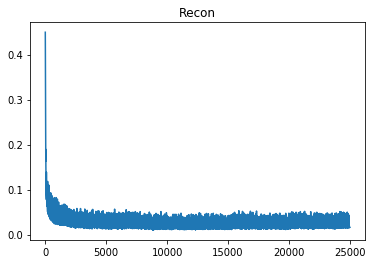

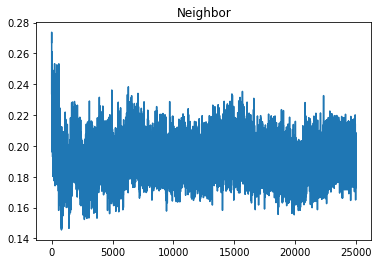

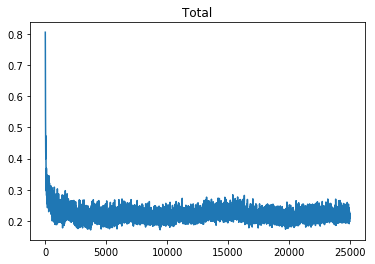

In [7]:
init_epochs = 50
learning_rate = 0.001

losses = []


if os.path.exists('runs/embeddings'):
    shutil.rmtree('runs/embeddings')
os.makedirs('runs/embeddings/')

model = StaticEncoder(hidden_size = 8, 
                      input_dim = network.number_of_nodes(), 
                      mid_layer=256).to(device)

edge_losses = []
label_losses = []
total_losses = []

fig_name = 0
for m in tqdm_notebook(range(500)):
    
    network = nx.read_graphml("runs/graphs/m" + str(207 + 1 * (m)) + ".graphml")
#     nx.draw(network, node_size=25)
#     plt.show()
    adj_list = [(int(n), [int(x) for x in list(neighbors)]) for n, neighbors in network.adjacency()]
    targets = [x[1] + [-1] * (network.number_of_nodes() - len(x[1])) for x in adj_list]
    targets = torch.tensor(targets).to(device)
    
    adj_list = [(x[0], y) for x in adj_list for y in x[1]]
    
    adj_list = torch.tensor(adj_list).to(device)
    adj_list = torch.transpose(adj_list, 0, 1)

    adj_mat = nx.adjacency_matrix(network)
    adj_mat = nx.to_numpy_matrix(network)

    attr_tensor = torch.from_numpy(adj_mat).to(device).double()
    
    degrees = dict(network.degree()).values()
    sparsity = sum(degrees) / (len(degrees)**2)
    print("sparsity: ", sparsity)
    model.corrupt = sparsity 
    
    print("transitioning:", model.linear1.weight.shape[1], "->", attr_tensor.shape[0])

    data = Data(x=attr_tensor, edge_index=adj_list).to(device)
#     model = wider_input(attr_tensor.shape[0], model)
    model = wider_cheb_input(attr_tensor.shape[0], model)
#     model = wider_output(attr_tensor.shape[0], model)
    model = wider_cheb_output(attr_tensor.shape[0], model)
    
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=learning_rate/4)
    
    neg_list = [list(set(network.nodes) - set([n for n in network.neighbors(i)])) for i in network.nodes]
    
    prods = torch.tensor([nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]).to(device).view(-1, 1)
    
    for i in tqdm_notebook(range(init_epochs)):
                
        optim.zero_grad()
        recons, embeddings, preds = model(data)
        recons = recons.double()
        
        l1 = 0.
        l2 = 0.
        
        neighbors = [int(np.random.choice([n for n in network.neighbors(i)])) for i in network.nodes]
        
        for p in model.parameters():
            if p.requires_grad:
                l1 += torch.sum(torch.abs(p))
                
        l1 *= 0.1
        l1 /= sum([p.numel() for p in model.parameters() if p.requires_grad])
        l1 = l1.to(device).float()
        
        recon_loss = nn.MultiLabelMarginLoss()(recons, targets).float() * 0.2 + nn.L1Loss()(recons, data.x).float() * 0.8
#         recon_loss = nn.BCEWithLogitsLoss(reduction='mean')(preds, data.x).float()
#         recon_loss = nn.L1Loss()(preds, data.x).float()
        neighbor_loss = nn.MSELoss()(embeddings, embeddings[neighbors]).float()
        neighbor_loss = nn.CosineEmbeddingLoss()(embeddings, embeddings[neighbors], torch.ones(embeddings.shape[0]).to(device))
        margin = neighbor_loss.item()
        neighbor_loss = neighbor_loss * 2
        for _ in range(5):
            negatives = [int(np.random.choice(i)) for i in neg_list]
#             negatives = np.random.choice(len(neg_list), len(neg_list))
            neighbor_loss += nn.CosineEmbeddingLoss(margin=margin)(embeddings, embeddings[negatives], torch.ones(embeddings.shape[0]).to(device) * -1) / 10
        
        attr_loss = nn.MSELoss()(preds, prods)
        
#         loss = recon_loss + l1
        loss = recon_loss + l1 + neighbor_loss + attr_loss
        
        label_losses.append(recon_loss.item())
        edge_losses.append(neighbor_loss.item())
        total_losses.append(loss.item())
        
        loss.backward()
        optim.step()
        if (i+1)%10 == 0:
            print("Total Loss: {:.5f} | Recon Loss: {:.5f} | Edge Loss: {:.5f} | A-M Loss: {:.5f}".format(
                loss.item(), recon_loss.item(), neighbor_loss.item(), attr_loss.item()))
    
label_losses = label_losses[9:]
edge_losses = edge_losses[9:]
total_losses = total_losses[9:]
    
plt.plot(list(range(len(label_losses))), label_losses)
plt.title("Recon")
plt.show()
    
plt.plot(list(range(len(edge_losses))), edge_losses)
plt.title("Neighbor")
plt.show()

plt.plot(list(range(len(total_losses))), total_losses)
plt.title("Total")
plt.show()

tensor([[-1.3210e-02, -2.9081e-02, -1.6578e-03,  ..., -8.8314e-02,
         -4.6331e-02, -2.2503e-02],
        [-9.6799e-03, -6.4618e-03, -2.3253e-04,  ..., -8.0830e-02,
         -2.3418e-01, -3.6270e-01],
        [ 5.5781e-03, -1.9765e-04,  6.0116e-04,  ...,  3.9684e-02,
         -3.7842e-01,  1.5470e-01],
        [-5.4231e-03,  7.8659e-03, -8.5964e-03,  ..., -2.0240e-04,
         -2.2201e-02, -1.1542e-01],
        [-1.0242e-02,  1.1085e-02,  3.6115e-03,  ...,  2.0897e-02,
         -2.1392e-02, -1.7571e-01],
        [-1.1781e-02, -2.9157e-02,  1.2995e-03,  ..., -1.2357e-02,
          2.0055e-02, -4.1021e-02]])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


C:\Users\jxbox\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
C:\Users\jxbox\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


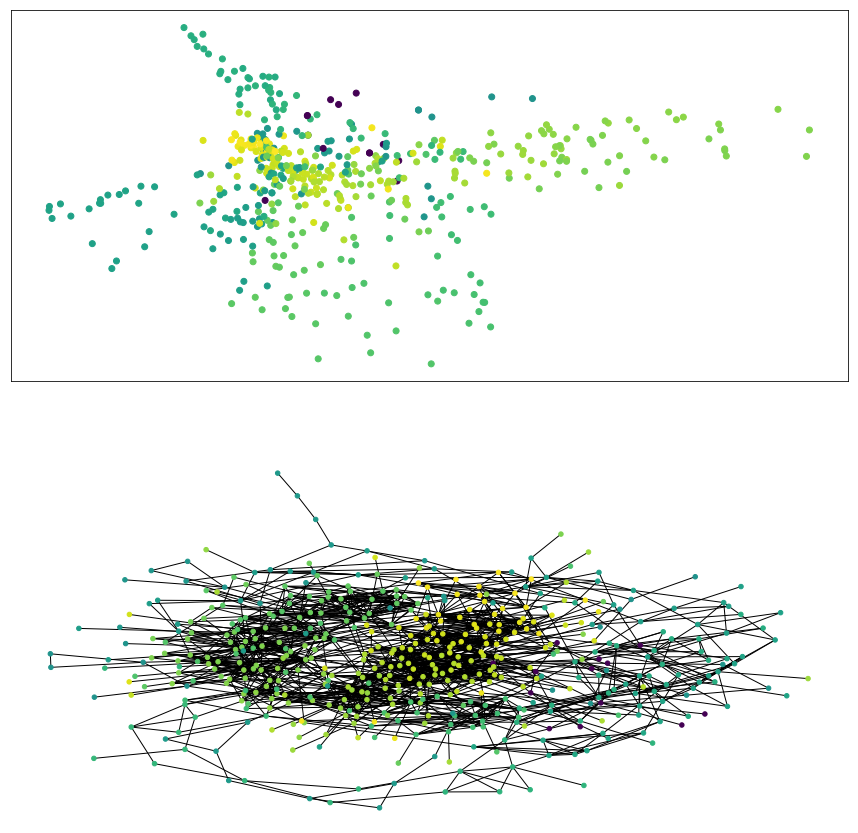

In [8]:
# embeddings = model.encode(data.x.float(), data.edge_index).detach().to("cpu")
decoded, embeddings, preds = model(data)

decoded = decoded.detach().to("cpu")
embeddings = embeddings.detach().to("cpu")
preds = preds.detach().to("cpu")

rands = np.random.choice(decoded.shape[0], 6)
print(decoded[rands])
print(adj_mat[rands])

layout = nx.layout.kamada_kawai_layout(network)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))

attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]

ax1.scatter(embeddings[:,0], embeddings[:,1], c=attrs)

plt.setp((ax1, ax2), xticks=np.linspace(-0.1, 0.5, 0.05), xticklabels=np.linspace(-0.1, 0.5, 0.05),
        yticks=np.linspace(-0.1, 0.5, 0.05), yticklabels=np.linspace(-0.1, 0.5, 0.05))


# plt.sca(ax1)
# plt.xticks(np.linspace(-0.1, 0.5, 0.05))
# plt.yticks(np.linspace(-0.1, 0.5, 0.05))

nx.draw(network, node_color=attrs, pos=layout, node_size=20, ax=ax2)

plt.show()

true attrs


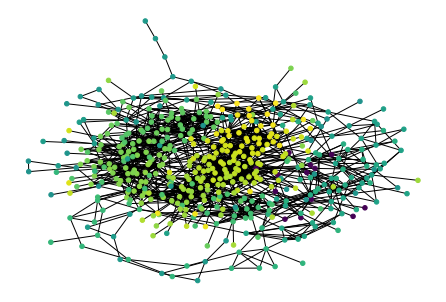

reconstructed attrs


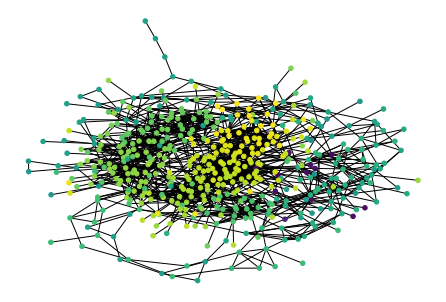

In [9]:
%matplotlib inline

attrs = [nx.get_node_attributes(network, 'apt_markakis')[i] for i in network.nodes]
print("true attrs")
nx.draw(network, node_color=attrs, pos=layout, node_size=20)
plt.show()

print("reconstructed attrs")
nx.draw(network, node_color=preds.squeeze(), pos=layout, node_size=20)
plt.show()
    

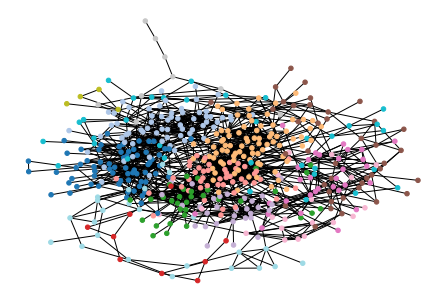

best communities
0.7336509668191943


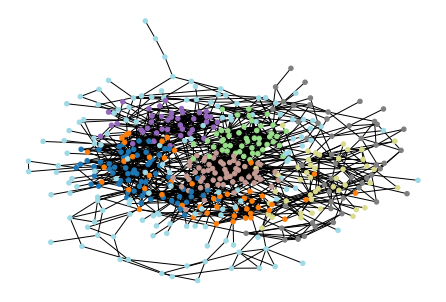

k means communities
0.6789908398267133


In [12]:
%matplotlib inline
%matplotlib inline

communities = cm.best_partition(network)
best_vec = [communities.get(node) for node in network.nodes()]
mod = cm.modularity(communities,network)
community_vec = np.zeros(network.number_of_nodes())
for idx, c in enumerate(communities):
    c = [int(x) for x in c]
    community_vec[c] = idx
    
nx.draw(network, pos=layout, node_size=20, node_color=best_vec, cmap='tab20')
# plt.savefig('communities.png')
num_coms = len(set(communities.values()))
plt.show()
print("best communities")
print(mod)

clusters = cluster.KMeans(num_coms, n_init=100).fit_predict(embeddings)
nx.draw(network, pos=layout, node_size=20, node_color=clusters, cmap='tab20')
cluster_dict = dict([(list(network.nodes)[i], clusters[i]) for i in range(len(clusters))])
mod = cm.modularity(cluster_dict,network)
plt.show()
print("k means communities")
print(mod)
# plt.savefig('kmeans.png')

In [11]:
files = sorted([int(x[:-4]) for x in os.listdir('runs/embeddings/')])
files = [str(x) + '.png' for x in files]

with imageio.get_writer('runs/embedding_gifs/' + str(int(time.time())) + '.gif', mode='I', duration=0.35) as writer:
    for f in files:
        filename = 'runs/embeddings/' + f
        image = imageio.imread(filename)
        writer.append_data(image)
